**Mounting to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import necessary packages**

In [ ]:
import pandas_datareader as pdr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
import matplotlib.patches as patches
from numpy import array
from importlib import reload 
# ARIMA, SARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import autocorrelation_plot
# Tensorflow 2.0 includes Keras
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Flatten,GRU, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

**Helper Functions**

In [ ]:
gain = lambda x: x if x > 0 else 0
loss = lambda x: abs(x) if x < 0 else 0
z_disribution = lambda x: (x - x.mean()) / x.std() 
norm = lambda x: ( x - x.min() ) / ( x.max() - x.min() )
binary = lambda data: [1 if x > 0 else 0 for x in data]

**Visualization Functions**

In [ ]:
def bbollinger_bands(stock, std=2):        
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.MA21, color='#ad6eff', label='Moving Average (21 days)')
    #plt.plot(stock.index, stock.MA7, color='#ff6e9d', label='Moving Average (7 days)')
    plt.plot(stock.index, stock.Upper_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.Lower_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_band, stock.Lower_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Bollinger Bands', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()

def vvolume(stock):
    # Volume plot
    plt.figure(figsize=(16,2))
    plt.style.use('seaborn-whitegrid')
    plt.title('Volume', fontSize=15)
    plt.ylabel('Volume', fontSize=12)
    plt.plot(stock.index, stock['Volume'].ewm(21).mean())
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()    

def mmacd(stock):
    # MACD
    plt.figure(figsize=(16,2))
    plt.plot(stock.MACD, label='MACD', color = '#b278ff')
    plt.plot(stock.Signal, label='Signal', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontSize=15)
    plt.ylabel('Strength', fontSize=12)
    plt.show()    

def rrsi(stock):
    # RSI
    plt.figure(figsize=(16,2)) 
    plt.plot(stock.index, stock.RSI, color='#ad6eff')
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.axhline(20, color='#f9989c')
    plt.axhline(80, color='#60e8ad')
    plt.title('RSI', fontSize=15)
    plt.ylabel('%', fontSize=12)
    plt.ylim([0, 100])
    plt.show()
    
def hist(data, name, bins=50):
    plt.rcParams['figure.dpi'] = 227
    plt.figure(figsize=(16,6))
    plt.style.use('seaborn-whitegrid')
    plt.hist(data, bins=bins)
    plt.title(name, fontSize=16)
    plt.xlabel('Values', fontSize=13)
    plt.ylabel('Quantities', fontSize=13)
    plt.show()
    
def qqplot(data):
    plt.rcParams['figure.dpi'] = 227
    plt.figure(figsize=(16,6))
    plt.style.use('seaborn-whitegrid')
    sm.qqplot(data.dropna(), line='s', scale=1)
    plt.title('Check for Normality', fontSize=16)
    plt.show()
    
def compare_stocks(stocks, value='Close', by='month', scatter=False):
    '''
    Function groups stocks' Close values
    '''
    plt.rcParams['figure.dpi'] = 227
    plt.figure(figsize=(16,6))
    plt.style.use('seaborn-whitegrid')
    group_by_stock = {}
    
    for stock in list(stocks.keys()): 
        
        if by == 'month': group_by = stocks[stock].index.month
        if by == 'day': group_by = stocks[stock].index.day
        if by == 'year': group_by = stocks[stock].index.year
        
        a = stocks[stock].groupby(group_by).mean()[value]
        normalized_price = (a-a.mean())/a.std()
        group_by_stock[stock] = normalized_price
        
        if scatter == False:
            plt.plot(normalized_price, label=stock)
        else:
            plt.scatter(normalized_price.keys(), normalized_price.values, label=stock)       
    
    plt.plot(pd.DataFrame(group_by_stock).mean(axis=1), label='ALL', color='black', linewidth=5, linestyle='--')    
    plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1, ncol=4, fontsize=12, title='Stocks')
    plt.title(value+' by '+by, fontSize=14)
    plt.xlabel('Period', fontSize=12)
    plt.ylabel(value, fontSize=12)
    plt.show()
    
    
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.MA21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.Upper_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.Lower_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_band, stock.Lower_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    plt.title('Trading History', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.show()

**Train/Test Splitter**

In [ ]:
# split a multivariate sequence into samples
def split_sequences(features, target, n_steps, split=True, ratio=0.8):
    X, y = [], []
    for i in range(len(features)):
        end_ix = i + n_steps
        if end_ix > len(features):
            break
        seq_x, seq_y = features[i:end_ix], target[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    if split == True:
        # X_train, y_train, X_test, y_test
        X_train = np.array(X[:round(len(X)*ratio)])
        y_train = np.array(y[:round(len(X)*ratio)])
        X_test  = np.array(X[round(len(X)*ratio):])
        y_test  = np.array(y[round(len(X)*ratio):])
        return X_train, y_train, X_test, y_test
    else:
        return np.array(X), np.array(y)    

# Evaluation of ML model
def evaluation(X, y, model, n_preds=10, random=True, show_graph=True):
      
    n_steps = X.shape[1]
    max_random_int = len(y) - n_steps
    y_true, y_pred, prediction_accuracy, slices = [], [], [], []
    
    for i in range(n_preds):        
        
        if random == True:          
            position = np.random.randint(0, max_random_int)
        else: 
            position = i
            
        y_hat = model.predict(X[position:position+1])[0][0]
        y_pred.append(y_hat)
        y_true.append(y[position])               
        y_current = y[position]
                
        # If we predit return, c = 0, else c = previous sequence position
        if y.min() < 0:
            c = 0
        else: 
            c = y[position-1]
        
        if ((y_hat > c) & (y_current > c)) or ((y_hat < c) & (y_current < c)): acc = 1           
        else: acc = 0
        
        prediction_accuracy.append(acc)       
        slices.append((list(y[position-n_steps:position+1]), list(y[position-n_steps:position]) + [y_hat], acc))
        
    if show_graph == True:
        plt.rcParams['figure.dpi'] = 227
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(16,6))
        plt.bar(range(n_preds), y_true[:], width=.7, alpha=.6, color="#4ac2fb", label="True")
        plt.bar(range(n_preds), y_pred[:], width=.7, alpha=.6, color="#ff4e97", label="Predicted")
        plt.axhline(0, color="#333333", lw=.8)
        plt.legend(loc=1)
        plt.title('Daily Return Prediction', fontSize=15)
        plt.show()
    
    print('MSE:', mean_squared_error(y_true, y_pred))
    Accuracy = round((sum(prediction_accuracy)/len(prediction_accuracy))*100 ),2)
    print('Accuracy: {}%'.format( round((sum(prediction_accuracy)/len(prediction_accuracy))*100 ),2) )
    return slices, np.array(y_true), np.array(y_pred),Accuracy
    
# Function to scale all features to [0-1]    
def scale(dataframe, scale=(0,1)):
    columns = dataframe.columns
    scaler = MinMaxScaler()
    scaler.feature_range = scale
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=columns).dropna()
    
def bb_trading(stock, budget=15000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.MA21) and (abs(1 - today.Close / today.Lower_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.MA21) and (abs(1 - today.Upper_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net
    
def macd_trading(stock, budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].MACD, stock.loc[0].Signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.MACD, today.Signal)

        if state != prev_state:

            # BUY
            if (today.MACD > today.Signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.MACD < today.Signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net    

**Feature Engineering Functions**

In [ ]:
import pandas as pd
from sklearn import preprocessing
# from functions import gain, loss


# Relative Strength Index
def rsi(stock):    
    # Create a list, fill first 14 values with 'None'
    rsi_list = [None for i in range(14)]
    # Change as an input
    stock = stock.Change
    
    # Calculating first RSI
    avg_gain = sum([i for i in stock[1:15] if i > 0])/14
    avg_loss = sum([abs(i) for i in stock[1:15] if i < 0])/14
    rs = avg_gain / avg_loss
    rsi = 100 - ( 100 / ( 1 + rs ))
    rsi_list.append(rsi)
    
    # Calculating following RSI's
    for i in range(15, len(stock)):
        avg_gain = (avg_gain * 13 + gain(stock[i]))/14
        avg_loss = (avg_loss * 13 + loss(stock[i]))/14
        rs = avg_gain / avg_loss
        rsi = 100 - ( 100 / ( 1 + rs ))
        rsi_list.append(rsi)
    
    return rsi_list   
 
# Moving Average Convergence/Divergence        
def macd(stock):
    exp1 = stock.Close.ewm(span=12, adjust=False).mean()
    exp2 = stock.Close.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal
 
# Bollinger Bands    
def bollinger_bands(stock, window=21):
    rolling_mean = stock.Close.rolling(window).mean()
    rolling_std = stock.Close.rolling(window).std()
    upper_band = rolling_mean + (rolling_std*2)
    lower_band = rolling_mean - (rolling_std*2)
    return upper_band, lower_band
 
# Moving Average (7 days period)    
def ma7(stock):
    return stock.Close.rolling(7).mean()
  
# Moving Average (21 days period)  
def ma21(stock):
    return stock.Close.rolling(21).mean()
    
def momentum(data, n_days):
    m = [None for i in range(n_days)]    
    for i in range(len(data) - n_days):
        end = i + n_days
        m.append(data[i] - n_days)
    return m

**Creation of features**

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/raw_stocks')

['bitcoin_data.csv',
 'litcoin_data.csv',
 'BNB_Coin_data.csv',
 'etherium_data.csv']

In [ ]:
files = os.listdir('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/raw_stocks')
stocks = {}
for file in files:
    name = file.lower().split('.')[0]
    stocks[name] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/raw_stocks/'+file) 
    stocks[name] = stocks[name].drop(['Dividends', 'Stock Splits'], axis =1)   

    # distance between Highest and Opening price
    stocks[name]['HO'] = stocks[name]['High'] - stocks[name]['Open']
    # distance between Lowest and Opening price 
    stocks[name]['LO'] = stocks[name]['Low'] - stocks[name]['Open']
    #Gain feature
    stocks[name]['Gain'] = stocks[name]['Close'] - stocks[name]['Open']
    # Return Feature
    stocks[name]['Return'] = round(stocks[name]['Close'] / stocks[name]['Open'] - 1, 3)
    # Change Feature
    # Change of the price from previous day, absolute value
    stocks[name]['Change'] = (stocks[name].Close - stocks[name].Close.shift(1)).fillna(0)
    # Date Feature
    stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date'])
    stocks[name].set_index('Date', inplace=True)
    # Volatility Feature
    stocks[name]['Volatility'] = stocks[name].Close.ewm(21).std()
    # Moving Average, 7 days
    stocks[name]['MA7'] = ma7(stocks[name])
    # Moving Average, 21 days
    stocks[name]['MA21'] = ma21(stocks[name])
    # Momentum
    stocks[name]['Momentum'] = momentum(stocks[name].Close, 3)
    # RSI (Relative Strength Index)
    stocks[name]['RSI'] = rsi(stocks[name])
    # MACD - (Moving Average Convergence/Divergence)
    stocks[name]['MACD'], stocks[name]['Signal'] = macd(stocks[name])
    # Upper Band and Lower Band for Bollinger Bands
    stocks[name]['Upper_band'], stocks[name]['Lower_band'] = bollinger_bands(stocks[name])
    # dropped the NA values
    stocks[name].dropna(inplace=True)
    # Saving the feature engineered datasets in the stocks folder
    stocks[name].to_csv('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/stocks/'+name+'.csv')

In [ ]:
stocks['bitcoin_data']

Open          High           Low         Close  \
Date                                                                 
2014-10-07    330.584015    339.247009    320.481995    336.187012   
2014-10-08    336.115997    354.364014    327.187988    352.940002   
2014-10-09    352.747986    382.726013    347.687012    365.026001   
2014-10-10    364.687012    375.066986    352.963013    361.562012   
2014-10-11    361.362000    367.191010    355.950989    362.299011   
...                  ...           ...           ...           ...   
2022-09-19  19418.572266  19639.480469  18390.318359  19544.128906   
2022-09-20  19545.591797  19602.457031  18813.455078  18890.789062   
2022-09-21  18891.283203  19674.630859  18290.314453  18547.400391   
2022-09-22  18534.650391  19456.910156  18415.591797  19413.550781   
2022-09-23  19432.929688  19432.929688  19269.771484  19382.259766   

                 Volume          HO           LO        Gain  Return  \
Date                                                                   
2014-10-07     49199900    8.662994   -10.102020    5.602997   0.017   
2014-10-08     54736300   18.248016    -8.928009   16.824005   0.050   
2014-10-09     83641104   29.978027    -5.060974   12.278015   0.035   
2014-10-10     43665700   10.379974   -11.723999   -3.125000  -0.009   
2014-10-11     13345200    5.829010    -5.411011    0.937012   0.003   
...                 ...         ...          ...         ...     ...   
2022-09-19  40177002624  220.908203 -1028.253906  125.556641   0.006   
2022-09-20  36791346508   56.865234  -732.136719 -654.802734  -0.034   
2022-09-21  46363793975  783.347656  -600.968750 -343.882812  -0.018   
2022-09-22  41135767926  922.259766  -119.058594  878.900391   0.047   
2022-09-23  39606927360    0.000000  -163.158203  -50.669922  -0.003   

                Change   Volatility           MA7          MA21      Momentum  \
Date                                                                            
2014-10-07    6.108002    37.256567    347.691572    387.352142    325.865997   
2014-10-08   16.752991    36.492766    343.309431    382.380999    317.510010   
2014-10-09   12.085999    35.302200    341.874289    379.551761    327.079010   
2014-10-10   -3.463989    34.254290    342.167149    377.969190    333.187012   
2014-10-11    0.737000    33.229099    346.943294    375.749906    349.940002   
...                ...          ...           ...           ...           ...   
2022-09-19  124.623047  1890.003185  19871.828962  20158.889602  19769.583984   
2022-09-20 -653.339844  1897.766515  19670.983538  20115.745815  20124.576172   
2022-09-21 -343.388672  1917.887862  19429.027902  20044.204706  19416.505859   
2022-09-22  866.150391  1895.424701  19387.933594  20010.224237  19541.128906   
2022-09-23  -31.291016  1872.769093  19332.172991  19982.247489  18887.789062   

                  RSI        MACD      Signal    Upper_band    Lower_band  
Date                                                                       
2014-10-07  28.745779  -28.424133  -22.746137    460.526893    314.177392  
2014-10-08  34.876115  -26.964063  -23.589722    449.523379    315.238619  
2014-10-09  38.956384  -24.548725  -23.781523    444.211850    314.891671  
2014-10-10  38.217311  -22.652939  -23.555806    442.689025    313.249355  
2014-10-11  38.484714  -20.850691  -23.014783    439.198228    312.301583  
...               ...         ...         ...           ...           ...  
2022-09-19  42.190626 -385.770169 -357.850944  21960.407866  18357.371338  
2022-09-20  38.230514 -454.896157 -377.259987  21995.385540  18236.106090  
2022-09-21  36.301870 -531.263521 -408.060694  22044.859623  18043.549790  
2022-09-22  43.978781 -515.946598 -429.637875  22029.119894  17991.328581  
2022-09-23  43.773531 -500.562576 -443.822815  22019.695140  17944.799838  

[2909 rows x 19 columns]

**Exploratory Data Analysis**

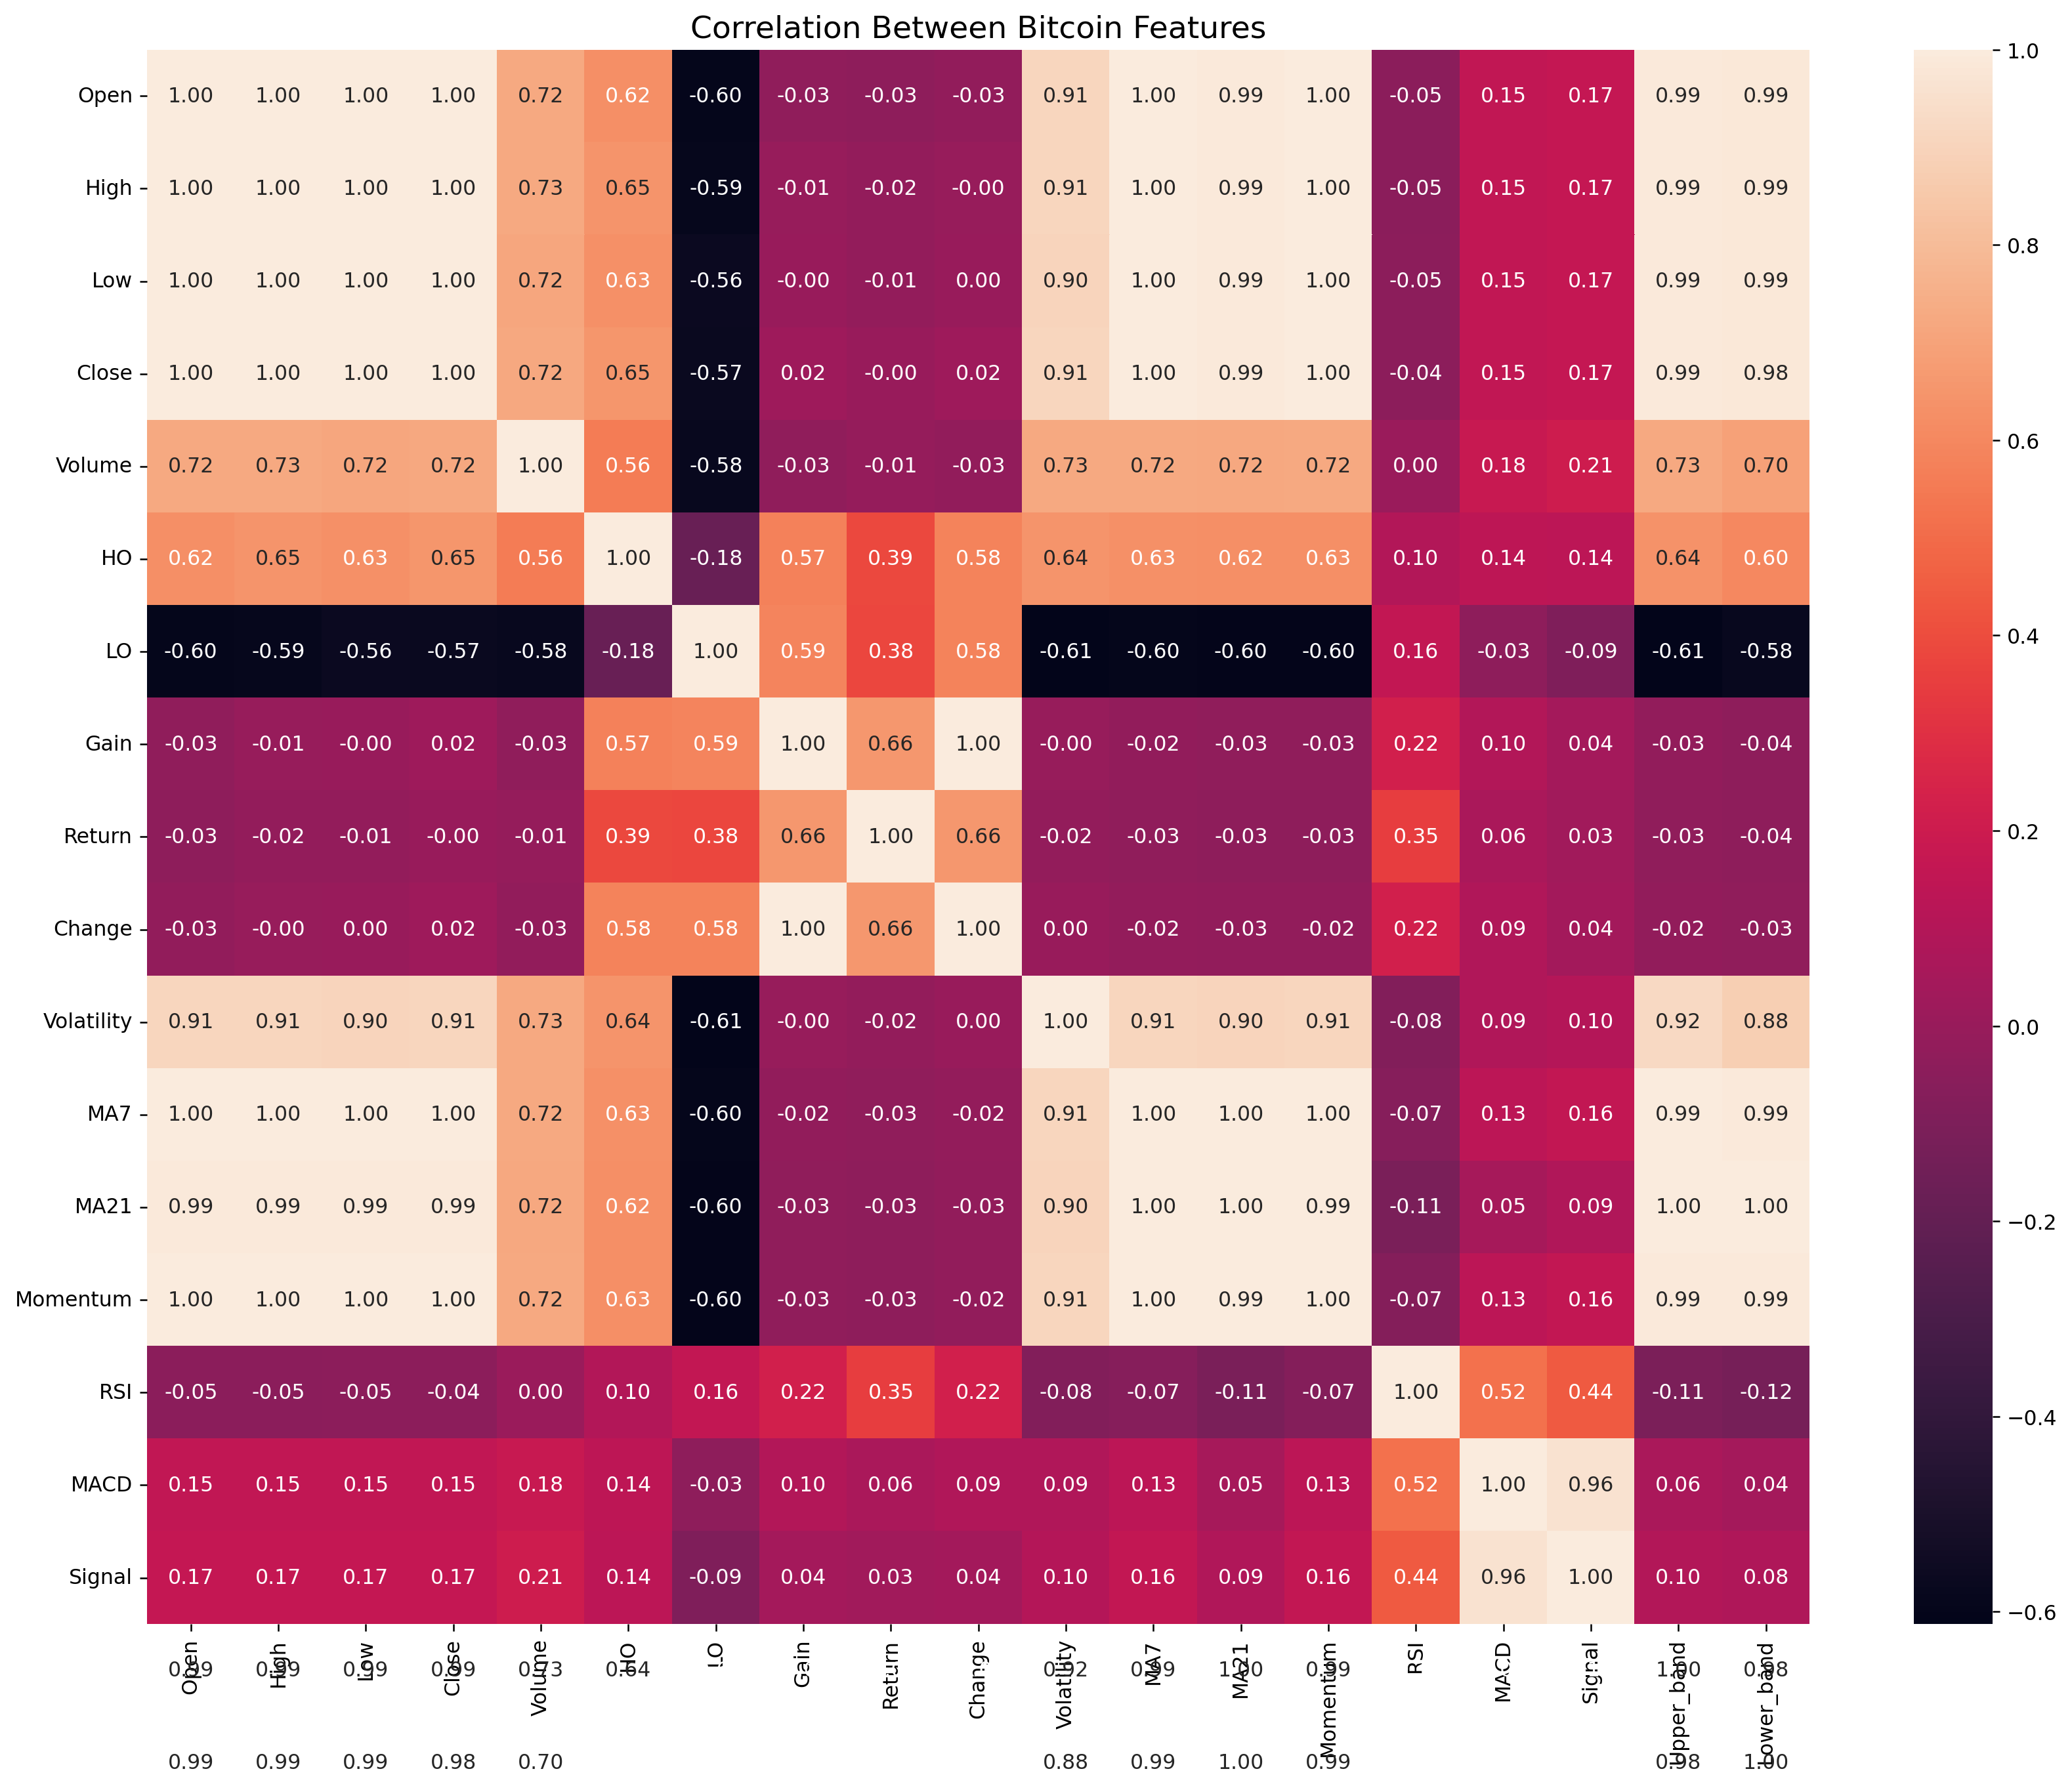

In [ ]:
plt.rcParams['figure.dpi'] = 227
plt.figure(figsize=(18,14))
sns.heatmap(stocks['bitcoin_data'].corr(), annot=True, fmt='.2f')
plt.ylim(17, 0)
plt.title('Correlation Between Bitcoin Features', fontSize=15)
plt.show()

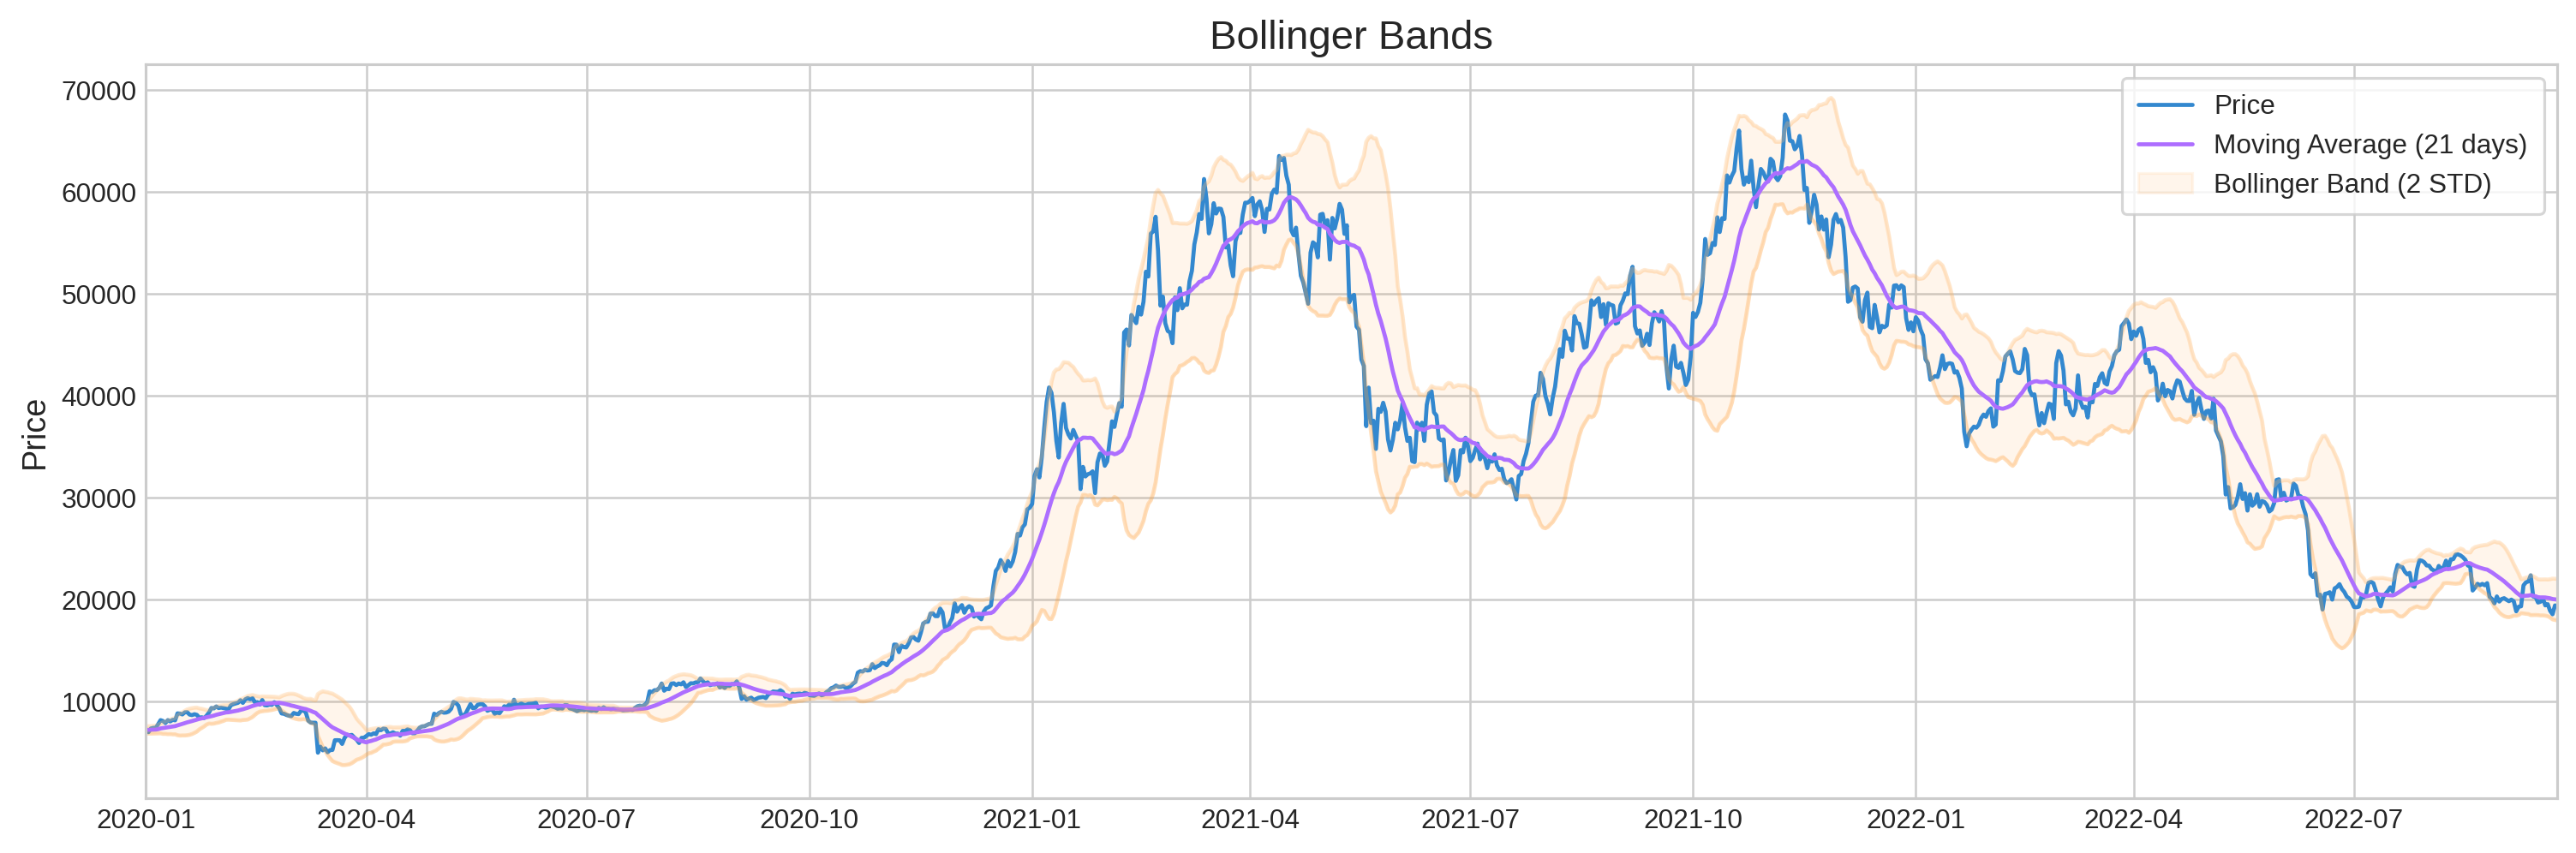

In [ ]:
bbollinger_bands(stocks['bitcoin_data'].loc['2020':'2022'])

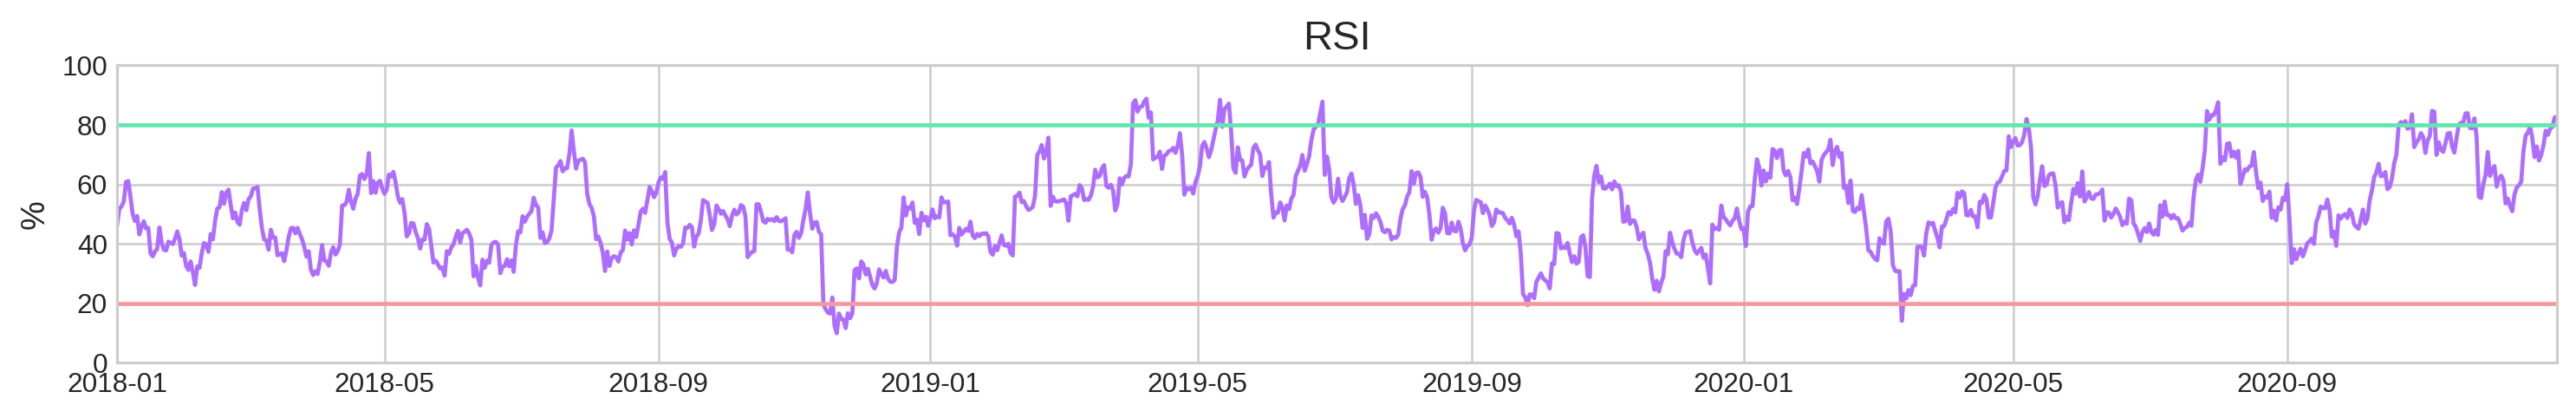

In [ ]:
rrsi(stocks['bitcoin_data'].loc['2018':'2020'])

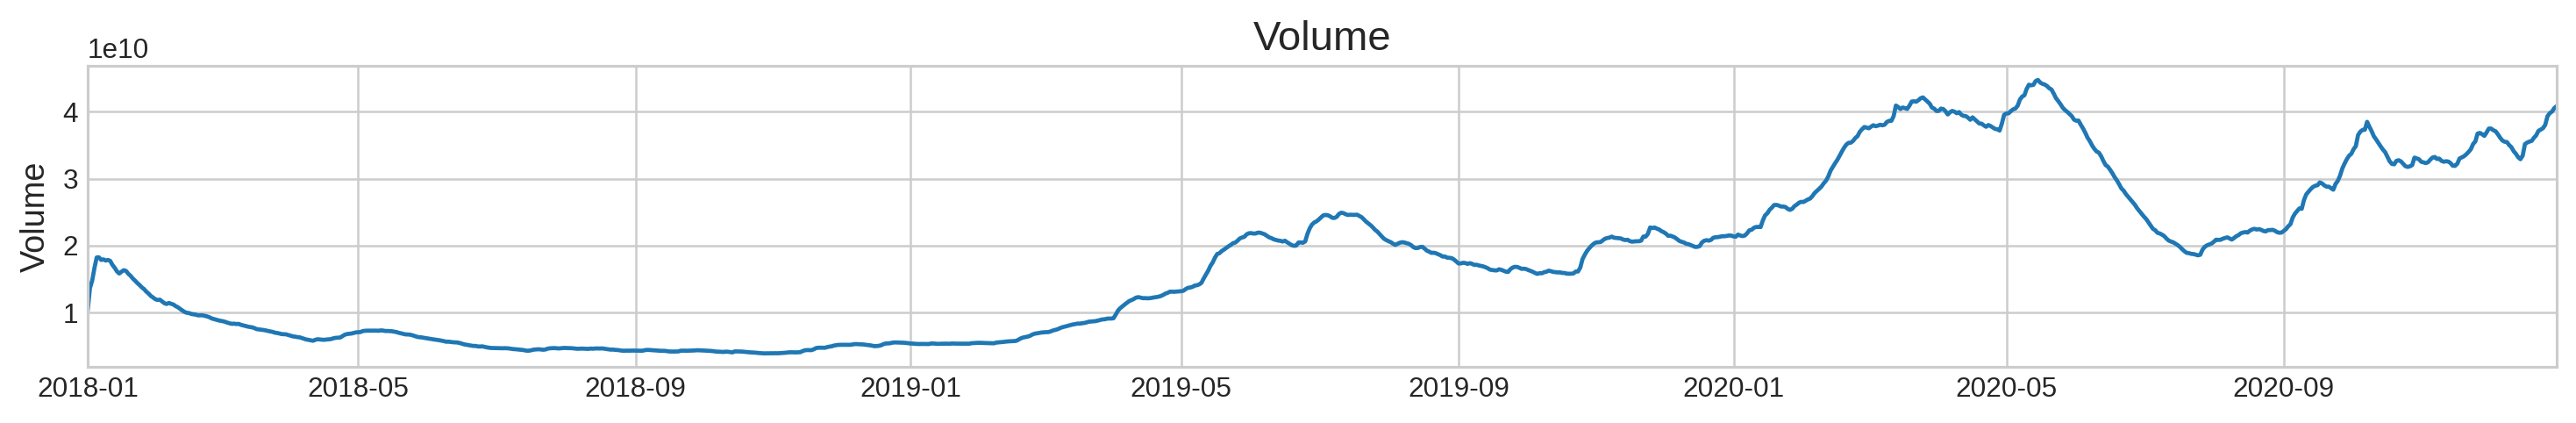

In [ ]:
vvolume(stocks['bitcoin_data'].loc['2018':'2020'])

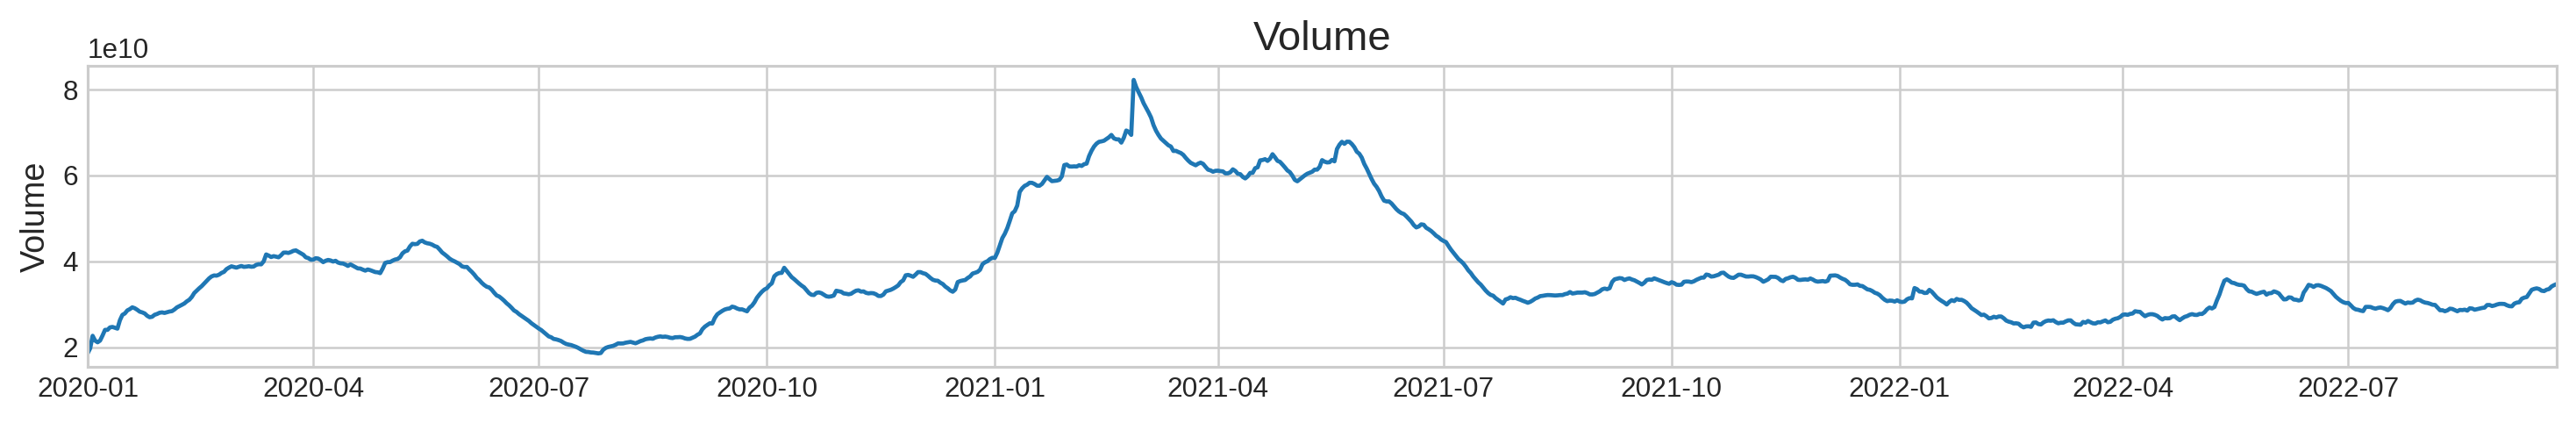

In [ ]:
vvolume(stocks['bitcoin_data'].loc['2020':'2022'])

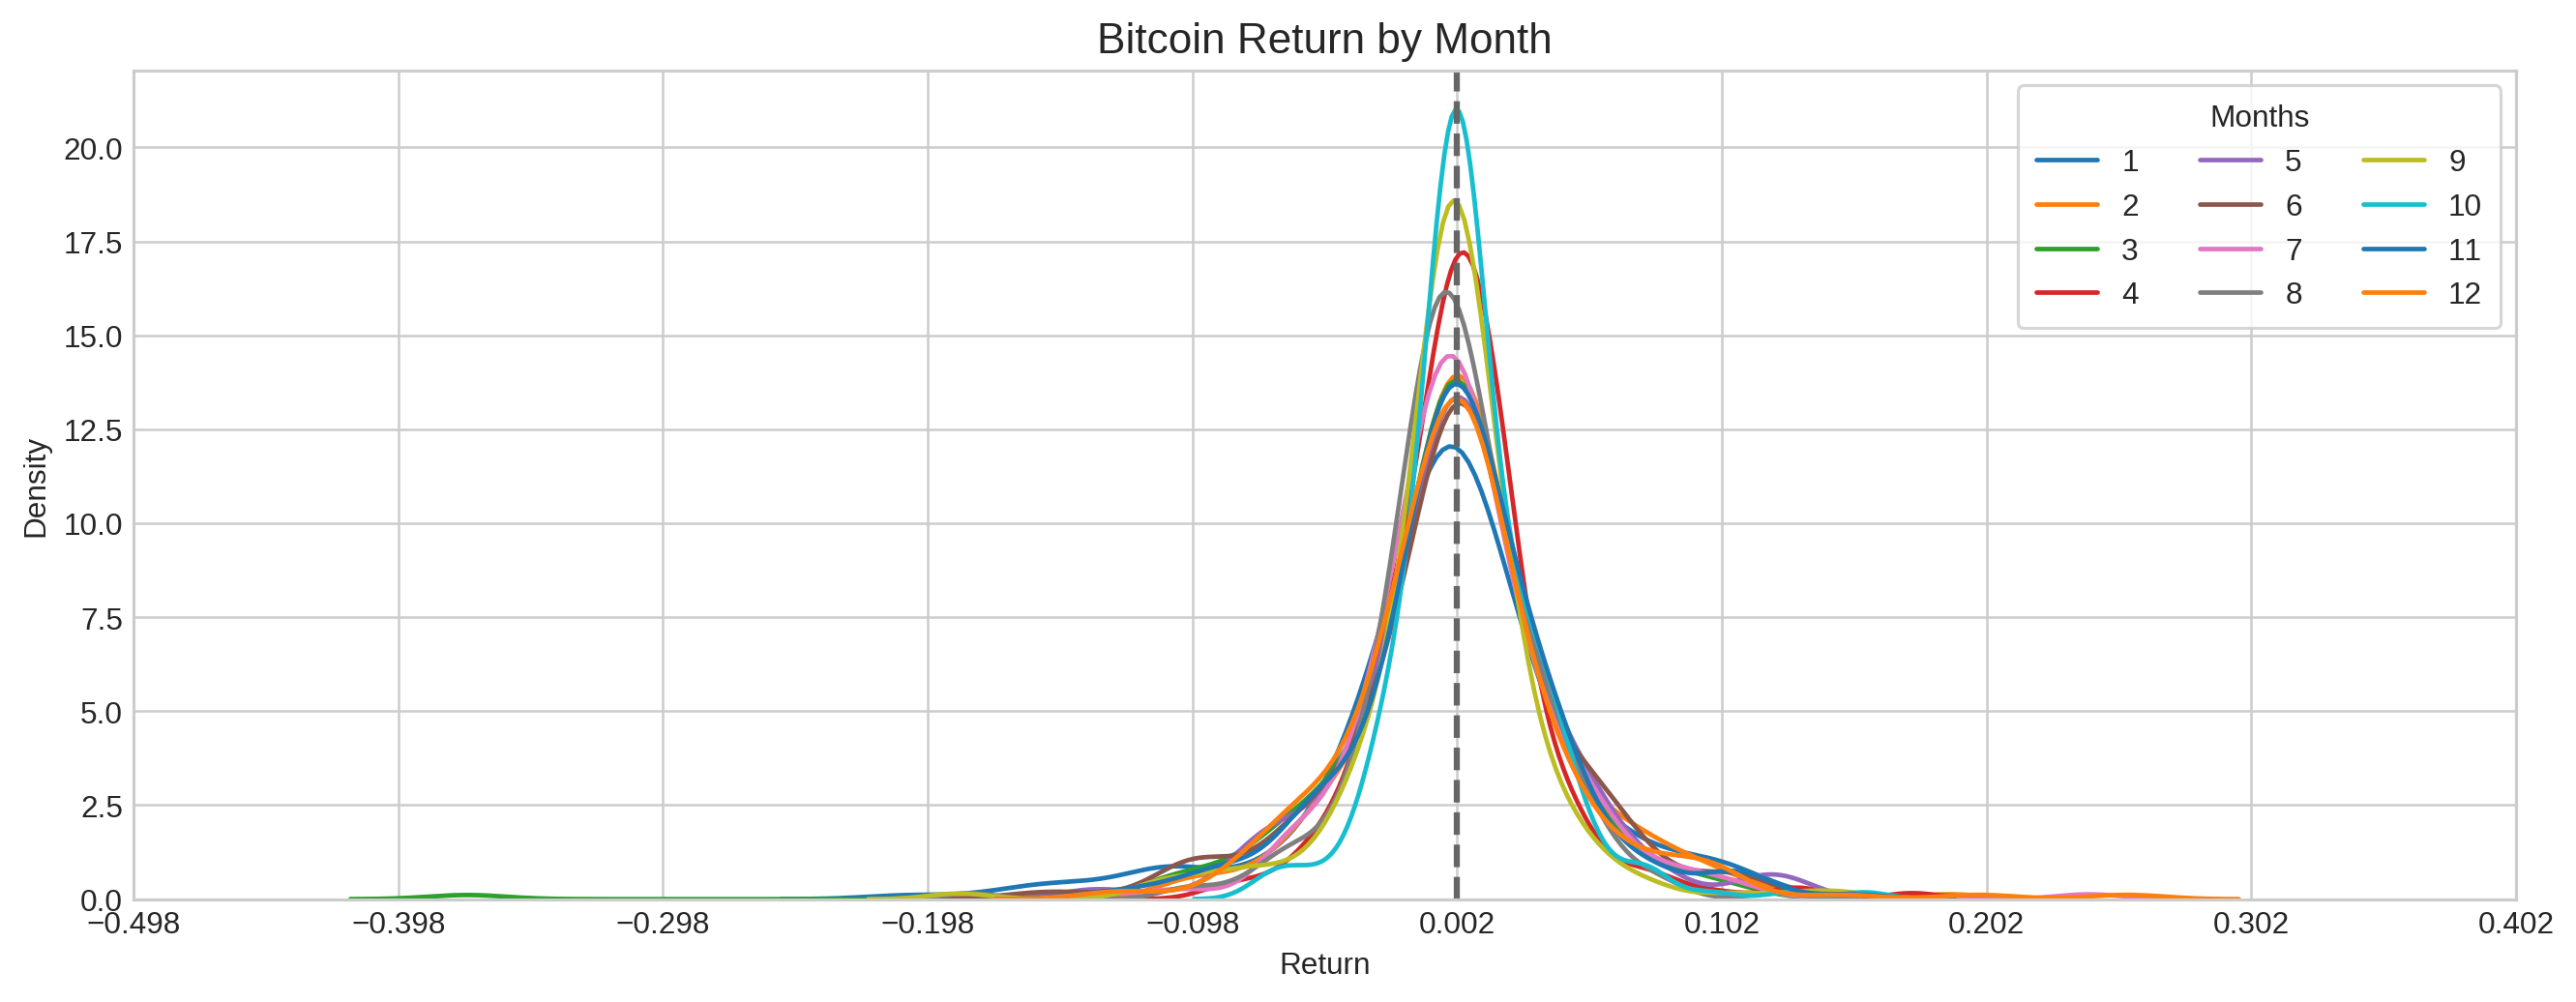

In [ ]:
plt.figure(figsize=(14,5))
plt.style.use('seaborn-whitegrid')
for i in range(1,13):
    volatility = stocks['bitcoin_data'][stocks['bitcoin_data'].index.month==i].Return
    sns.distplot(volatility, hist=False, label=i)
    plt.legend(frameon=True, loc=1, ncol=3, fontsize=10, borderpad=.6, title='Months')
plt.axvline(stocks['bitcoin_data'].Return.mean(), color='#666666', ls='--', lw=2)
plt.xticks(plt.xticks()[0] + stocks['bitcoin_data'].Return.mean())
plt.title('Bitcoin Return by Month', fontSize=14)
plt.show()

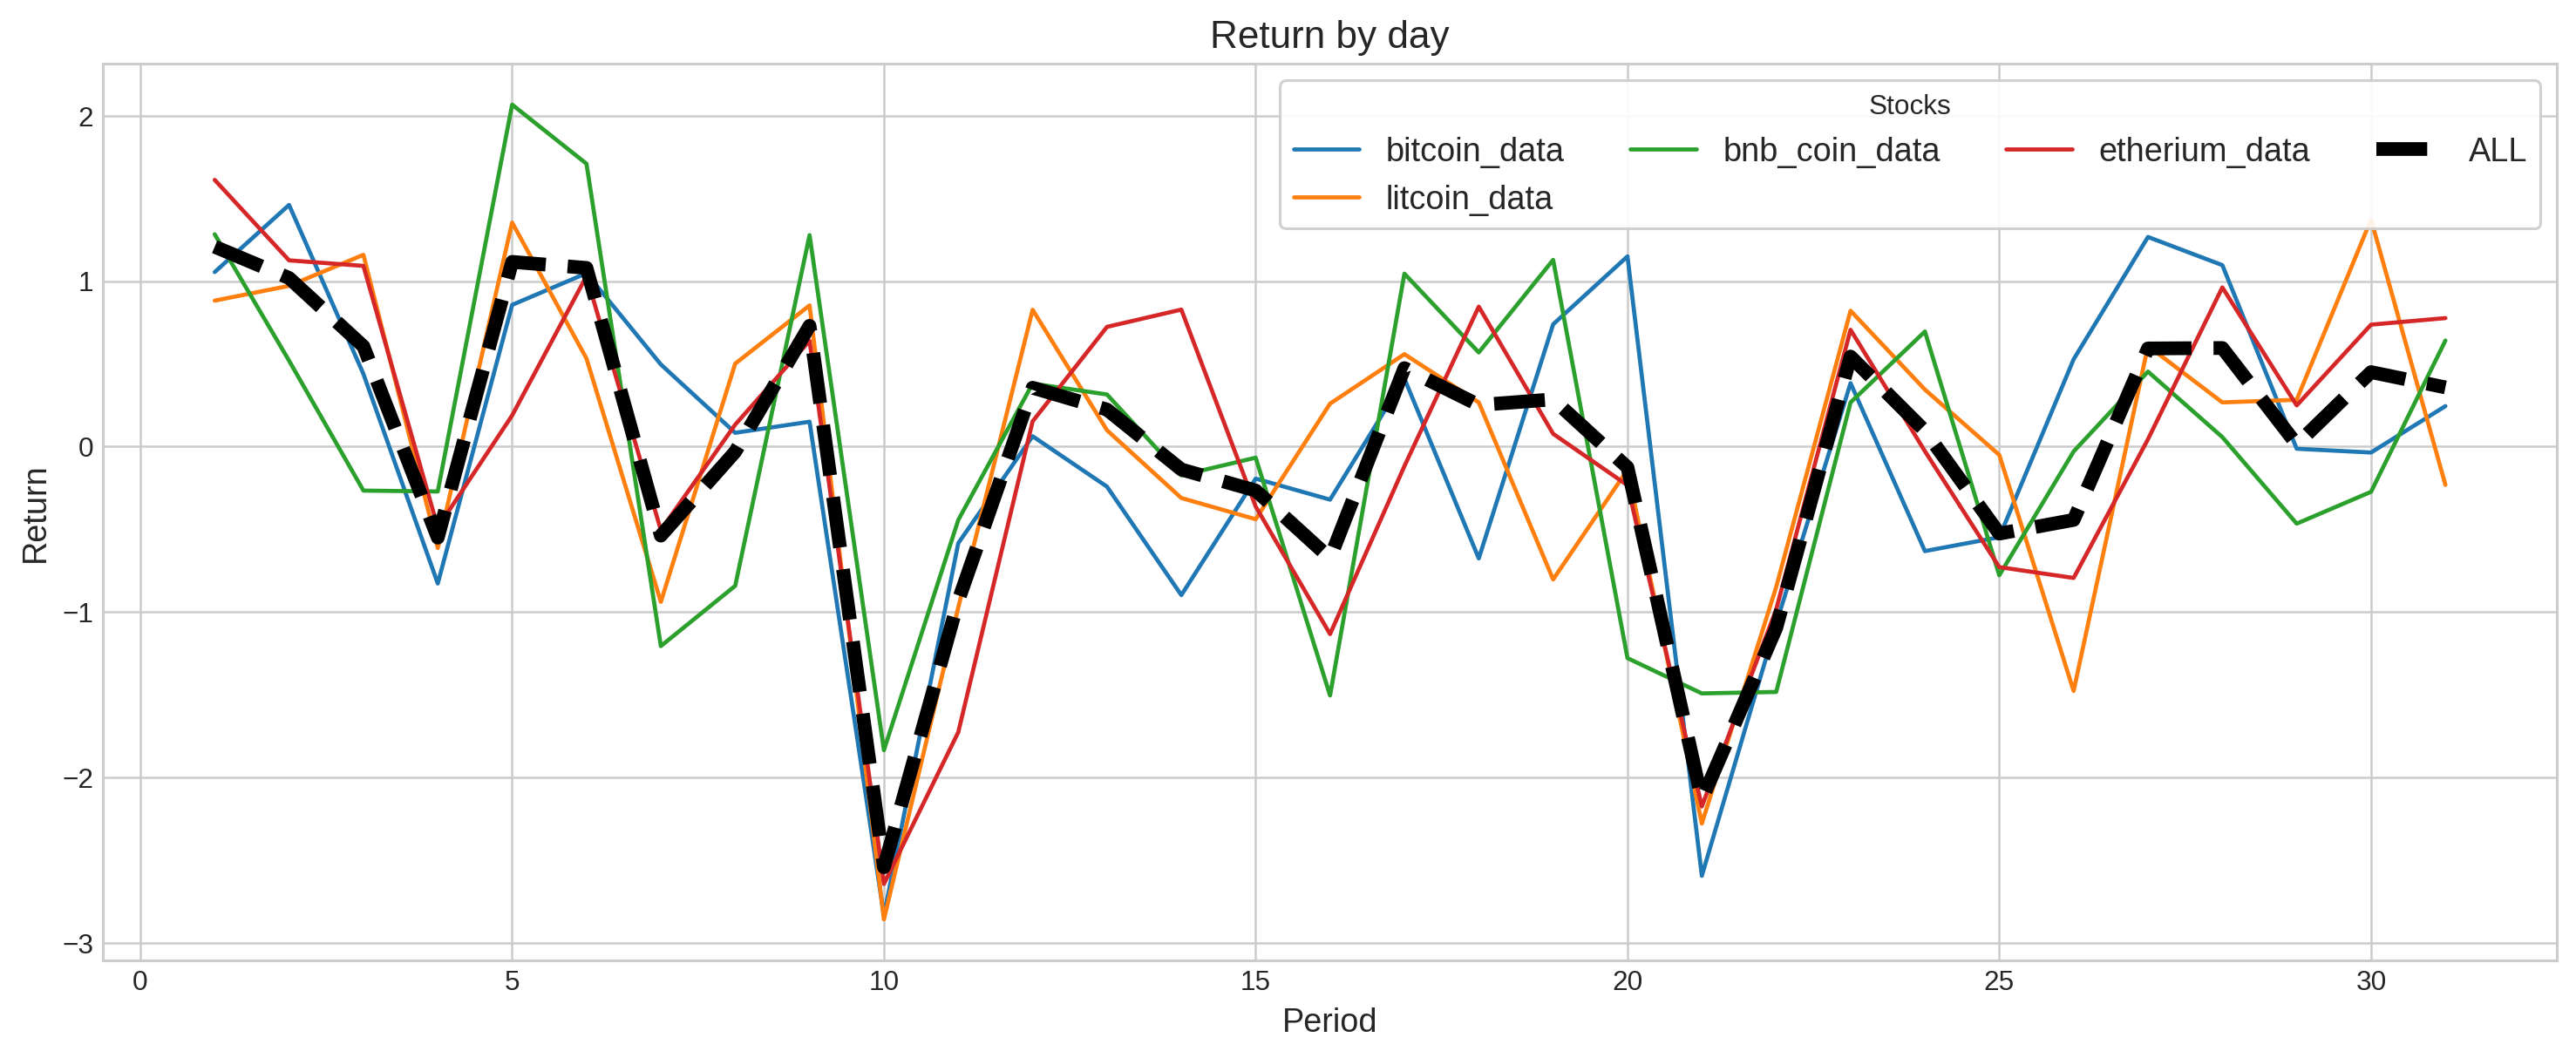

In [ ]:
compare_stocks(stocks, value='Return', by='day', scatter=False)

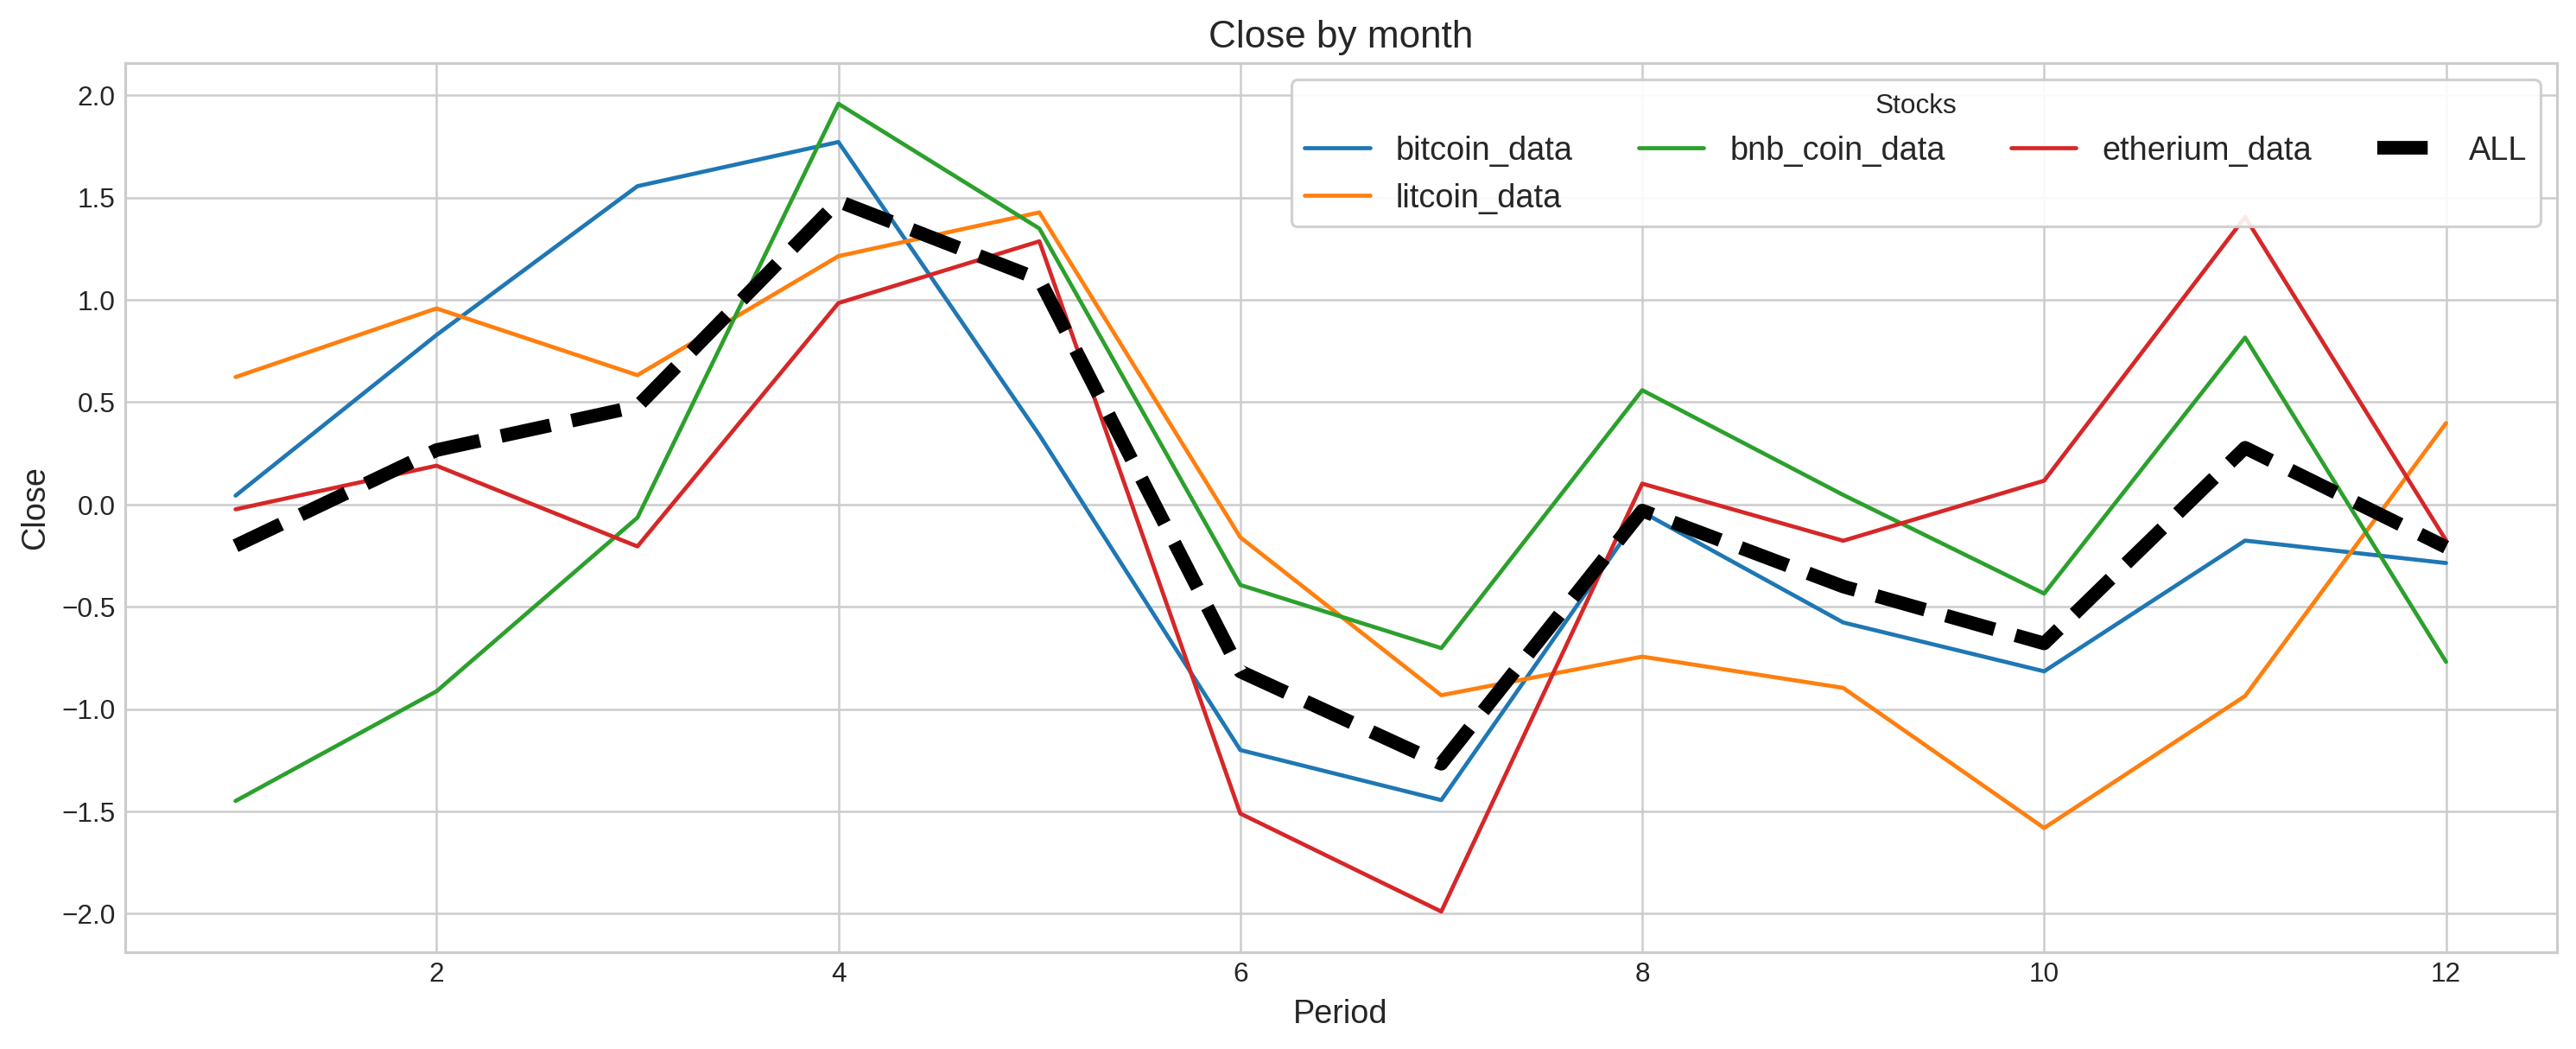

In [ ]:
compare_stocks(stocks, value='Close', by='month', scatter=False)

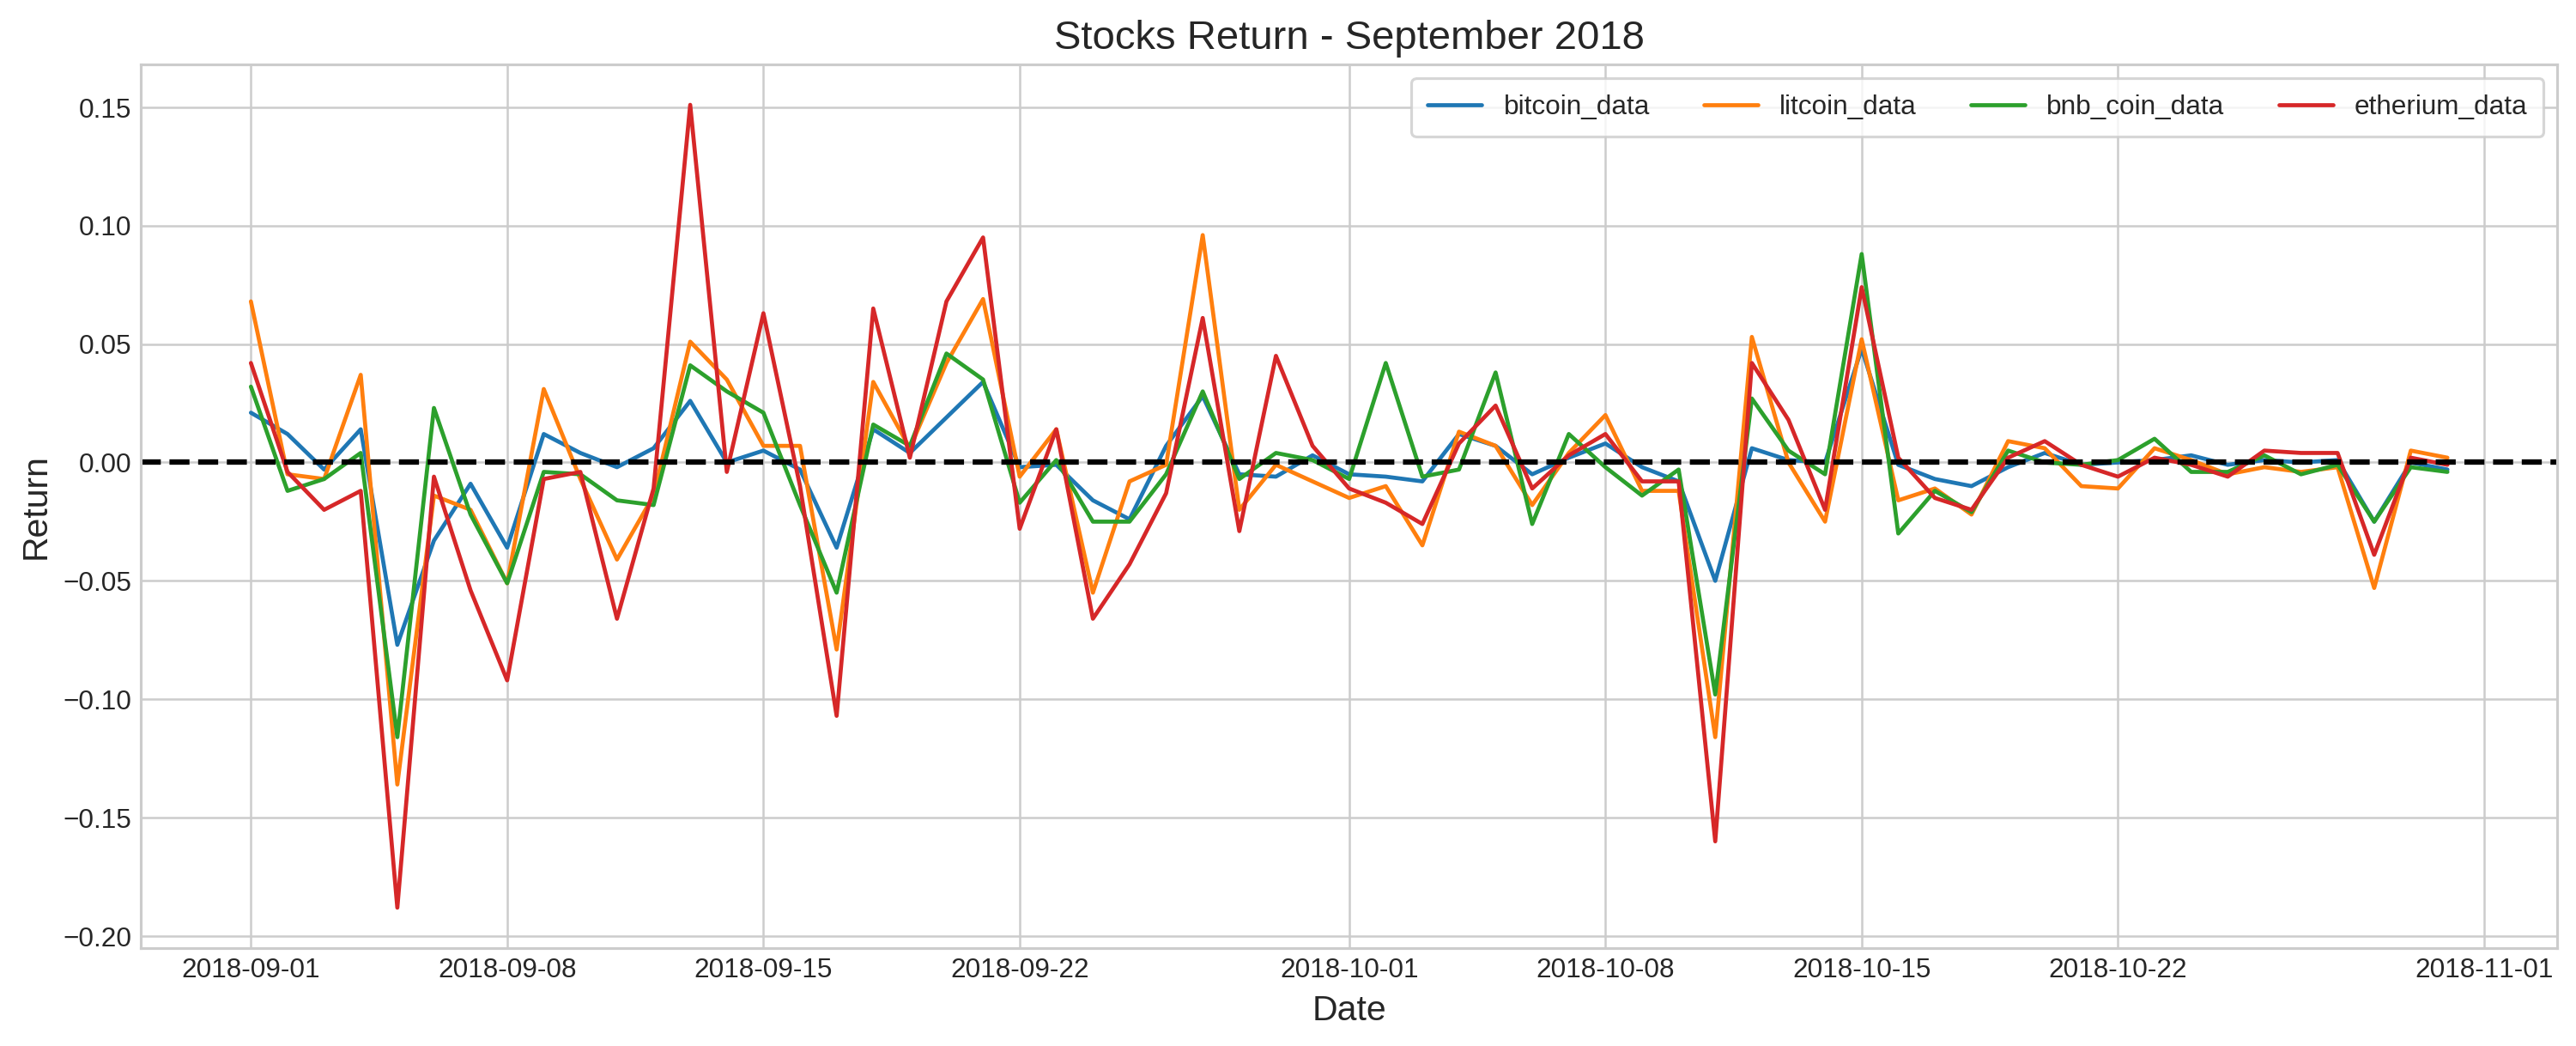

In [ ]:
stocks_return_correlation = {}

plt.rcParams['figure.dpi'] = 227
plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
for i in stocks:    
    stocks_return_correlation[i] = stocks[i].loc['2018-9':'2018-10'].Return
    plt.plot(stocks[i].loc['2018-9':'2018-10'].Return, label=i)
    plt.legend(frameon=True, loc=1, ncol=4, fontsize=10, borderpad=.6)
plt.title('Stocks Return - September 2018', fontSize=15)
plt.xlabel('Date', fontSize=13)
plt.ylabel('Return', fontSize=13)
plt.axhline(0, c='k', lw=2, ls='--')
plt.show()

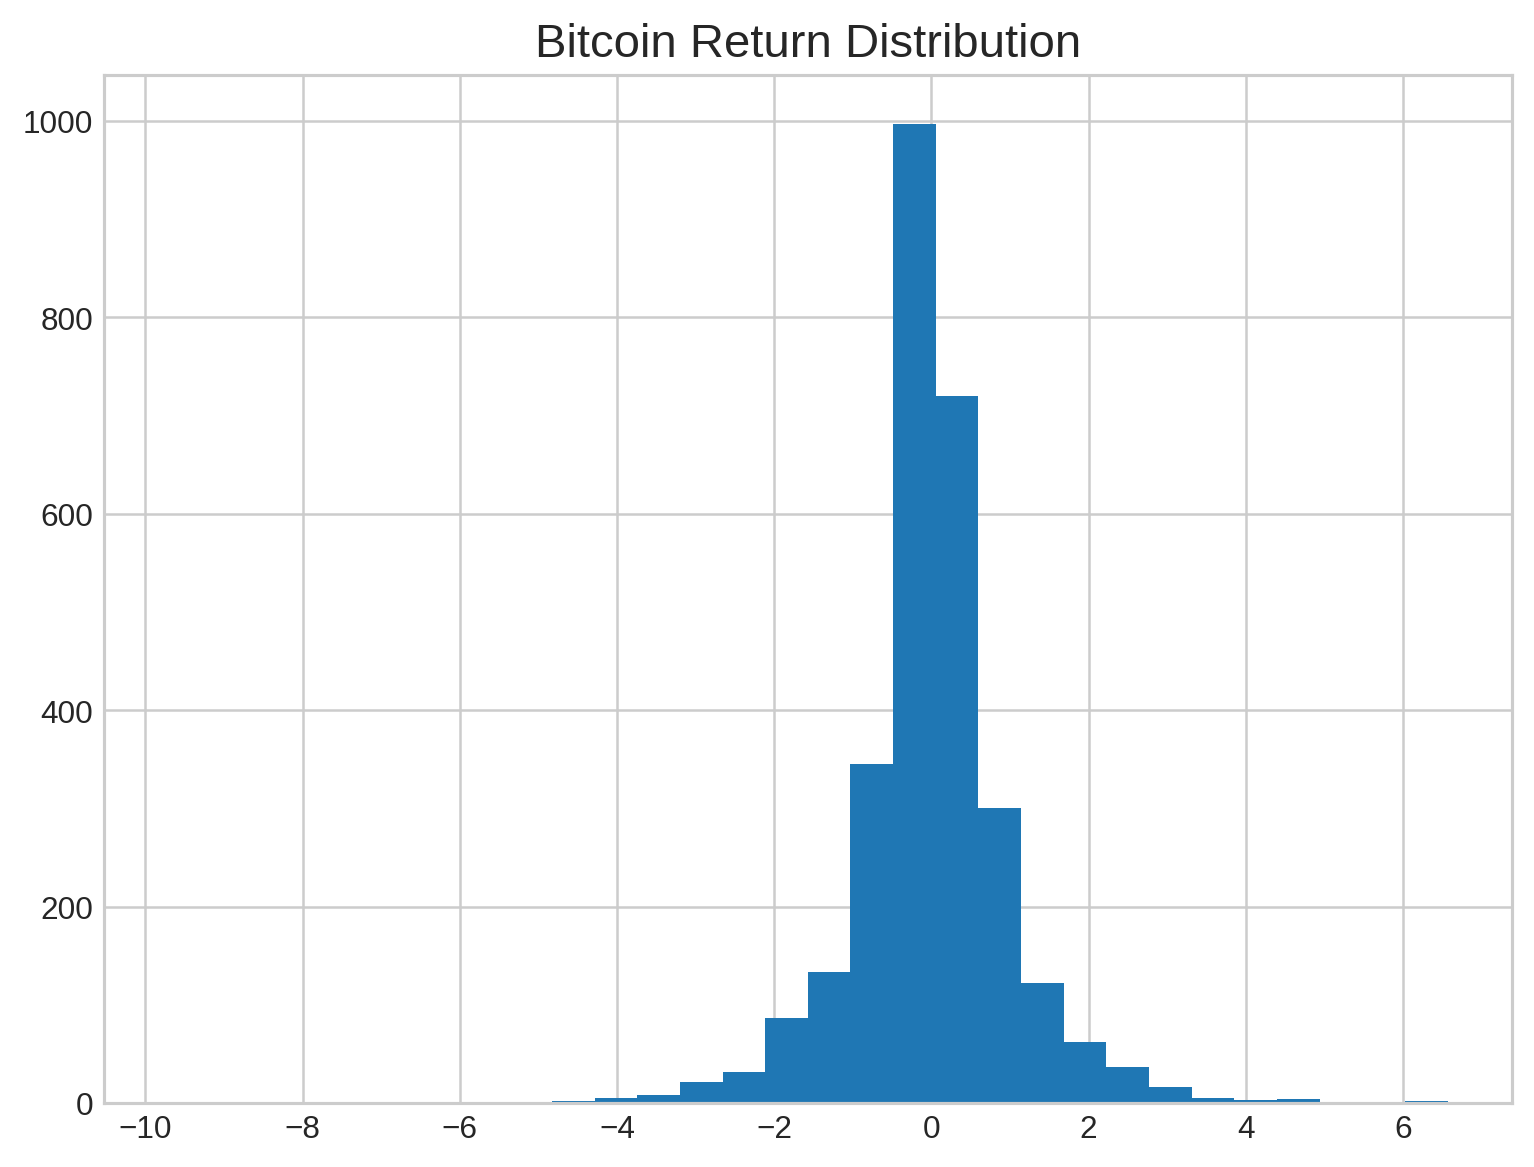

In [ ]:
z = lambda x: (x - x.mean()) / x.std()
plt.figure(figsize=(8,6))
plt.hist(z(stocks['bitcoin_data'].Return), bins=30)
plt.title('Bitcoin Return Distribution', fontSize=15)
plt.show()

**Implementation of Deep learning**

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.3 MB/s 


In [ ]:
files = os.listdir('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/stocks')
stocks = {}
for file in files:
    # Include only csv files
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

**BASELINE MODEL**

In [ ]:
def baseline_model(stock):
    '''
    \n\n
    Input: Series or Array
    Returns: Accuracy Score
    Function generates random numbers [0,1] and compares them with true values
    \n\n
    '''
    baseline_predictions = np.random.randint(0, 2, len(stock))
    accuracy = accuracy_score(binary(stock), baseline_predictions)
    
    return accuracy

In [ ]:
baseline_accuracy = baseline_model(stocks['bitcoin_data'].Return)
print('Baseline model accuracy: {:.1f}%'.format(baseline_accuracy * 100))

Baseline model accuracy: 51.3%


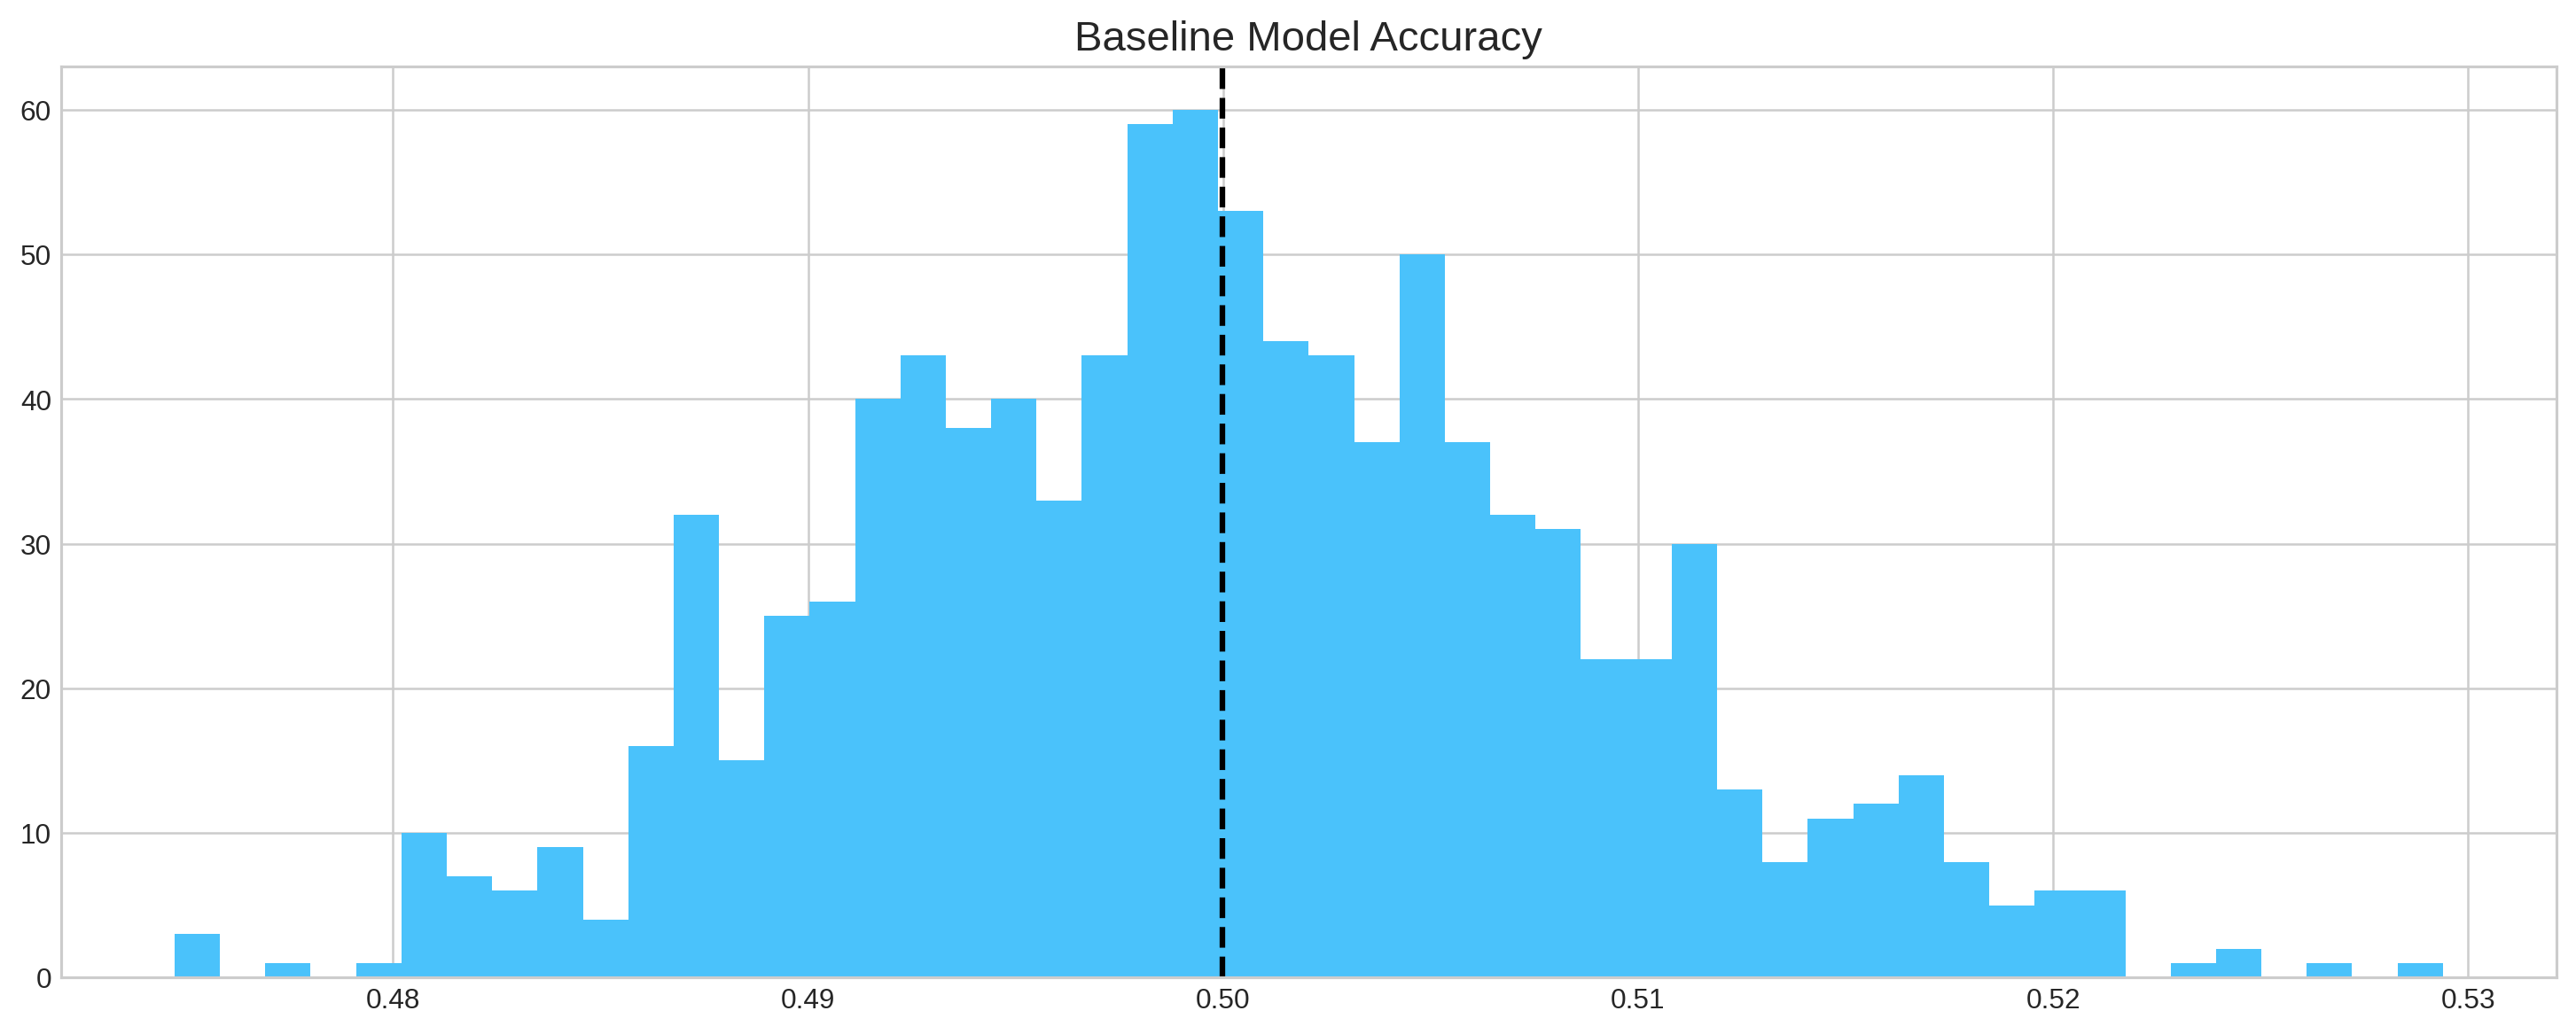

In [ ]:
base_preds = []
for i in range(1000):
    base_preds.append(baseline_model(stocks['bitcoin_data'].Return))
    
plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy', fontSize=15)
plt.axvline(np.array(base_preds).mean(), c='k', ls='--', lw=2)
plt.show()

In [ ]:
print('Bitcoin historical data contains {} entries'.format(stocks['bitcoin_data'].shape[0]))
stocks['bitcoin_data'][['Return']].head()

Bitcoin historical data contains 2909 entries


Return
Date              
2014-10-07   0.017
2014-10-08   0.050
2014-10-09   0.035
2014-10-10  -0.009
2014-10-11   0.003

**Train Test Split**

In [ ]:
n_steps = 21
scaled_bit = scale(stocks['bitcoin_data'], scale=(0,1))

X_train, \
y_train, \
X_test, \
y_test = split_sequences(              
    scaled_bit.to_numpy()[:-1], 
    stocks['bitcoin_data'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

**LSTM**

In [ ]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 100)           48000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 78,721
Trainable params: 78,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=[X_test, y_test], use_multiprocessing=True)

Epoch 1/100
73/73 [==============================] - 19s 200ms/step - loss: 0.0021 - mae: 0.0308 - val_loss: 0.0016 - val_mae: 0.0287
Epoch 2/100
73/73 [==============================] - 11s 150ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 3/100
73/73 [==============================] - 5s 72ms/step - loss: 0.0015 - mae: 0.0255 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 4/100
73/73 [==============================] - 5s 71ms/step - loss: 0.0015 - mae: 0.0255 - val_loss: 0.0015 - val_mae: 0.0277
Epoch 5/100
73/73 [==============================] - 5s 73ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 6/100
73/73 [==============================] - 5s 71ms/step - loss: 0.0015 - mae: 0.0251 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 7/100
73/73 [==============================] - 5s 72ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0020 - val_mae: 0.0345
Epoch 8/100
73/73 [==============================] - 9s 126ms/step - los

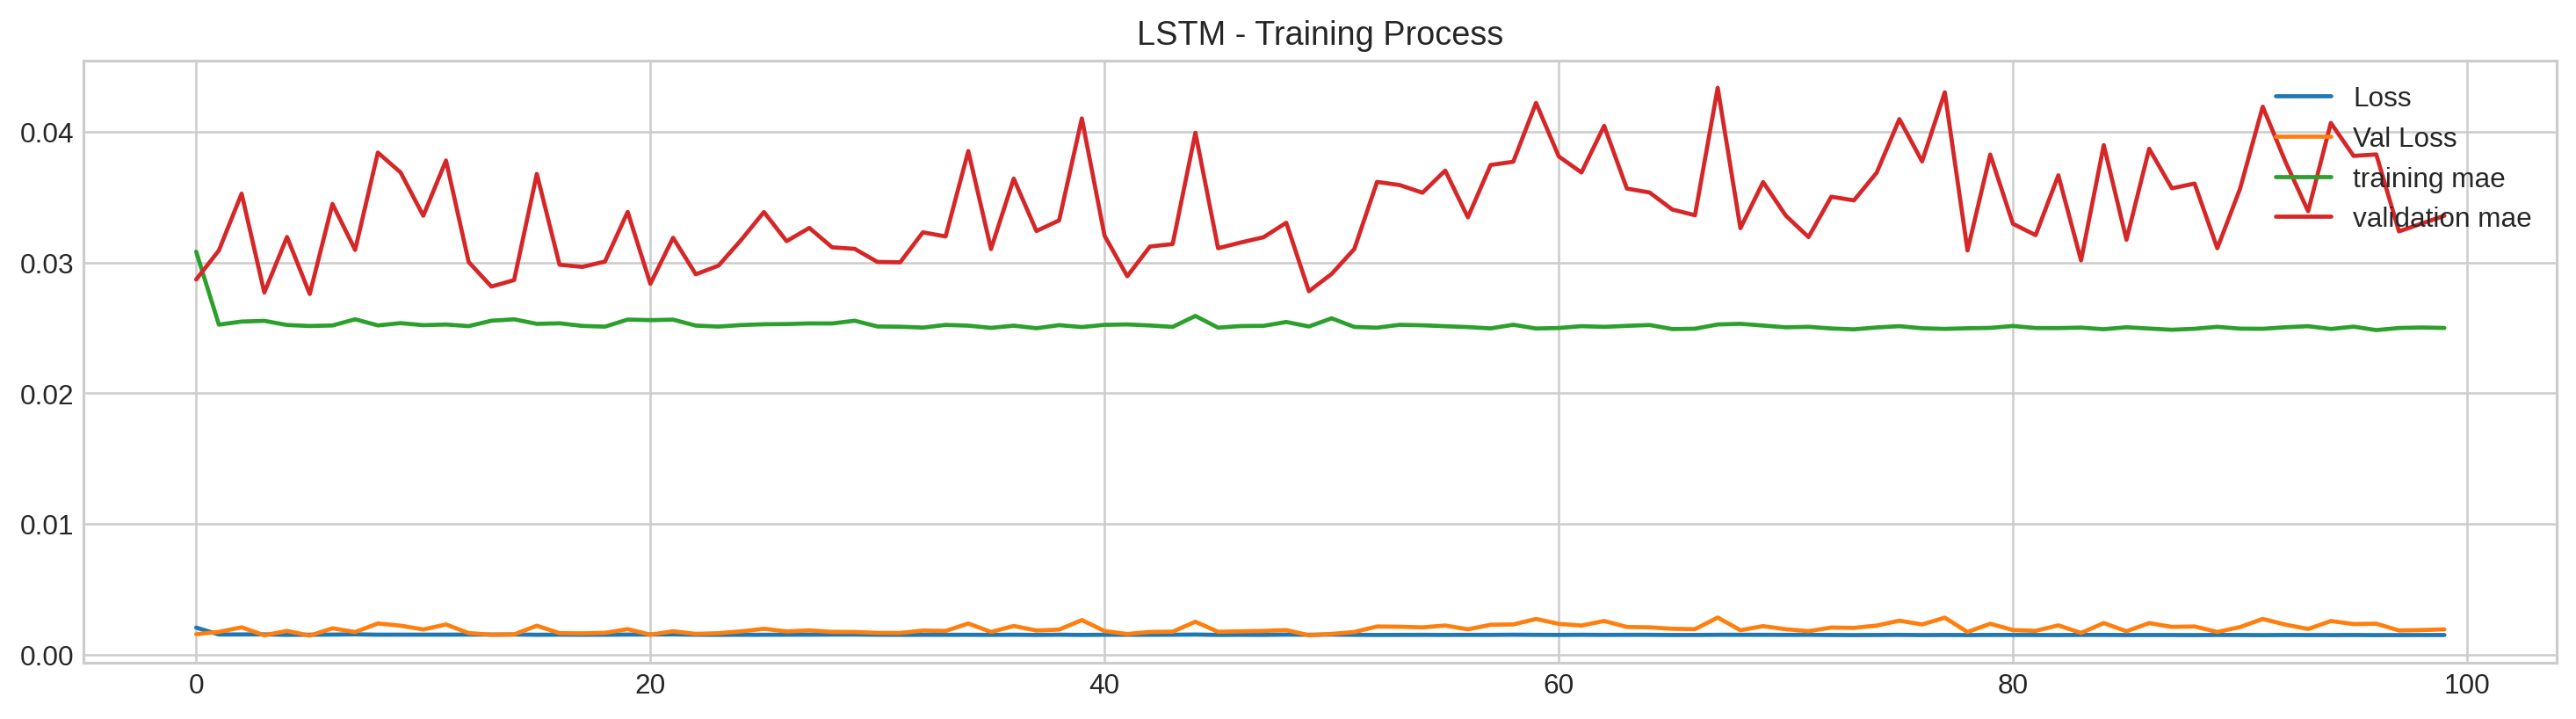

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')

plt.plot(model.history.history['mae'], label='training mae')
plt.plot(model.history.history['val_mae'], label='validation mae')
plt.legend(loc=1)
plt.title('LSTM - Training Process')
plt.show()

1/1 [==============================] - 0s 19ms/step


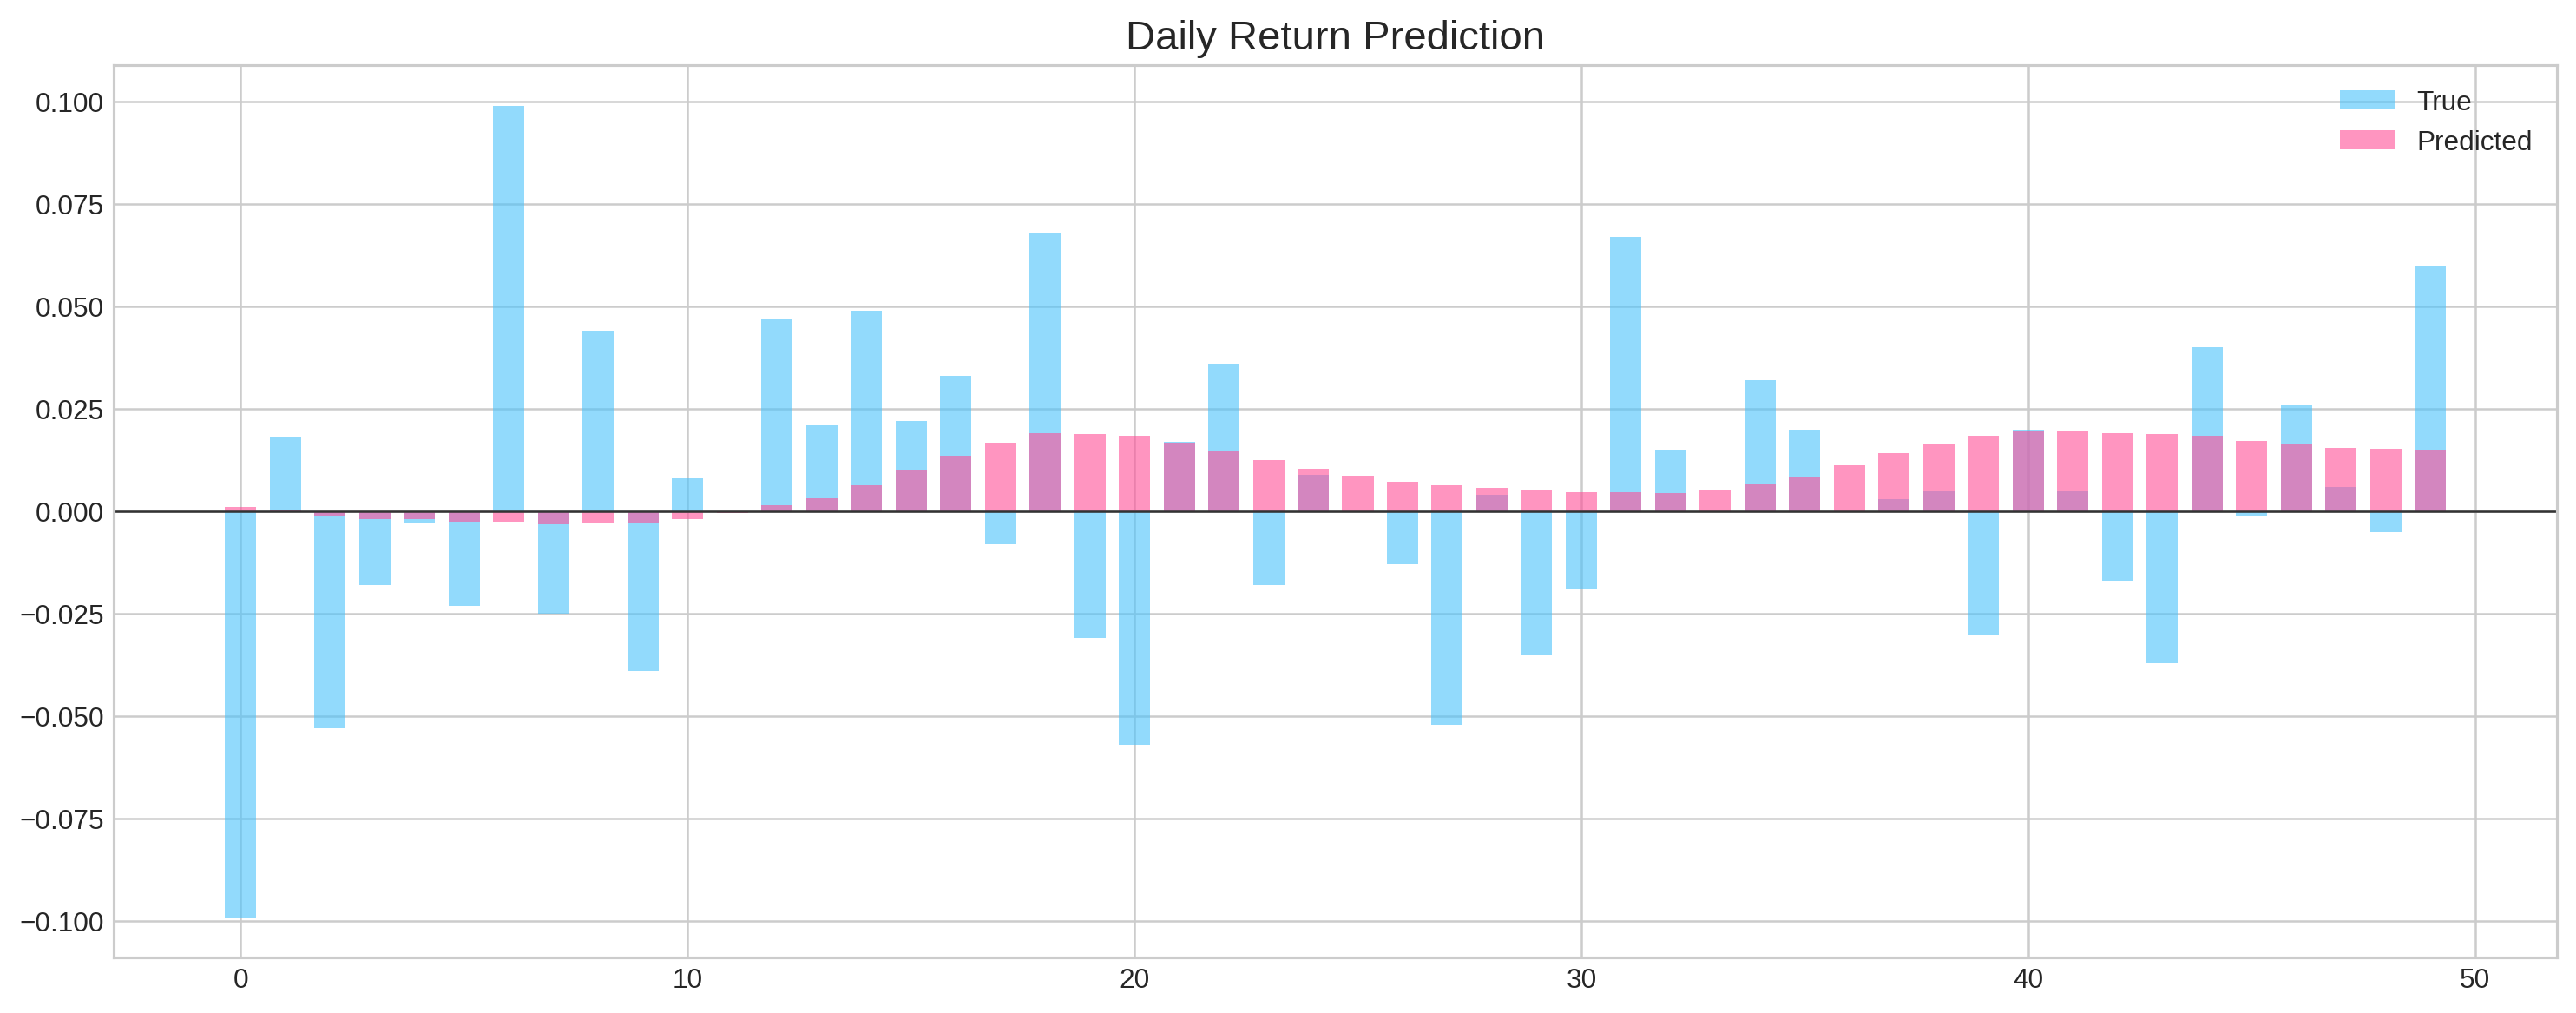

MSE: 0.0013409441447742524
Accuracy: 58%


In [ ]:
pred, y_true, y_pred = evaluation(
                    X_test, y_test, model, random=False, n_preds=50, 
                    show_graph=True)


**BiLSTM**

In [ ]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]
input_shape = n_steps, n_features

bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(input_shape))))
bilstm.add(LSTM(50, activation='relu', return_sequences=False))
bilstm.add(Dense(10))
bilstm.add(Dense(1))
bilstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
# bilstm.build(input_shape)
# bilstm.summary()

In [ ]:
bilstm.fit(X_train, y_train, epochs=100, verbose=1, validation_data=[X_test, y_test], use_multiprocessing=True)

Epoch 1/100
73/73 [==============================] - 11s 107ms/step - loss: 0.0017 - mae: 0.0281 - val_loss: 0.0015 - val_mae: 0.0285
Epoch 2/100
73/73 [==============================] - 8s 112ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 3/100
73/73 [==============================] - 7s 102ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 4/100
73/73 [==============================] - 7s 100ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0014 - val_mae: 0.0274
Epoch 5/100
73/73 [==============================] - 7s 101ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0016 - val_mae: 0.0296
Epoch 6/100
73/73 [==============================] - 7s 100ms/step - loss: 0.0015 - mae: 0.0251 - val_loss: 0.0017 - val_mae: 0.0305
Epoch 7/100
73/73 [==============================] - 7s 98ms/step - loss: 0.0015 - mae: 0.0253 - val_loss: 0.0015 - val_mae: 0.0279
Epoch 8/100
73/73 [==============================] - 7s 99ms/step - l

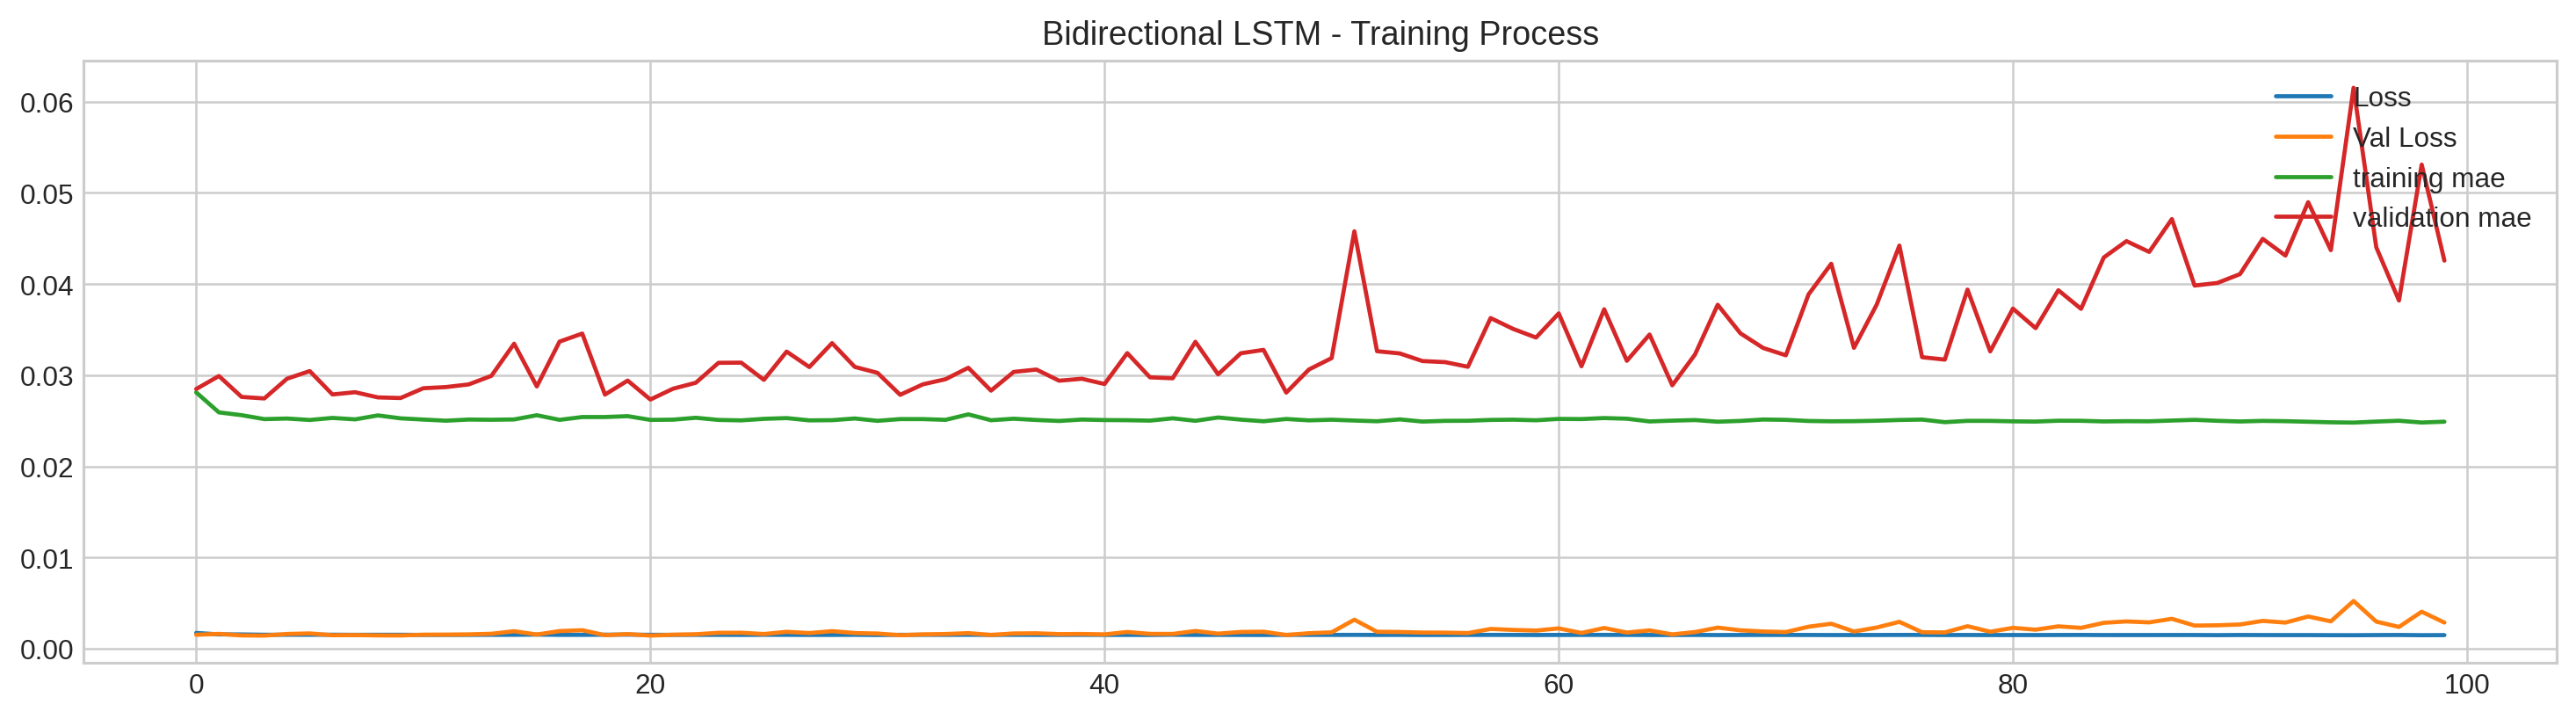

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(bilstm.history.history['loss'], label='Loss')
plt.plot(bilstm.history.history['val_loss'], label='Val Loss')

plt.plot(bilstm.history.history['mae'], label='training mae')
plt.plot(bilstm.history.history['val_mae'], label='validation mae')
plt.legend(loc=1)
plt.title('Bidirectional LSTM - Training Process')
plt.show()

1/1 [==============================] - 0s 23ms/step


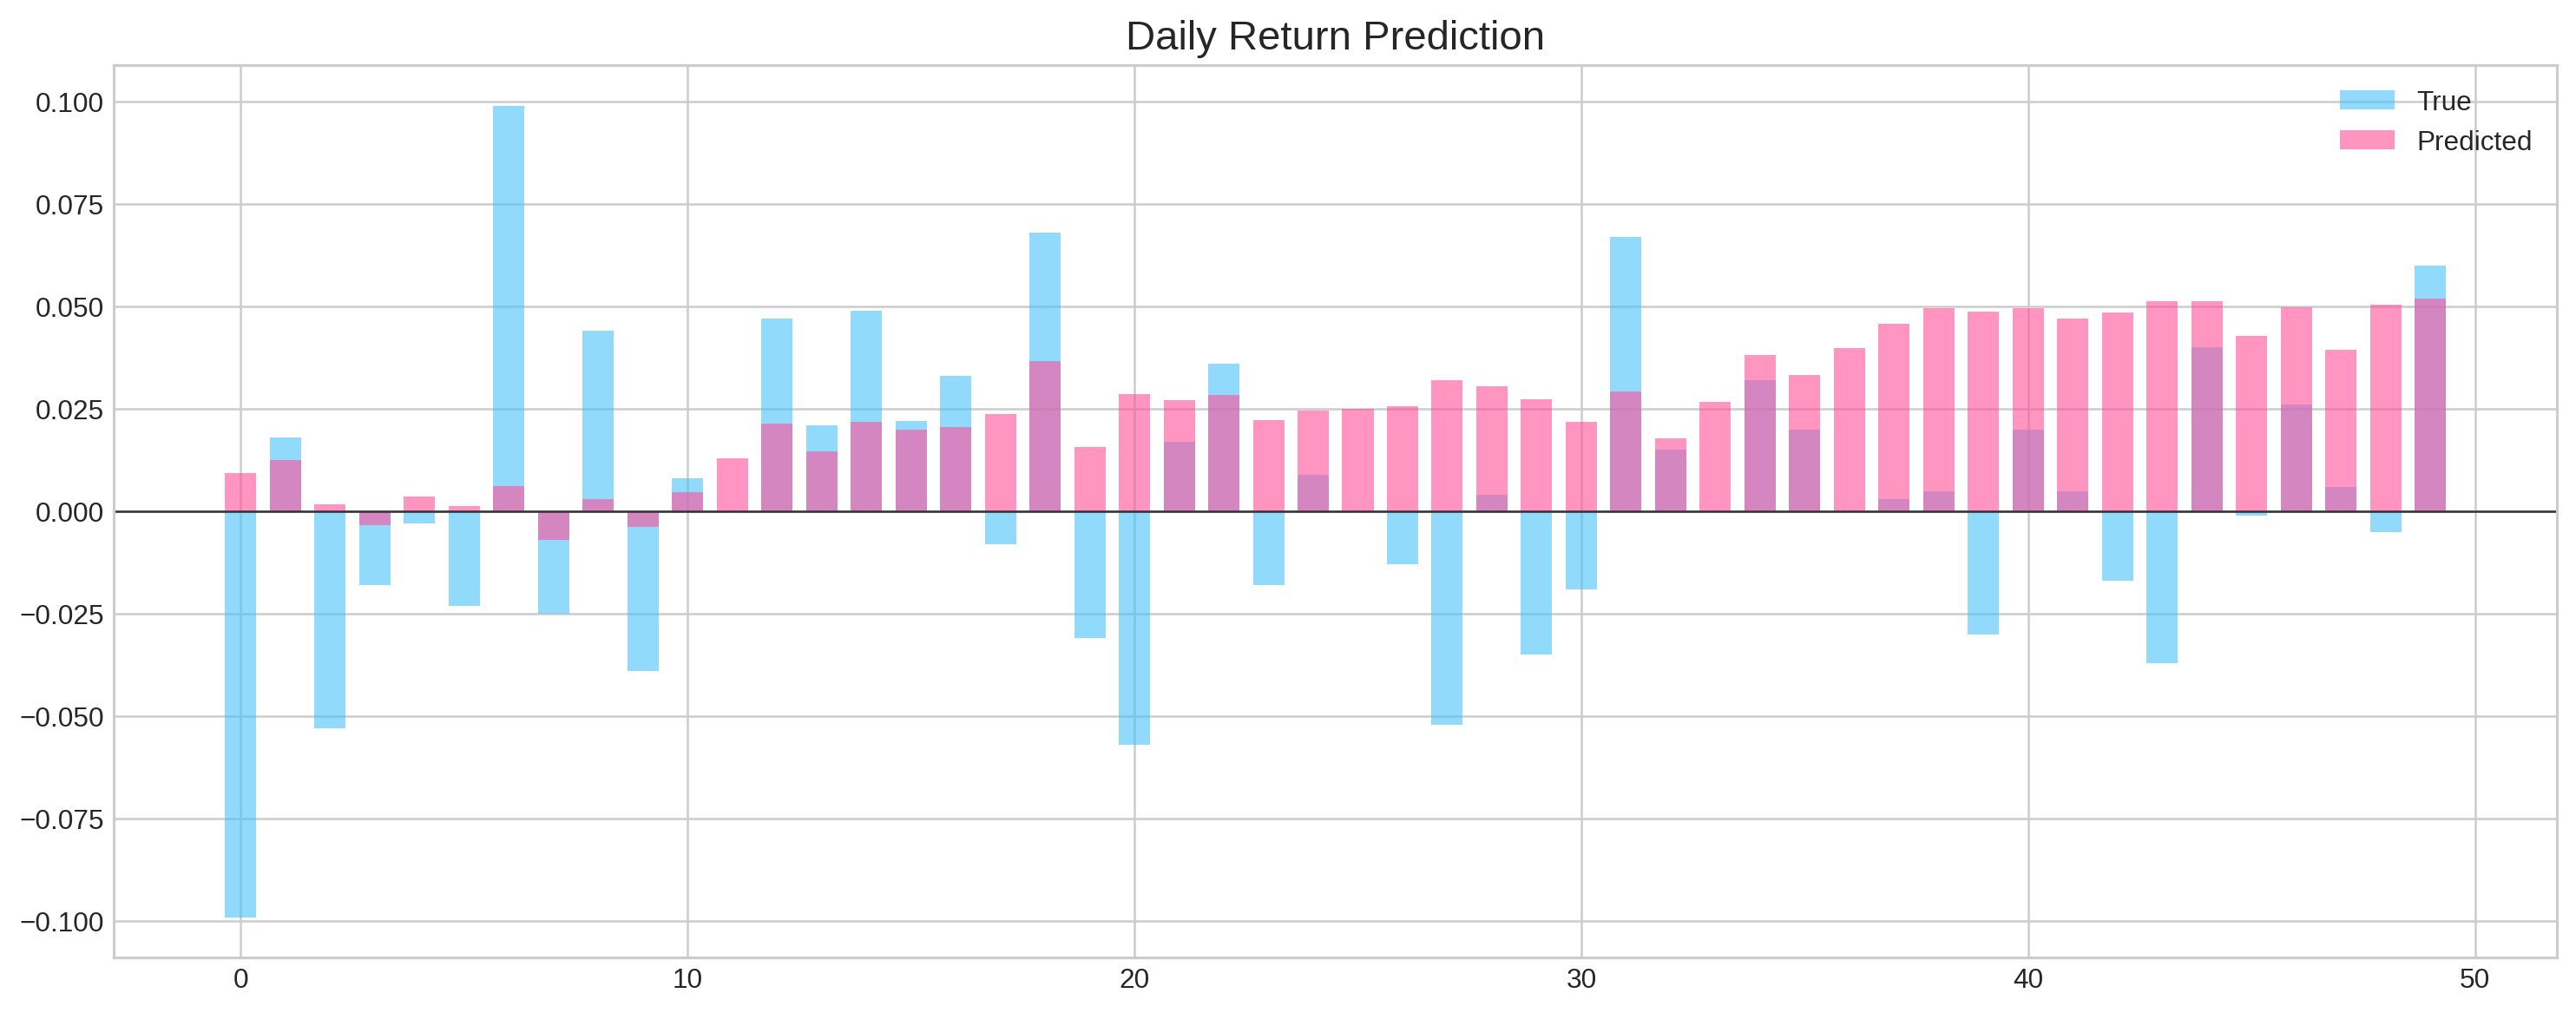

MSE: 0.0018752586893330378
Accuracy: 58%


In [ ]:
pred, y_true, y_pred = evaluation(
                    X_test, y_test, bilstm, random=False, n_preds=50, 
                    show_graph=True)


**BiGRU**

In [ ]:

keras.backend.clear_session()

bigru = Sequential()

bigru.add(Bidirectional(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features))))
bigru.add(GRU(30, activation='relu', return_sequences=False))
bigru.add(Dense(10))
bigru.add(Dense(1))
bigru.compile(optimizer='adam', loss='mse', metrics=['mae'])
# bigru.summary()

In [ ]:
bigru.fit(X_train, y_train, epochs=50, verbose=1, validation_data=[X_test, y_test], use_multiprocessing=True)

Epoch 1/50
233/233 [==============================] - 32s 139ms/step - loss: 0.0026 - mae: 0.0321 - val_loss: 0.0033 - val_mae: 0.0394
Epoch 2/50
233/233 [==============================] - 32s 139ms/step - loss: 0.0026 - mae: 0.0322 - val_loss: 0.0034 - val_mae: 0.0404
Epoch 3/50
233/233 [==============================] - 30s 130ms/step - loss: 0.0026 - mae: 0.0321 - val_loss: 0.0033 - val_mae: 0.0396
Epoch 4/50
233/233 [==============================] - 30s 130ms/step - loss: 0.0026 - mae: 0.0322 - val_loss: 0.0033 - val_mae: 0.0389
Epoch 5/50
233/233 [==============================] - 30s 131ms/step - loss: 0.0026 - mae: 0.0319 - val_loss: 0.0033 - val_mae: 0.0393
Epoch 6/50
233/233 [==============================] - 30s 129ms/step - loss: 0.0026 - mae: 0.0320 - val_loss: 0.0033 - val_mae: 0.0390
Epoch 7/50
233/233 [==============================] - 30s 127ms/step - loss: 0.0026 - mae: 0.0319 - val_loss: 0.0033 - val_mae: 0.0391
Epoch 8/50
233/233 [==============================] - 3

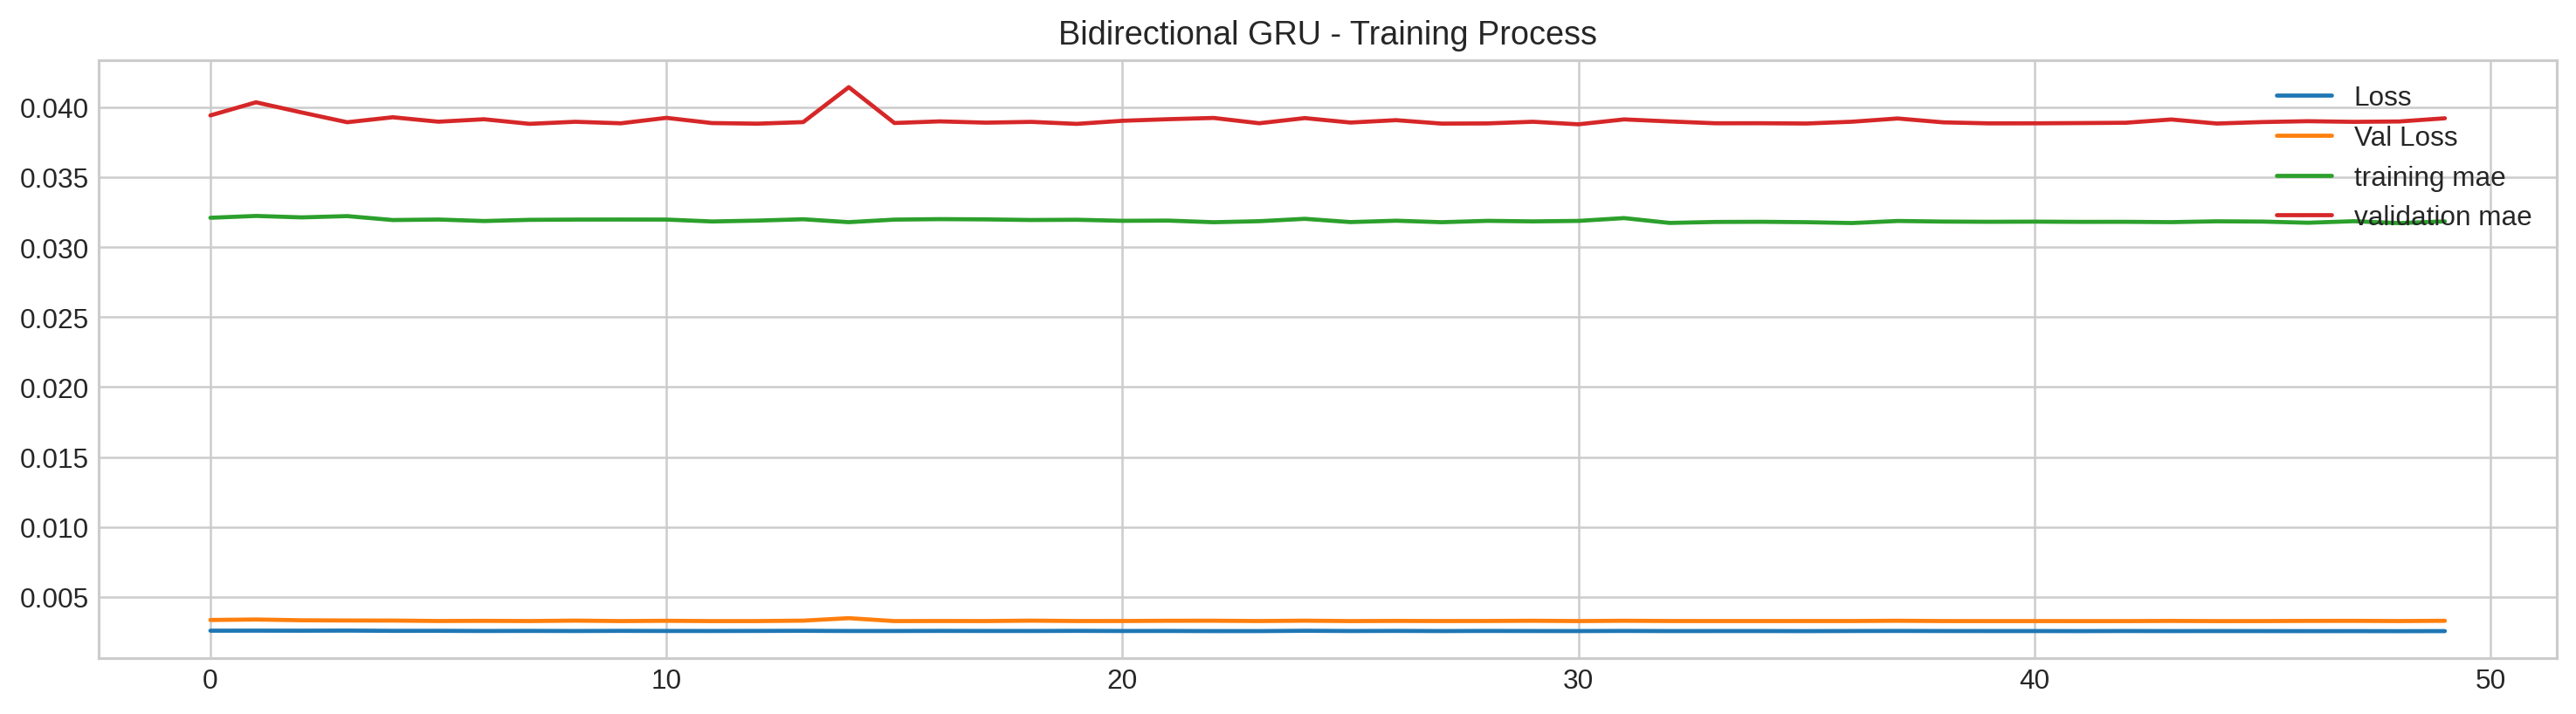

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(bigru.history.history['loss'], label='Loss')
plt.plot(bigru.history.history['val_loss'], label='Val Loss')

plt.plot(bigru.history.history['mae'], label='training mae')
plt.plot(bigru.history.history['val_mae'], label='validation mae')
plt.legend(loc=1)
plt.title('Bidirectional GRU - Training Process')
plt.show()

1/1 [==============================] - 0s 23ms/step


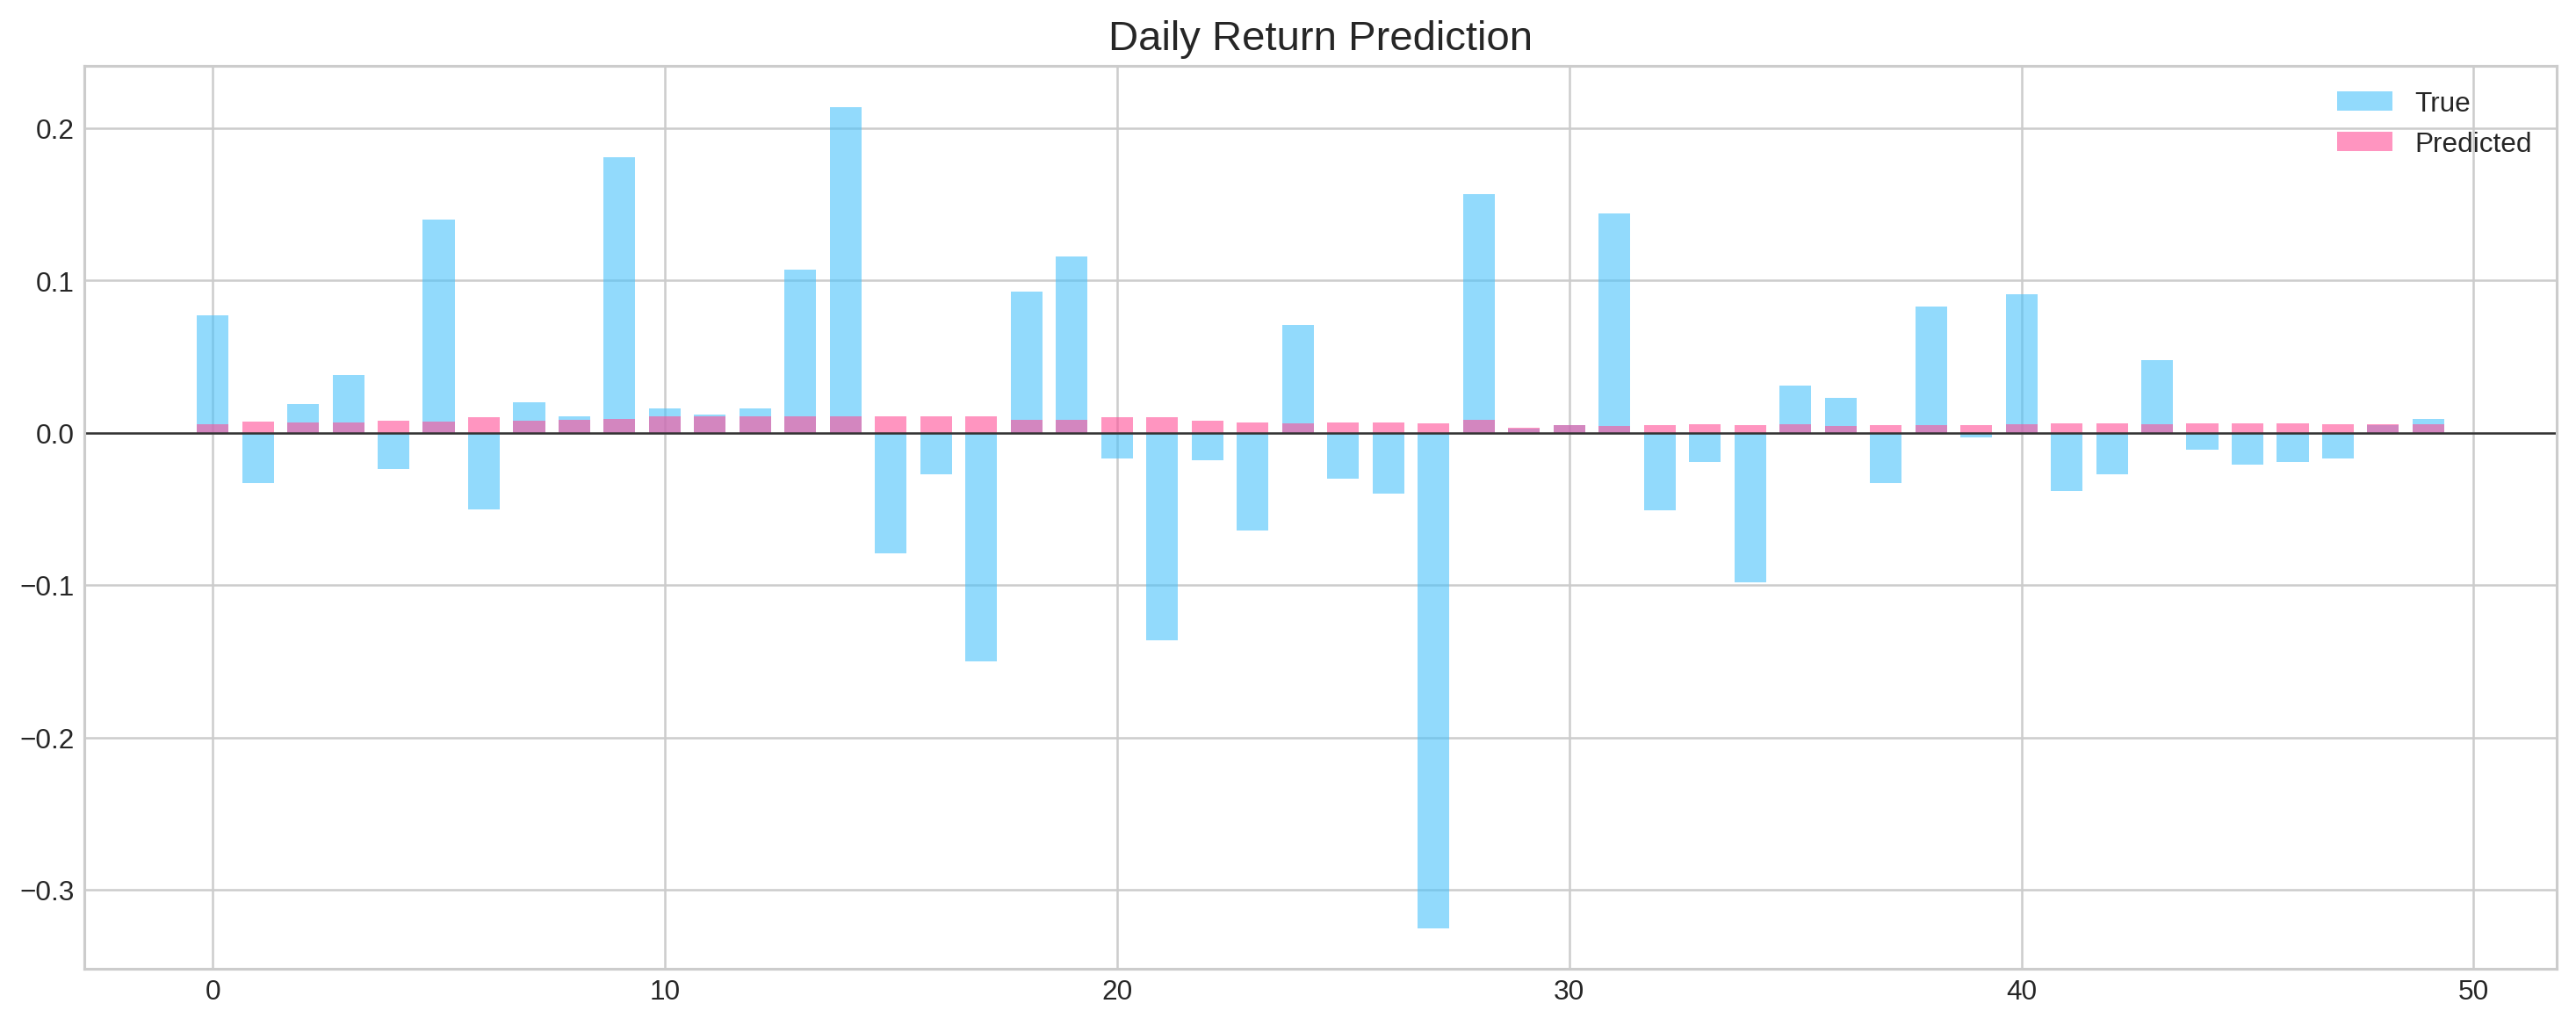

MSE: 0.007769626210288094
Accuracy: 52%


In [ ]:
pred, y_true, y_pred = evaluation(
                    X_test, y_test, bigru, random=False, n_preds=50, 
                    show_graph=True)


**CNN**

In [ ]:
keras.backend.clear_session()
cnn = Sequential()
cnn.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(5, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 20)            780       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 20)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,791
Trainable params: 1,791
Non-trainable params: 0
______________________________________________________

In [ ]:
cnn.fit(X_train, y_train, epochs=100, verbose=1, validation_data=[X_test, y_test], use_multiprocessing=True)


Epoch 1/100
73/73 [==============================] - 6s 6ms/step - loss: 0.0022 - mae: 0.0300 - val_loss: 0.0025 - val_mae: 0.0362
Epoch 2/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0251 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 3/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0015 - val_mae: 0.0281
Epoch 4/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0014 - val_mae: 0.0274
Epoch 5/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0249 - val_loss: 0.0014 - val_mae: 0.0274
Epoch 6/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0014 - val_mae: 0.0273
Epoch 7/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0014 - val_mae: 0.0274
Epoch 8/100
73/73 [==============================] - 0s 4ms/step - loss: 0.0015 - m

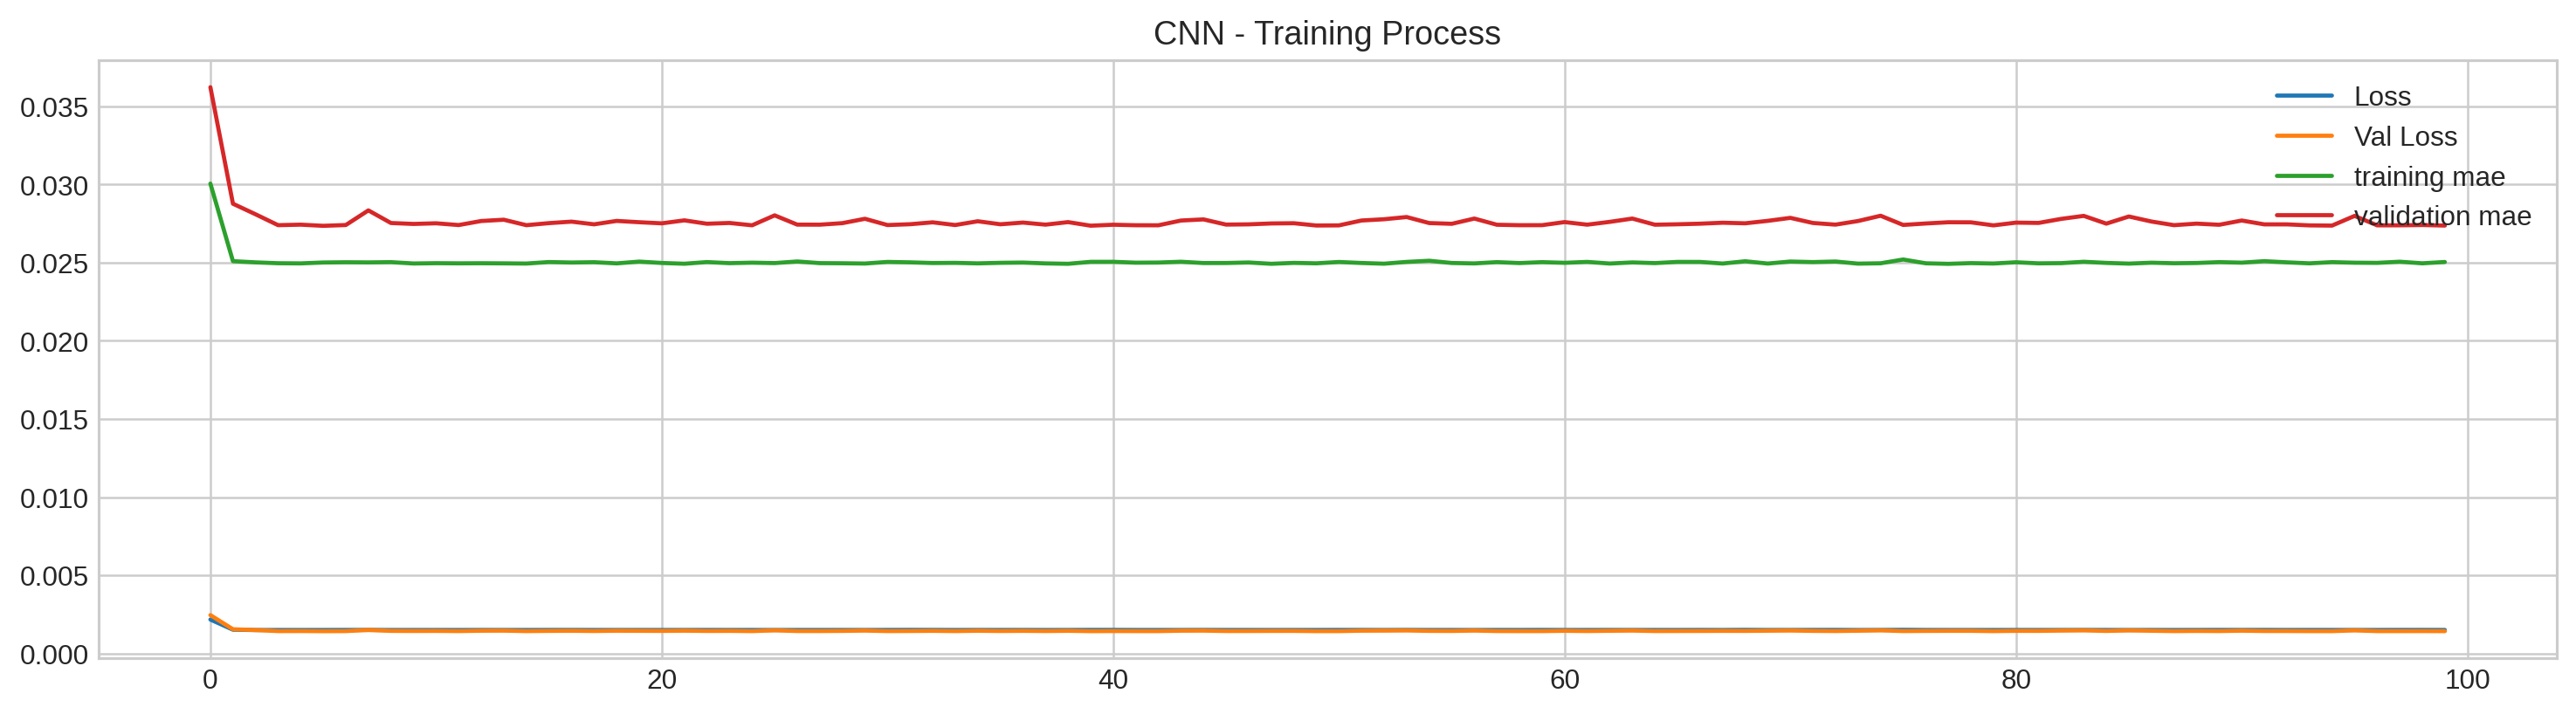

In [ ]:

plt.figure(figsize=(16,4))
plt.plot(cnn.history.history['loss'], label='Loss')
plt.plot(cnn.history.history['val_loss'], label='Val Loss')

plt.plot(cnn.history.history['mae'], label='training mae')
plt.plot(cnn.history.history['val_mae'], label='validation mae')
plt.legend(loc=1)
plt.title('CNN - Training Process')
plt.show()

1/1 [==============================] - 0s 15ms/step


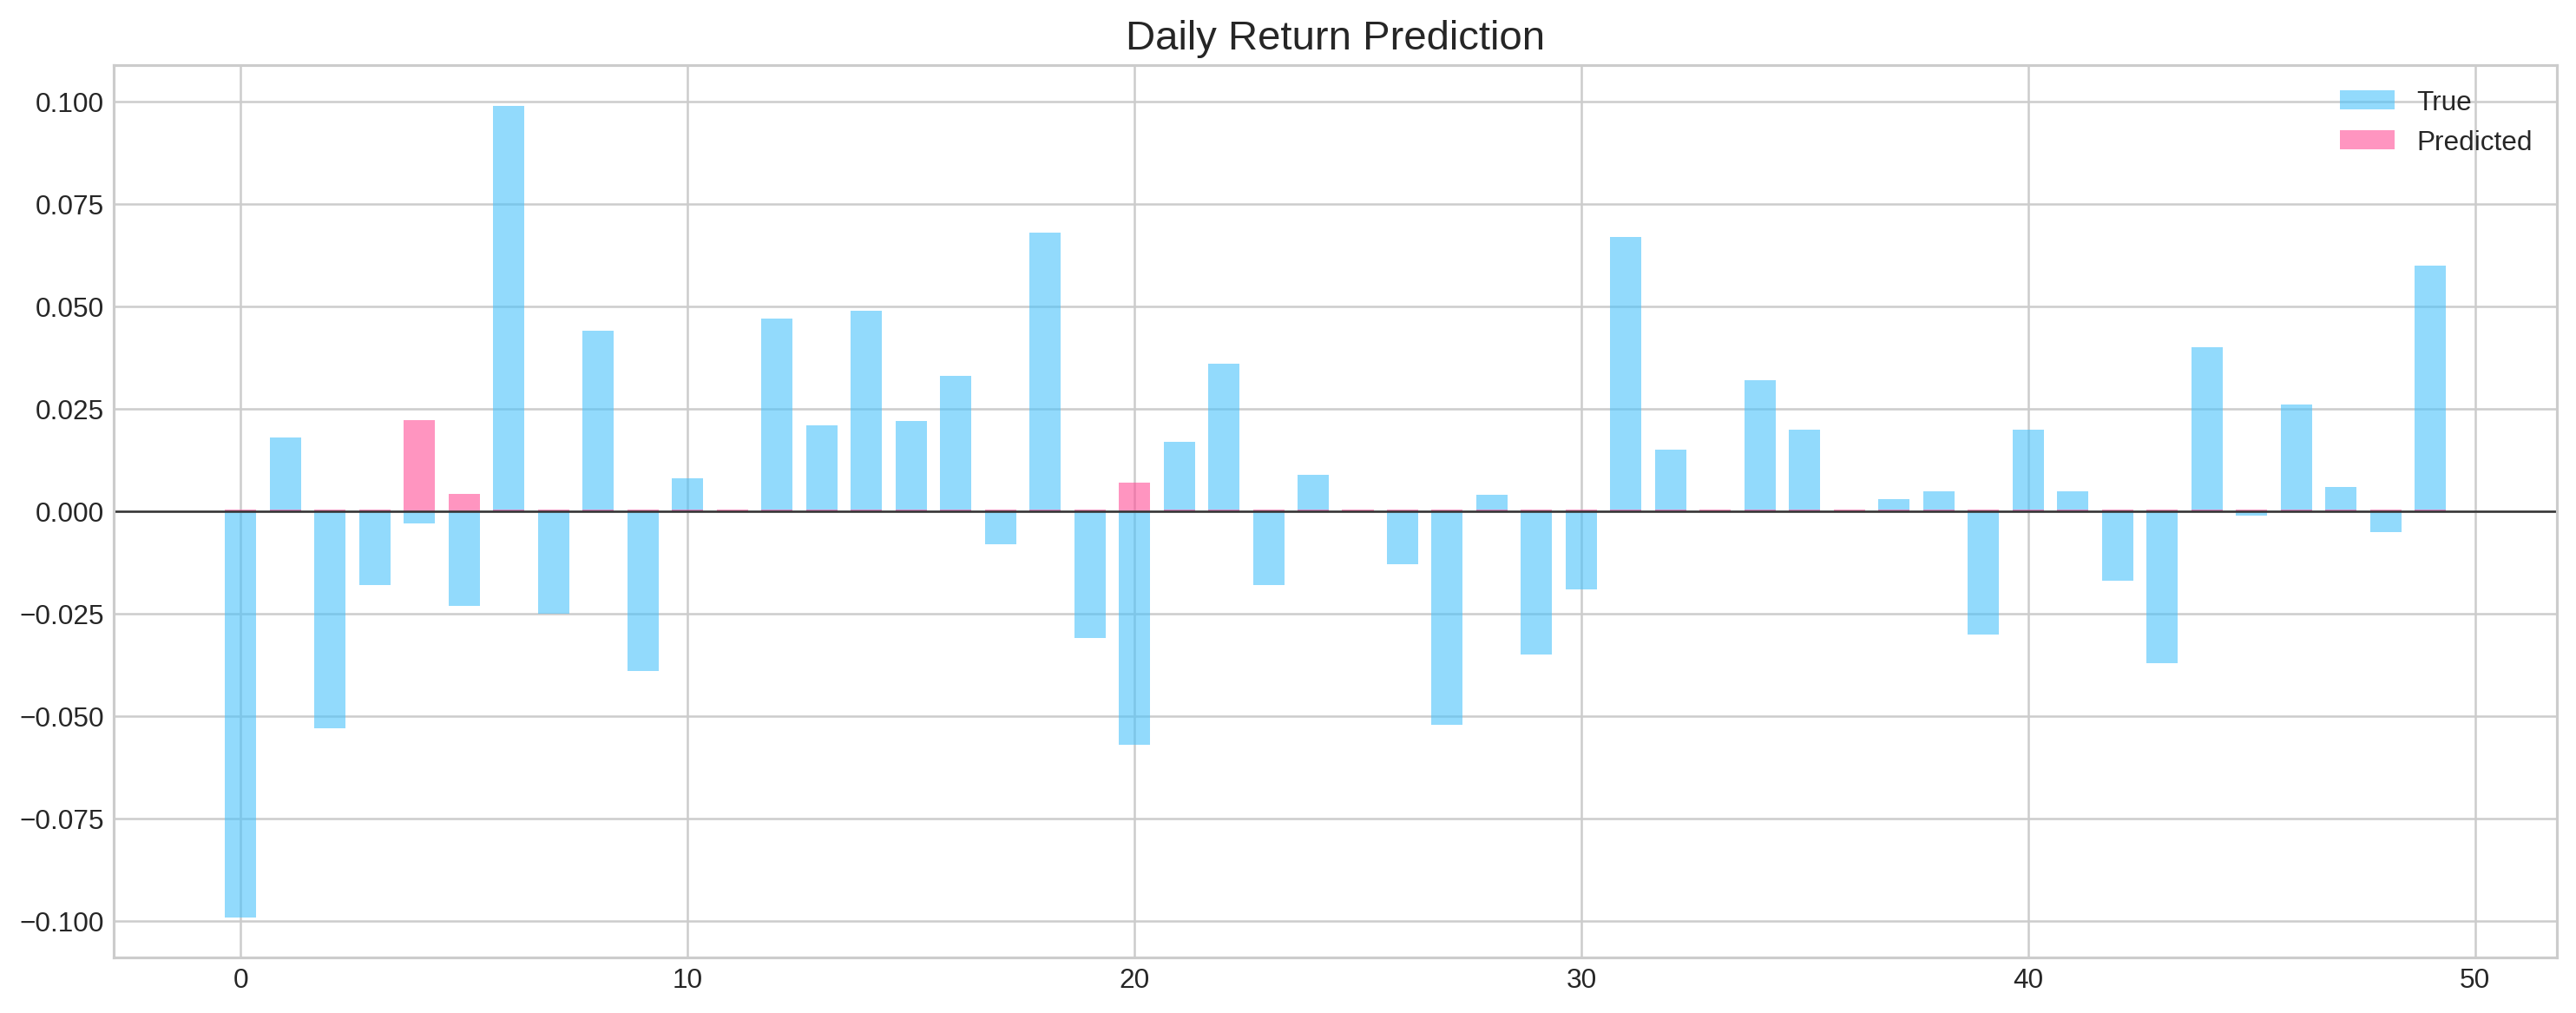

MSE: 0.0013257302247408201
Accuracy: 52%


In [ ]:
pred, y_true, y_pred = evaluation(
                    X_test, y_test, cnn, random=False, n_preds=50, 
                    show_graph=True)

Number of Trades: 59
Time Frame: 875 days
Profit: $-15000.00 | -100.0%


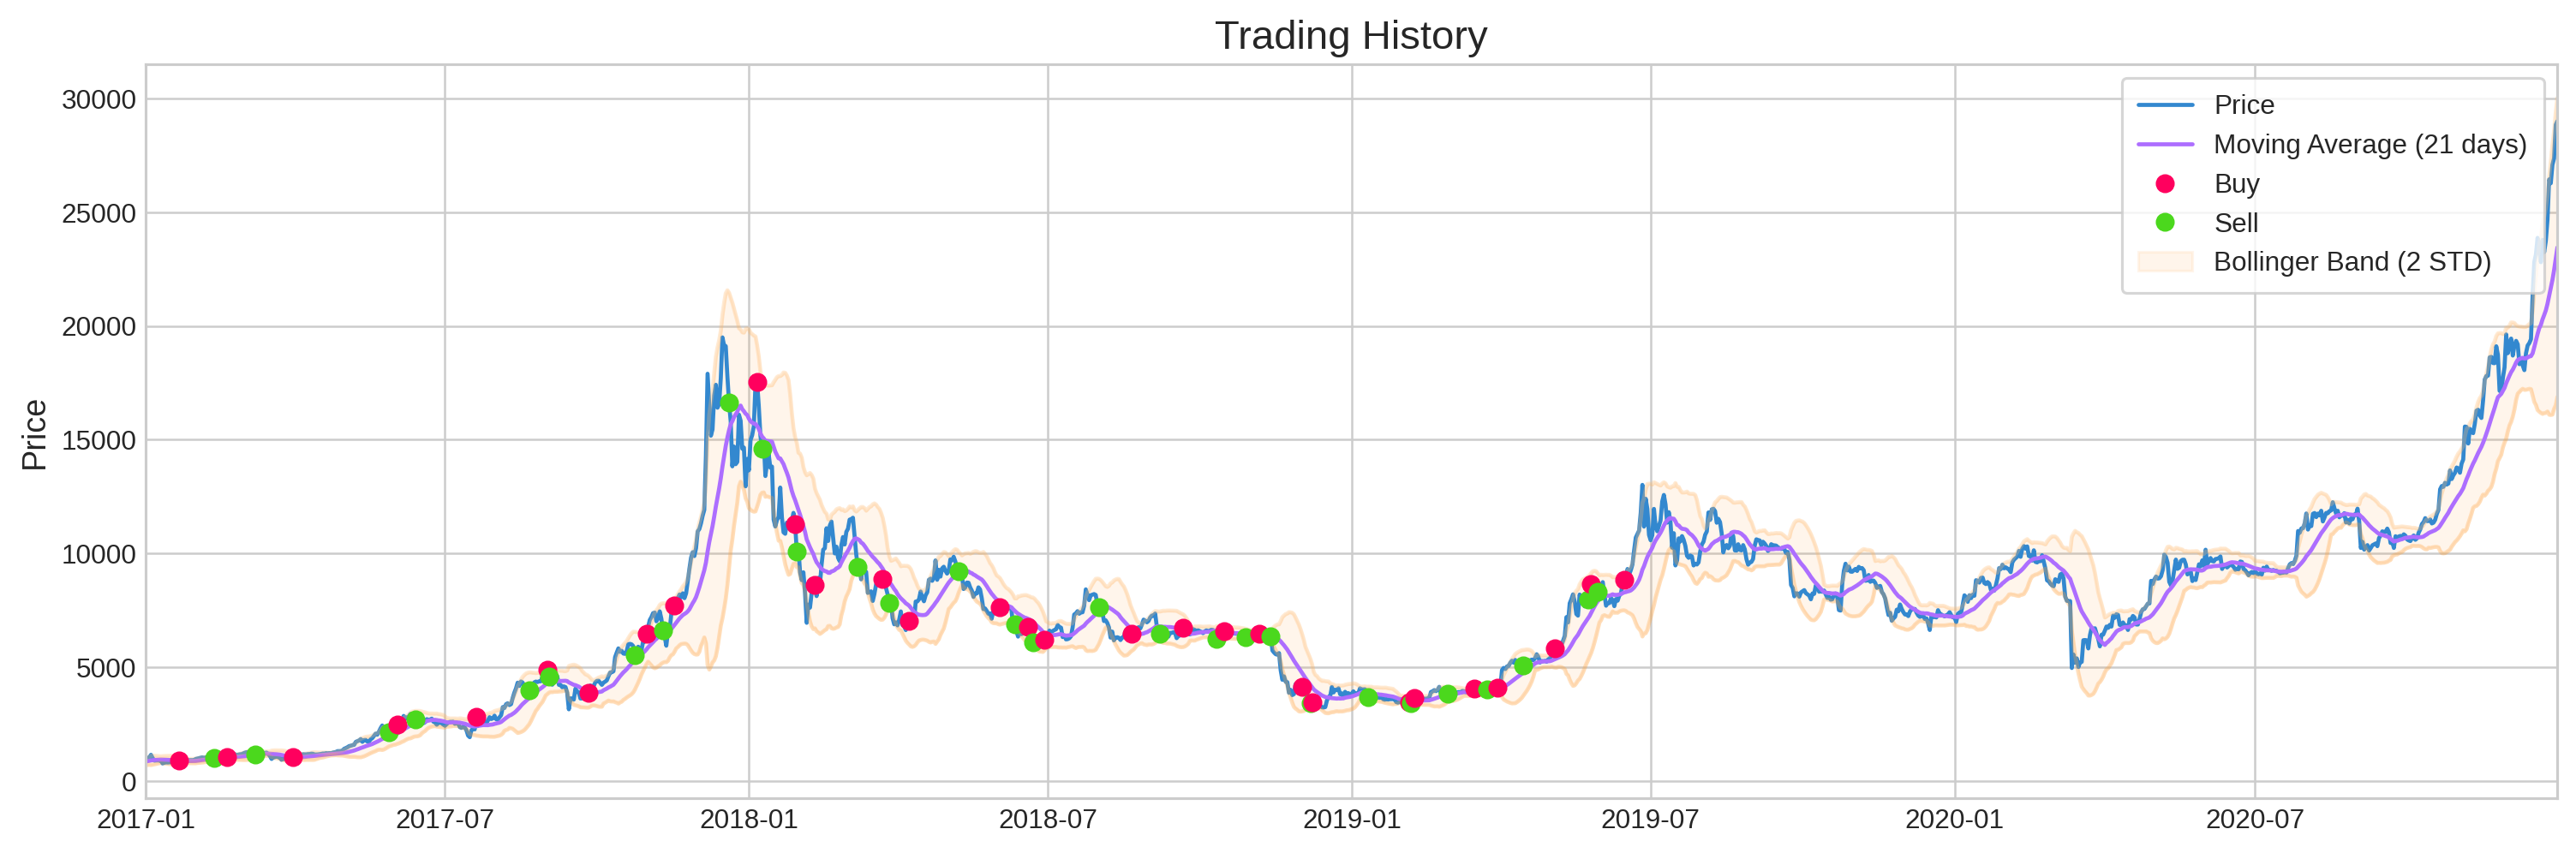

In [ ]:
profit, trades = macd_trading(stocks['bitcoin_data'].loc['2017':'2020'])

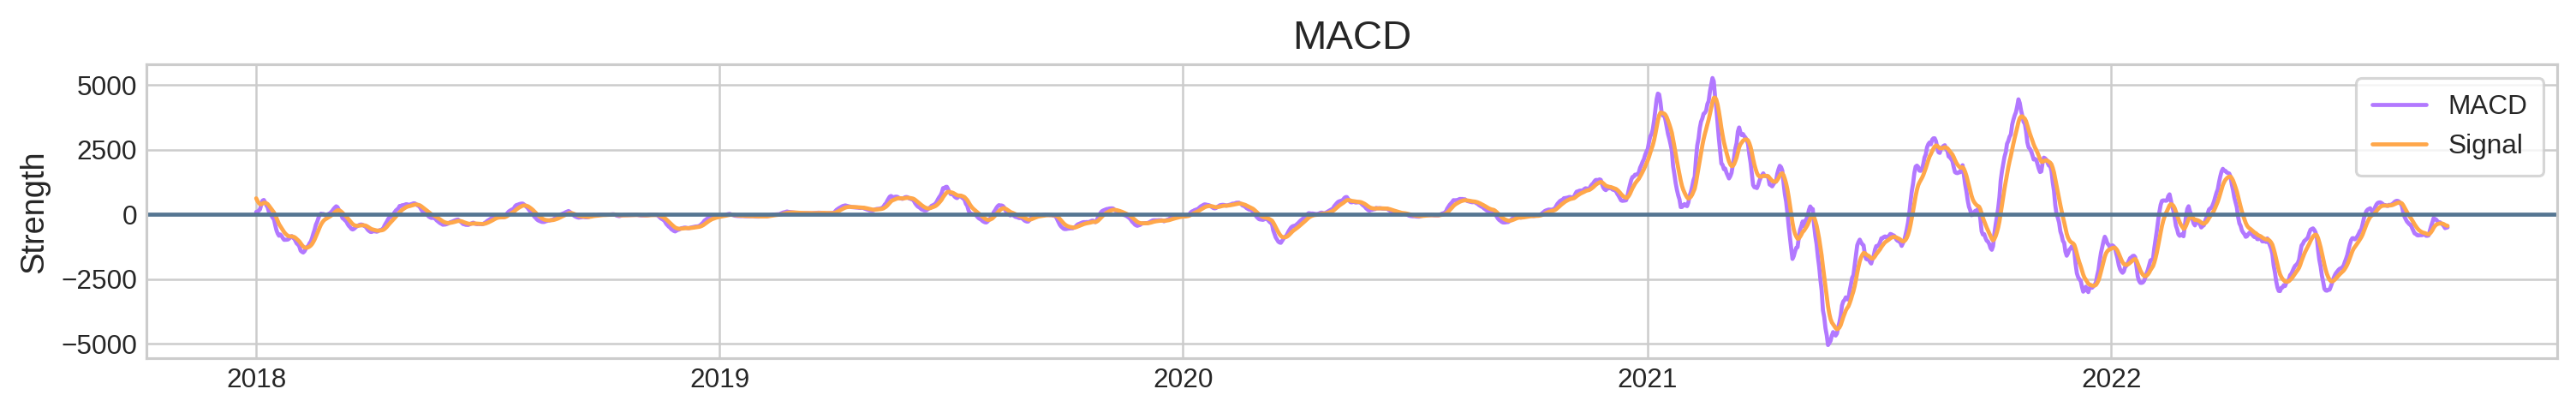

In [ ]:
mmacd(stocks['bitcoin_data'].loc['2018':'2022'])

Number of Trades: 1
Time Frame: 0 days
Profit: $-5000.00 | -100.0%


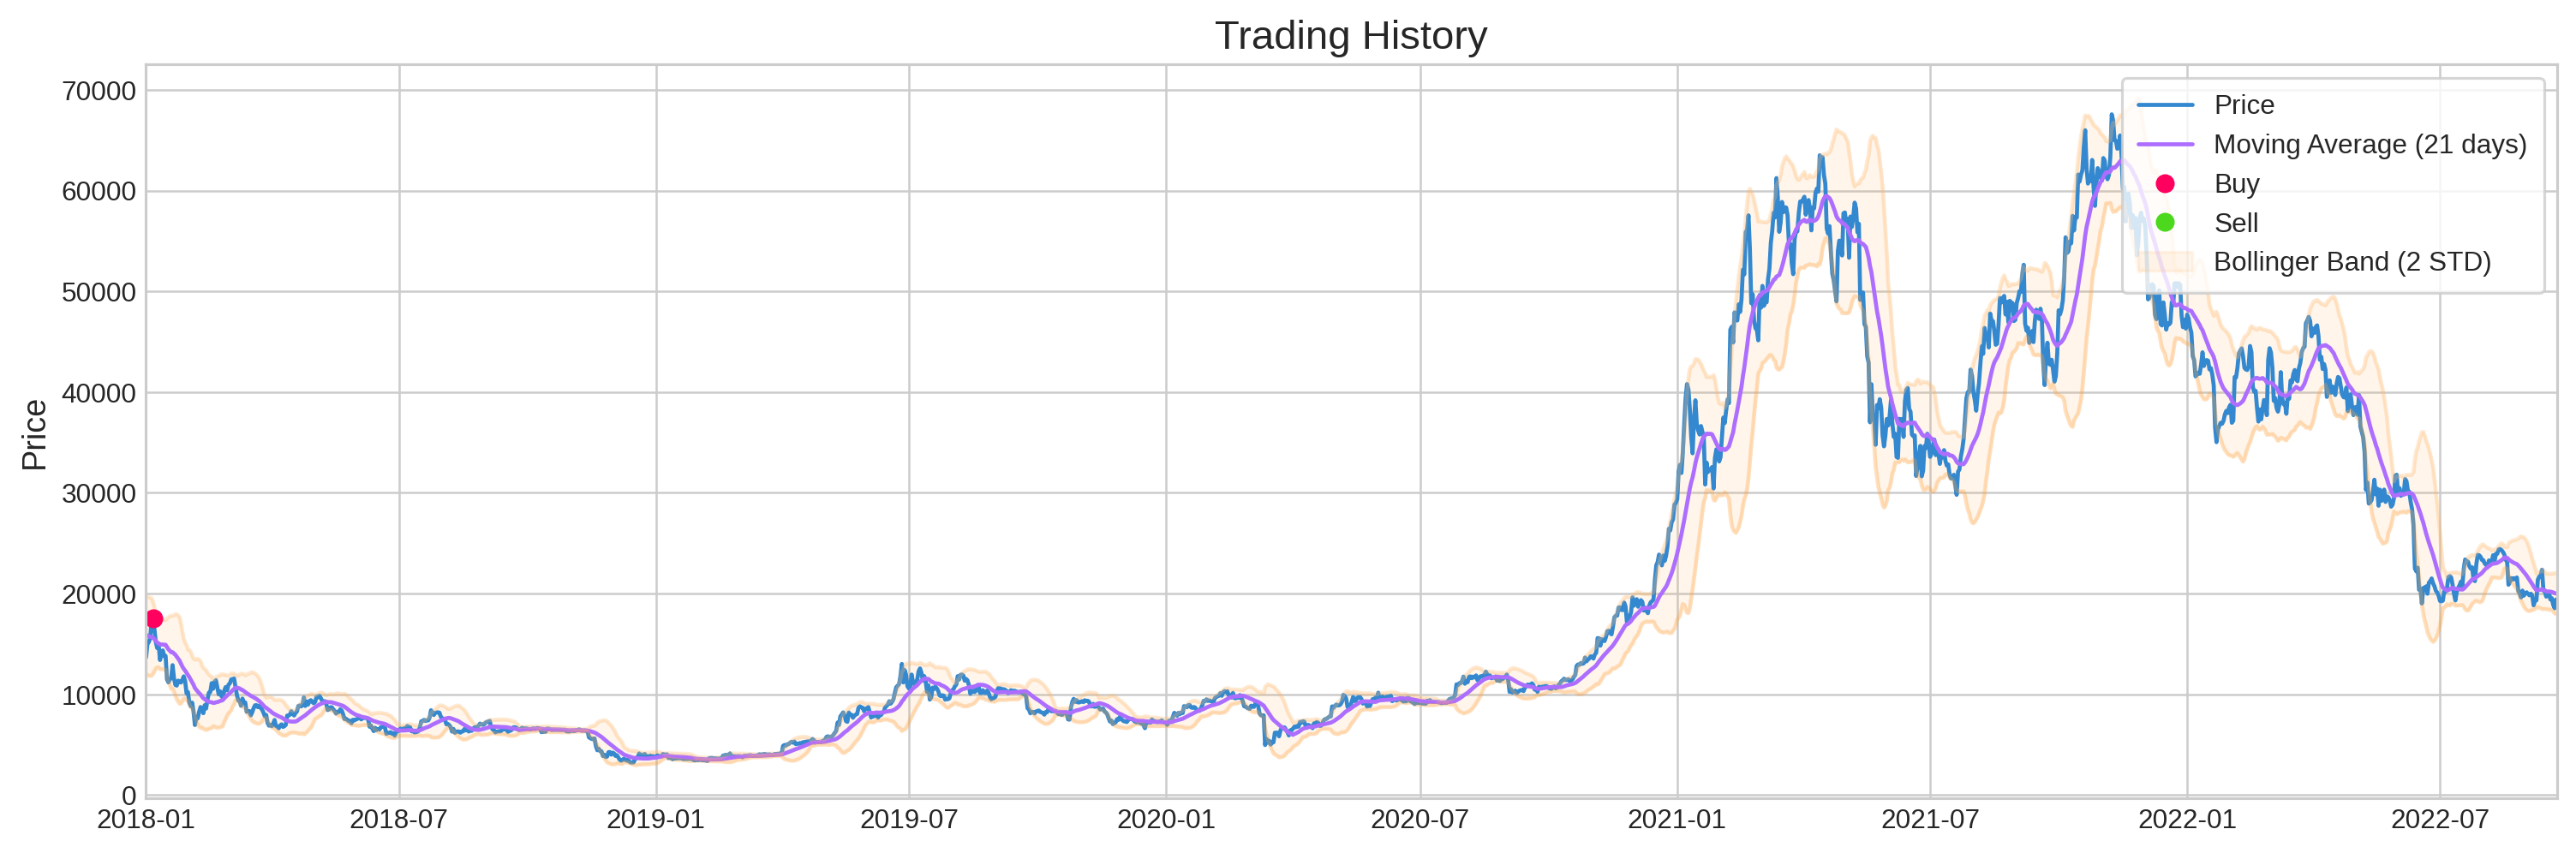

Number of Trades: 73
Time Frame: 1079 days
Profit: $-5000.00 | -100.0%


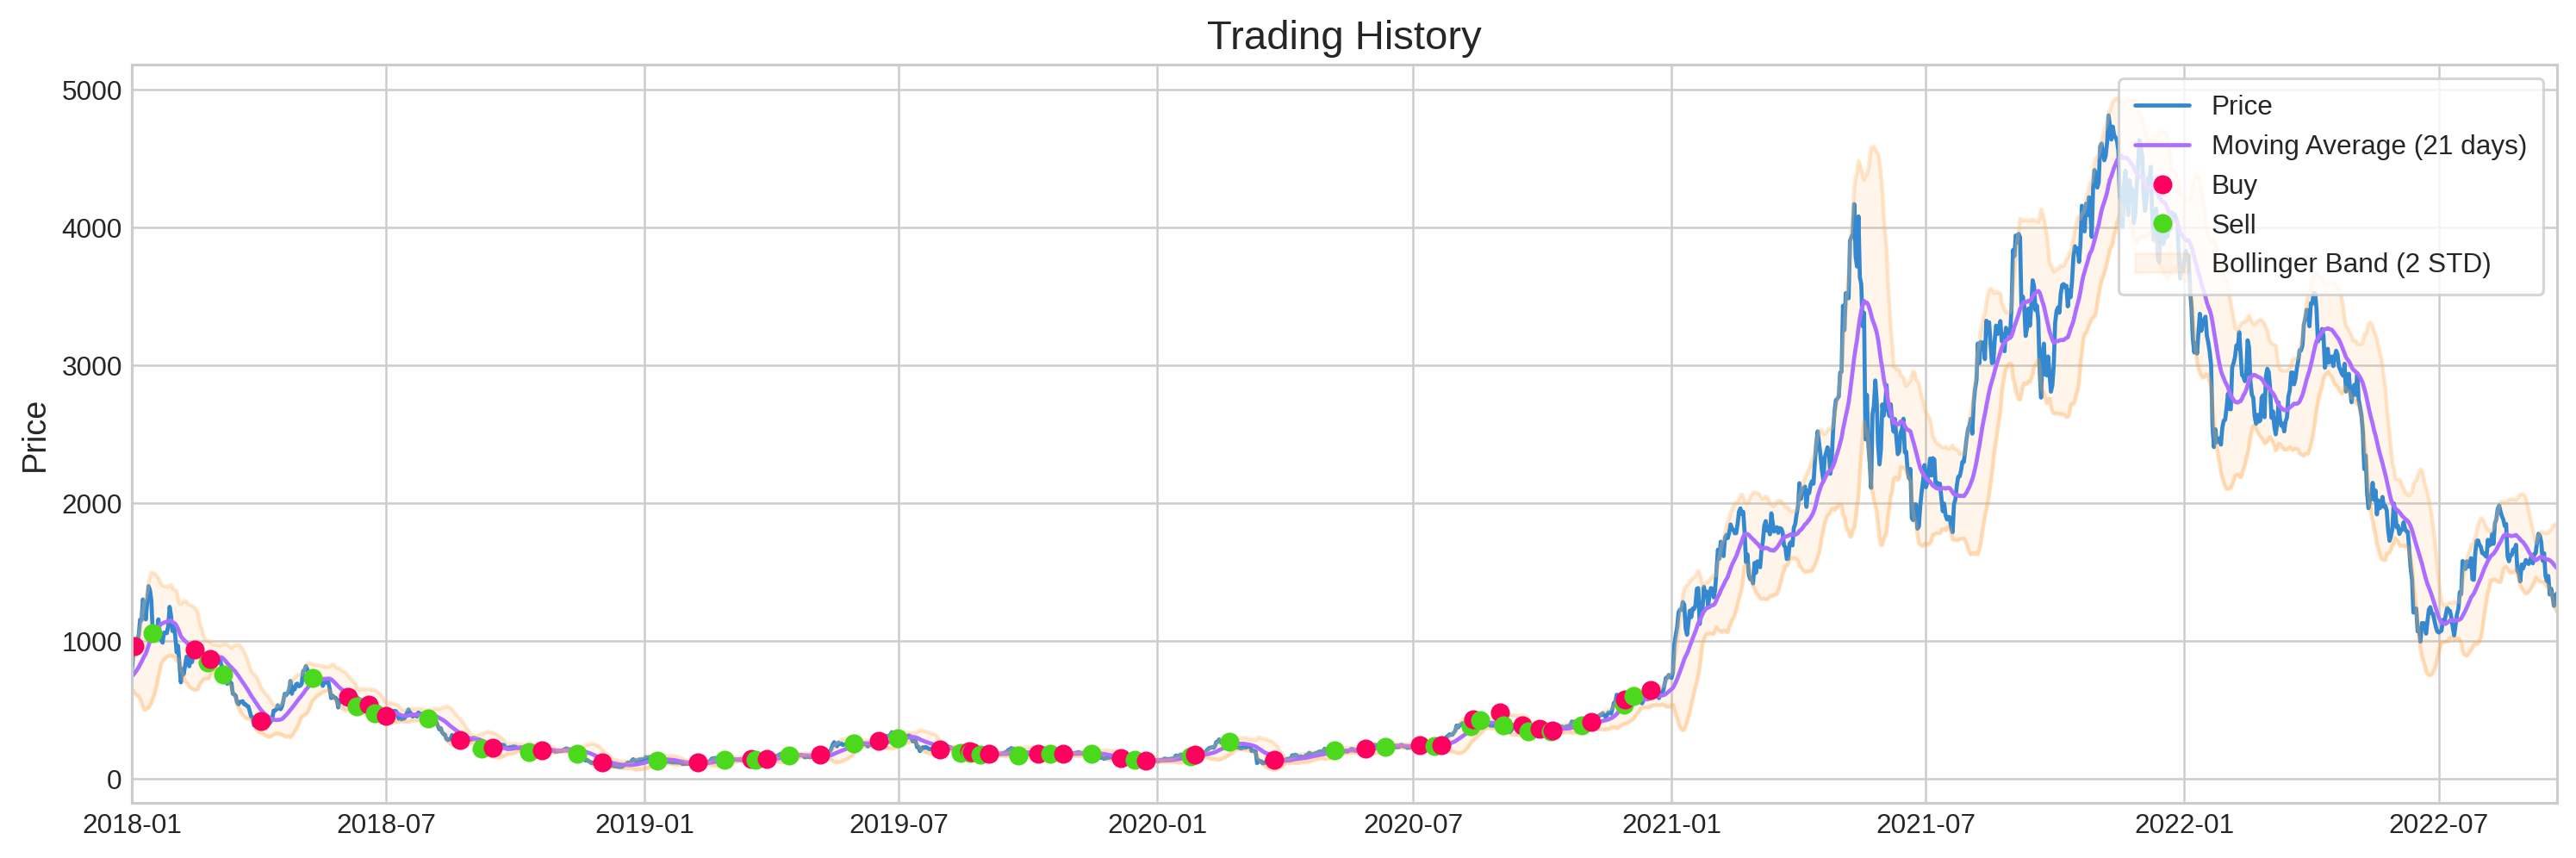

Number of Trades: 118
Time Frame: 1675 days
Profit: $92490.48 | 1849.81%


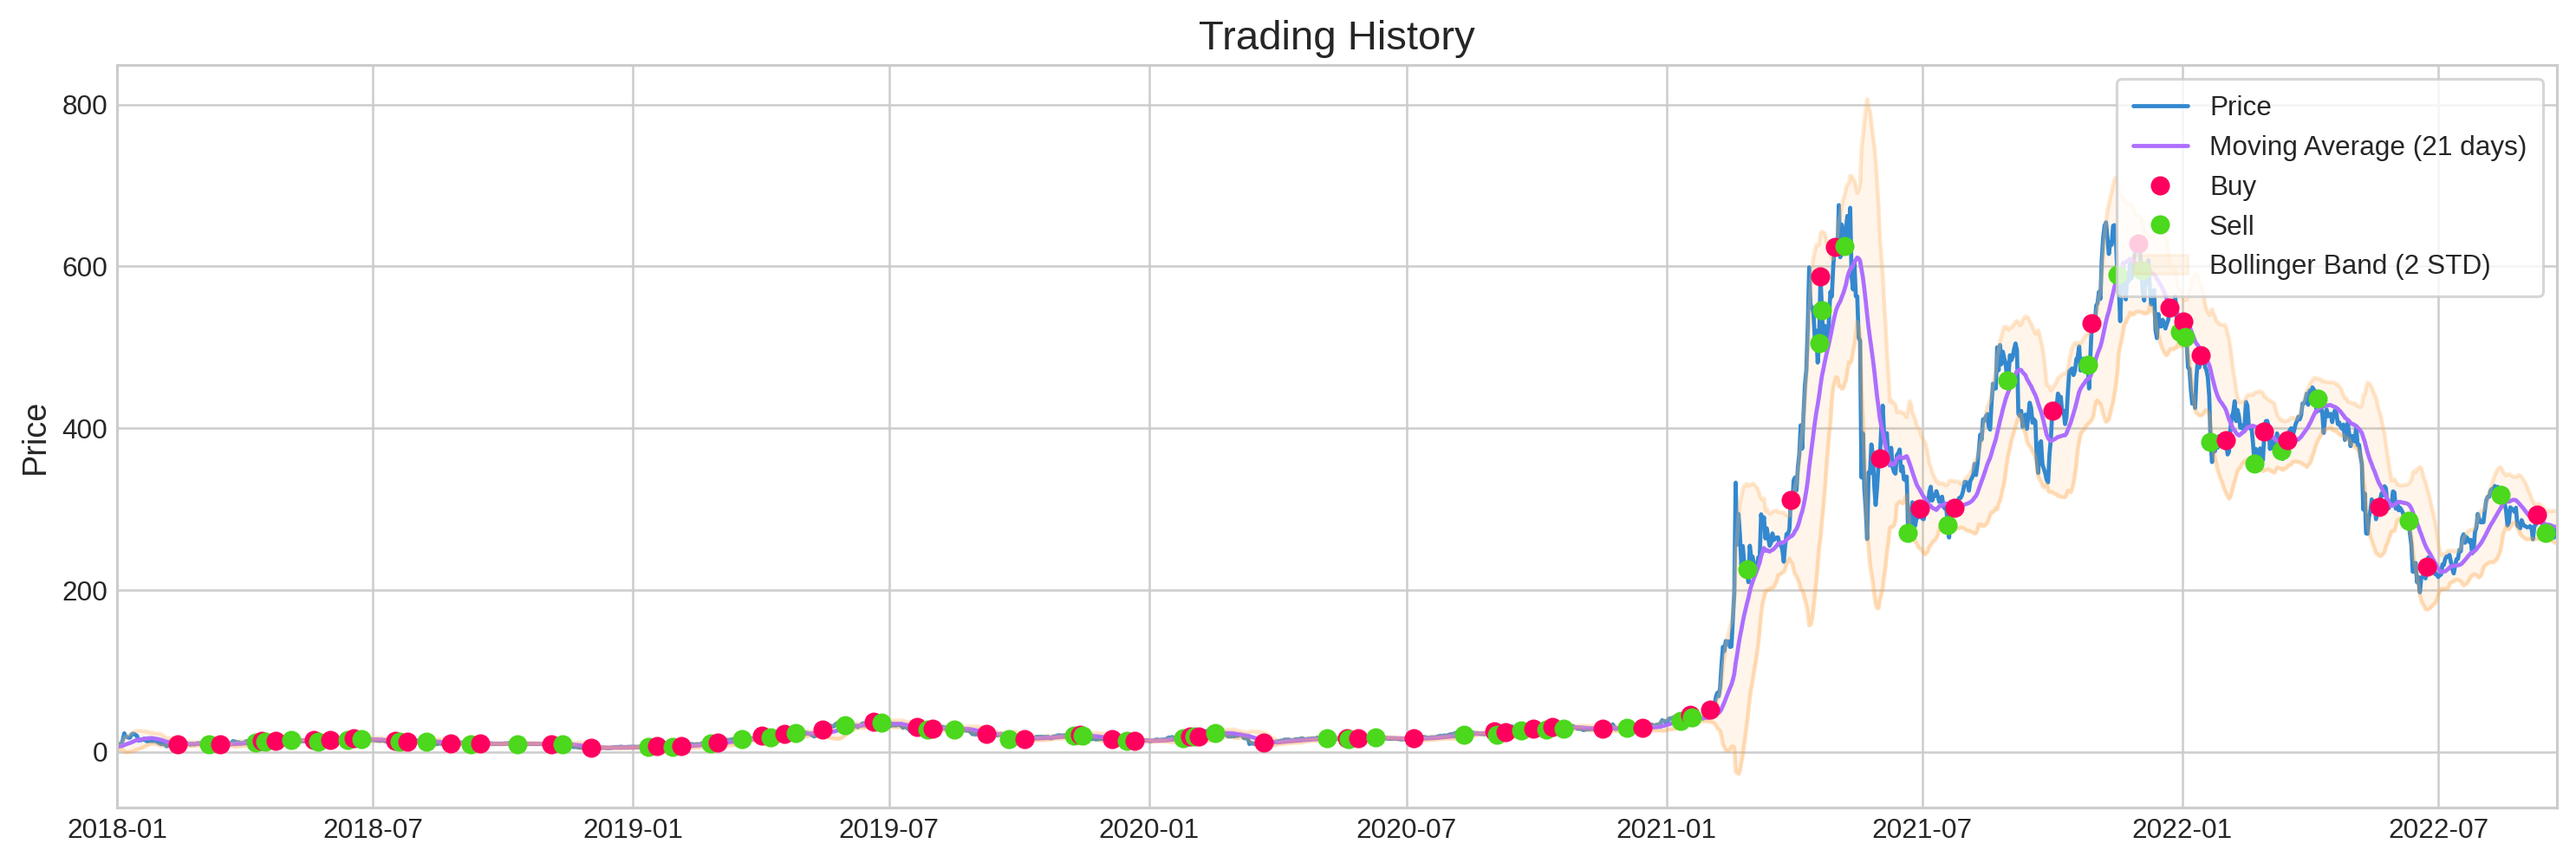

Number of Trades: 120
Time Frame: 1679 days
Profit: $-1055.48 | -21.11%


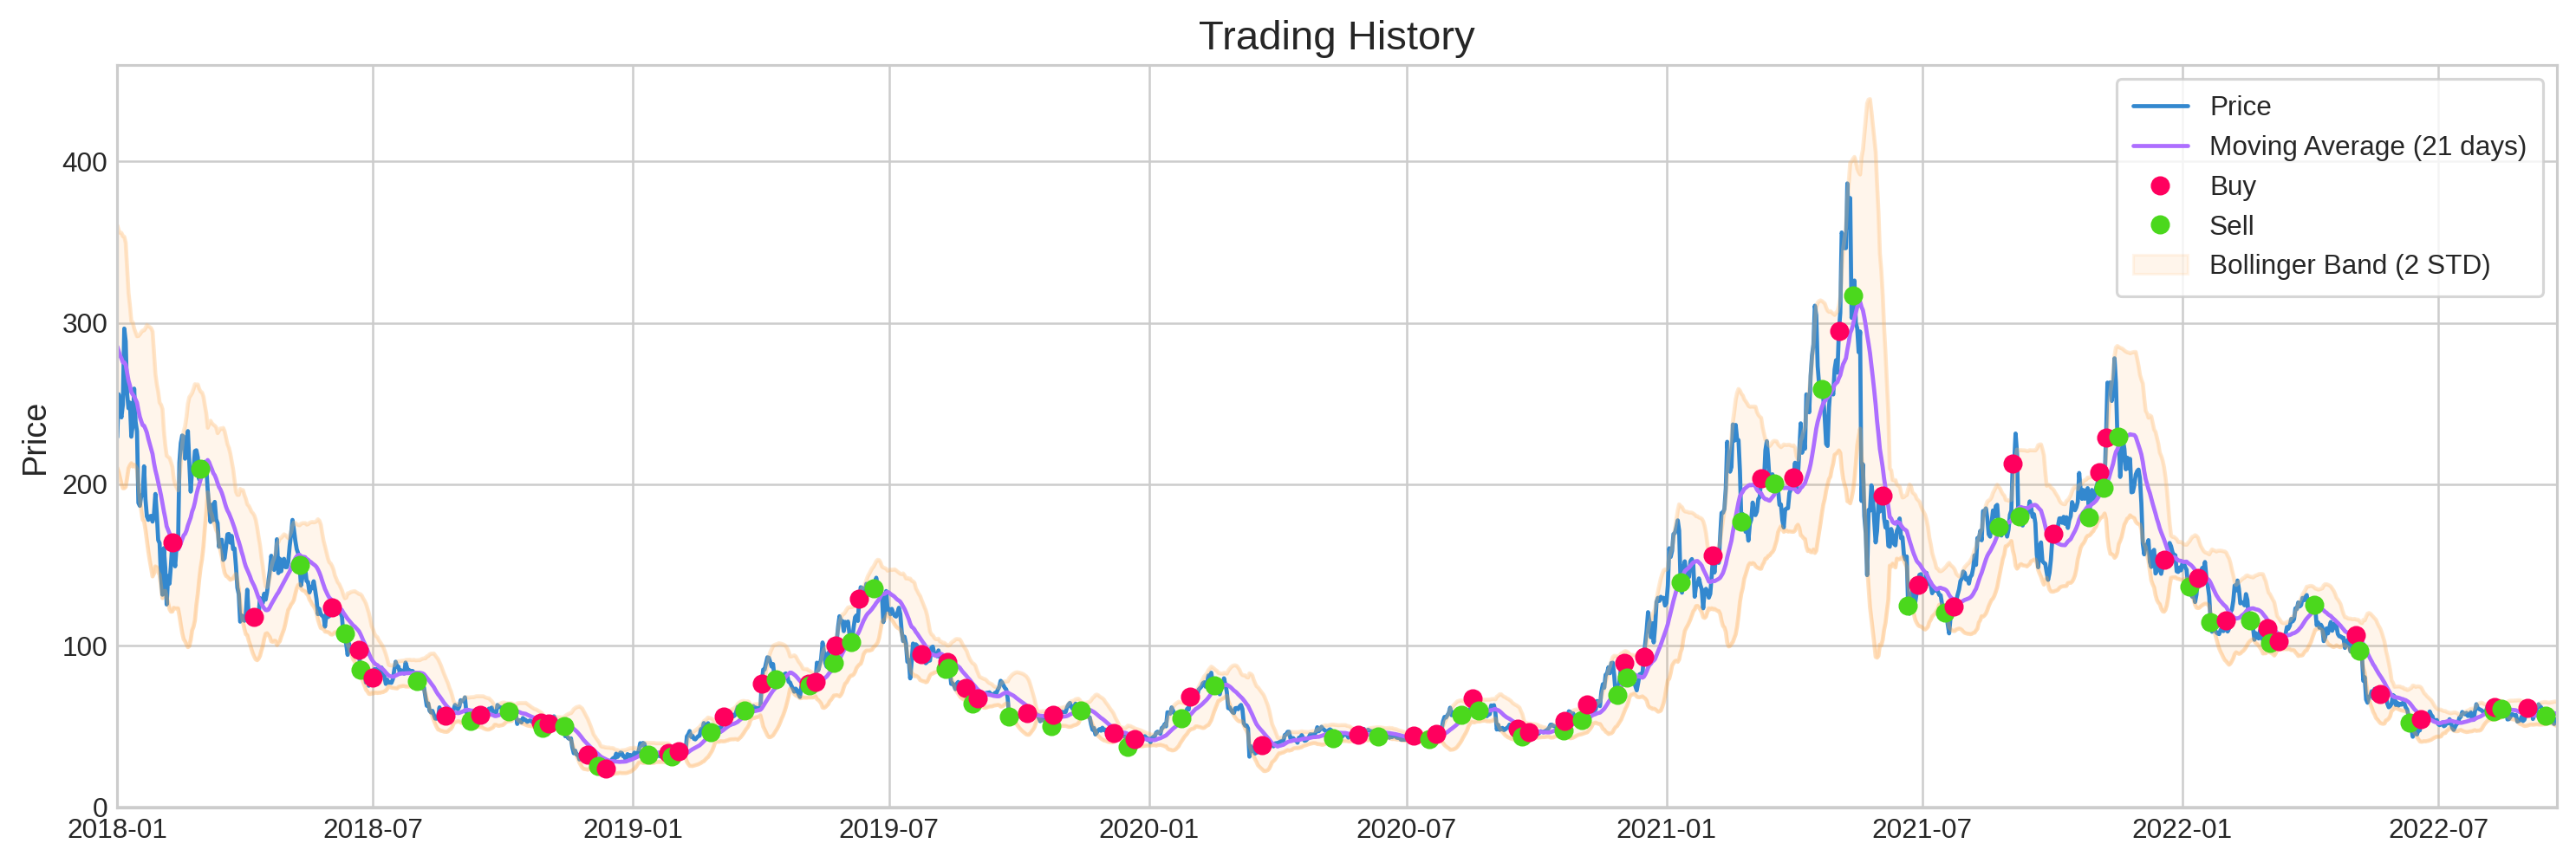

Company  Return (%)
2  bnb_coin_data     1849.81
3   litcoin_data      -21.11
0   bitcoin_data     -100.00
1  etherium_data     -100.00

In [ ]:
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = macd_trading(
        stocks[i].loc['2018':'2022'], 
        budget=5000, 
        show_graph=True, 
        show_return=True
    )
    returns.append(round(profit*100 / 5000, 2))
pd.DataFrame({'Company': companies, 'Return (%)': returns}).sort_values(by='Return (%)', ascending=False)


Number of Trades: 34
Time Frame: 295 days
Profit: $-15000.00 | -100.0%


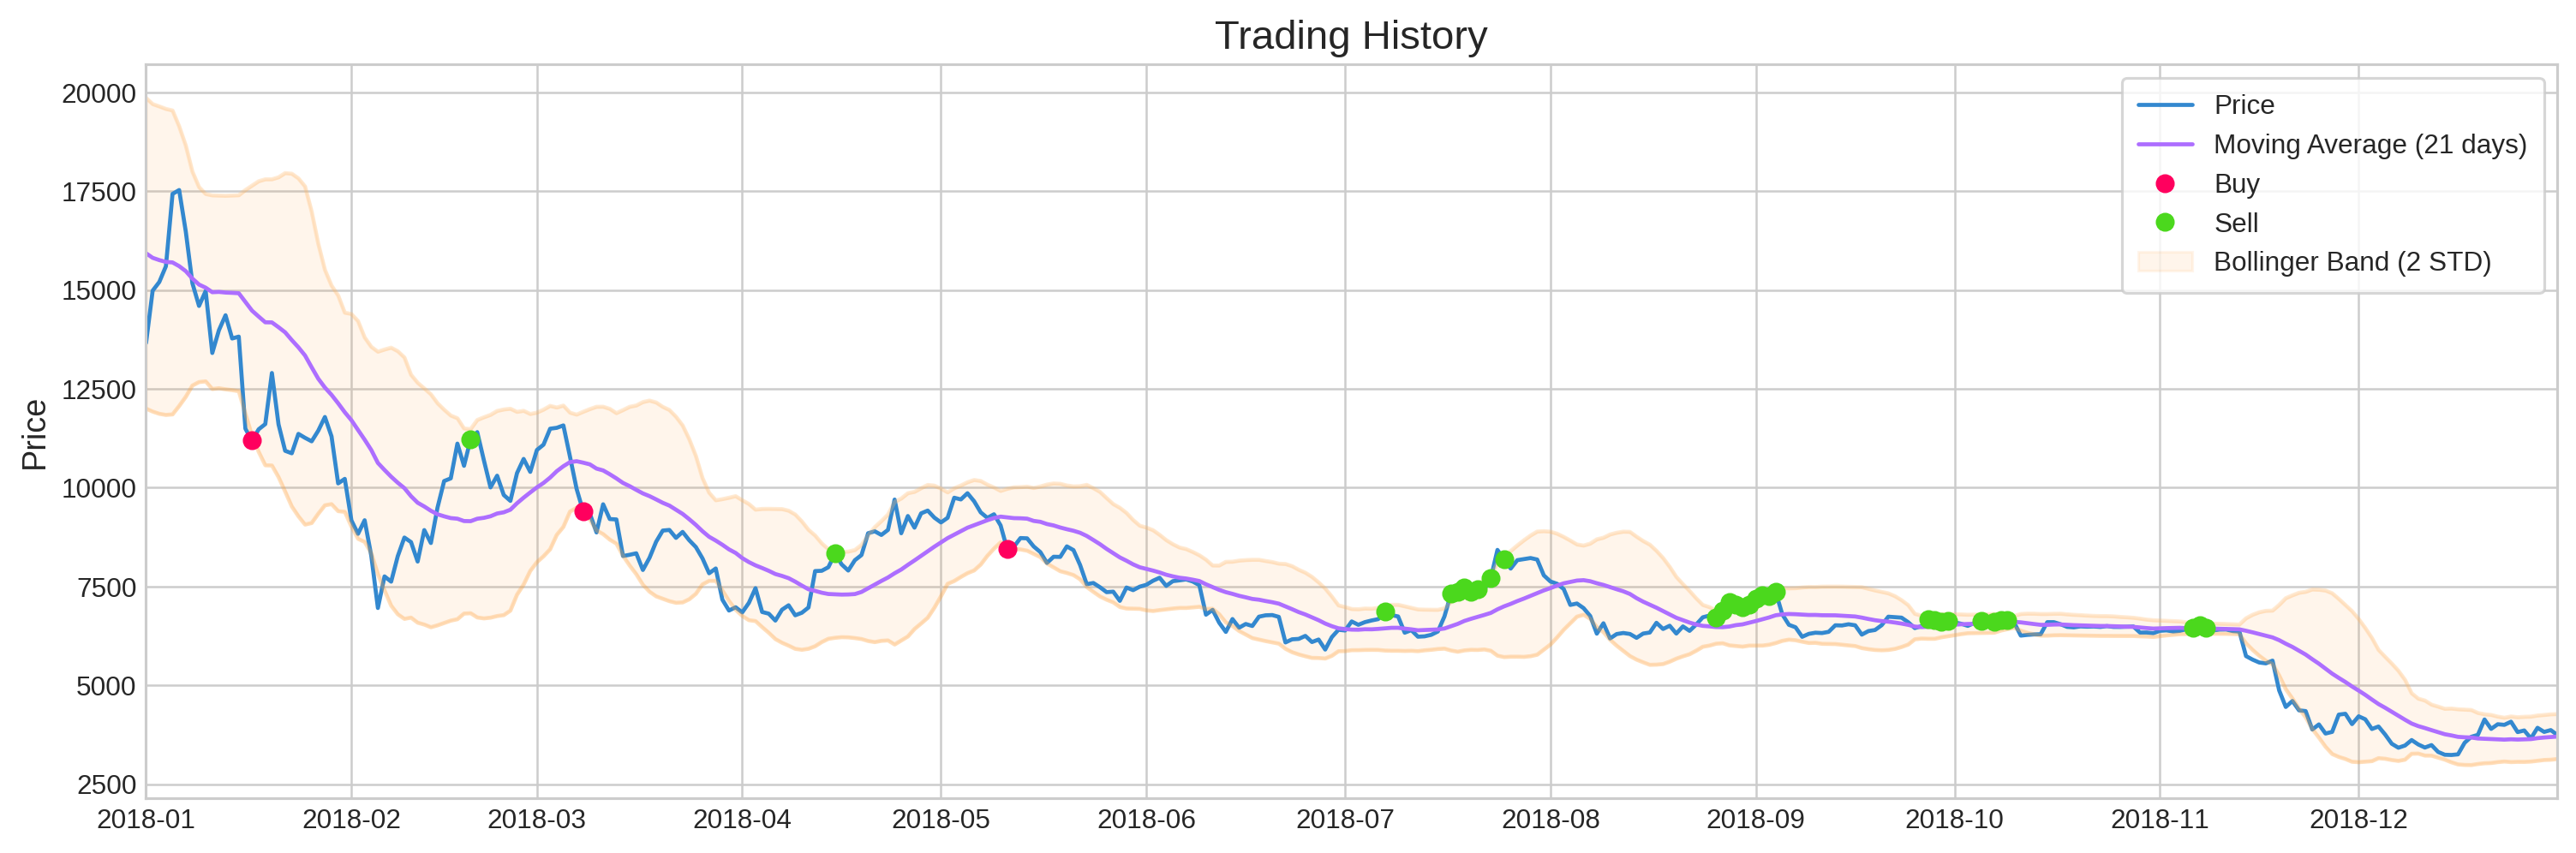

In [ ]:
profit, trades = bb_trading(stocks['bitcoin_data'].loc['2018':'2018'], u=0.03, l=0.03)

Number of Trades: 292
Time Frame: 1699 days
Profit: $-5000.00 | -100.0%


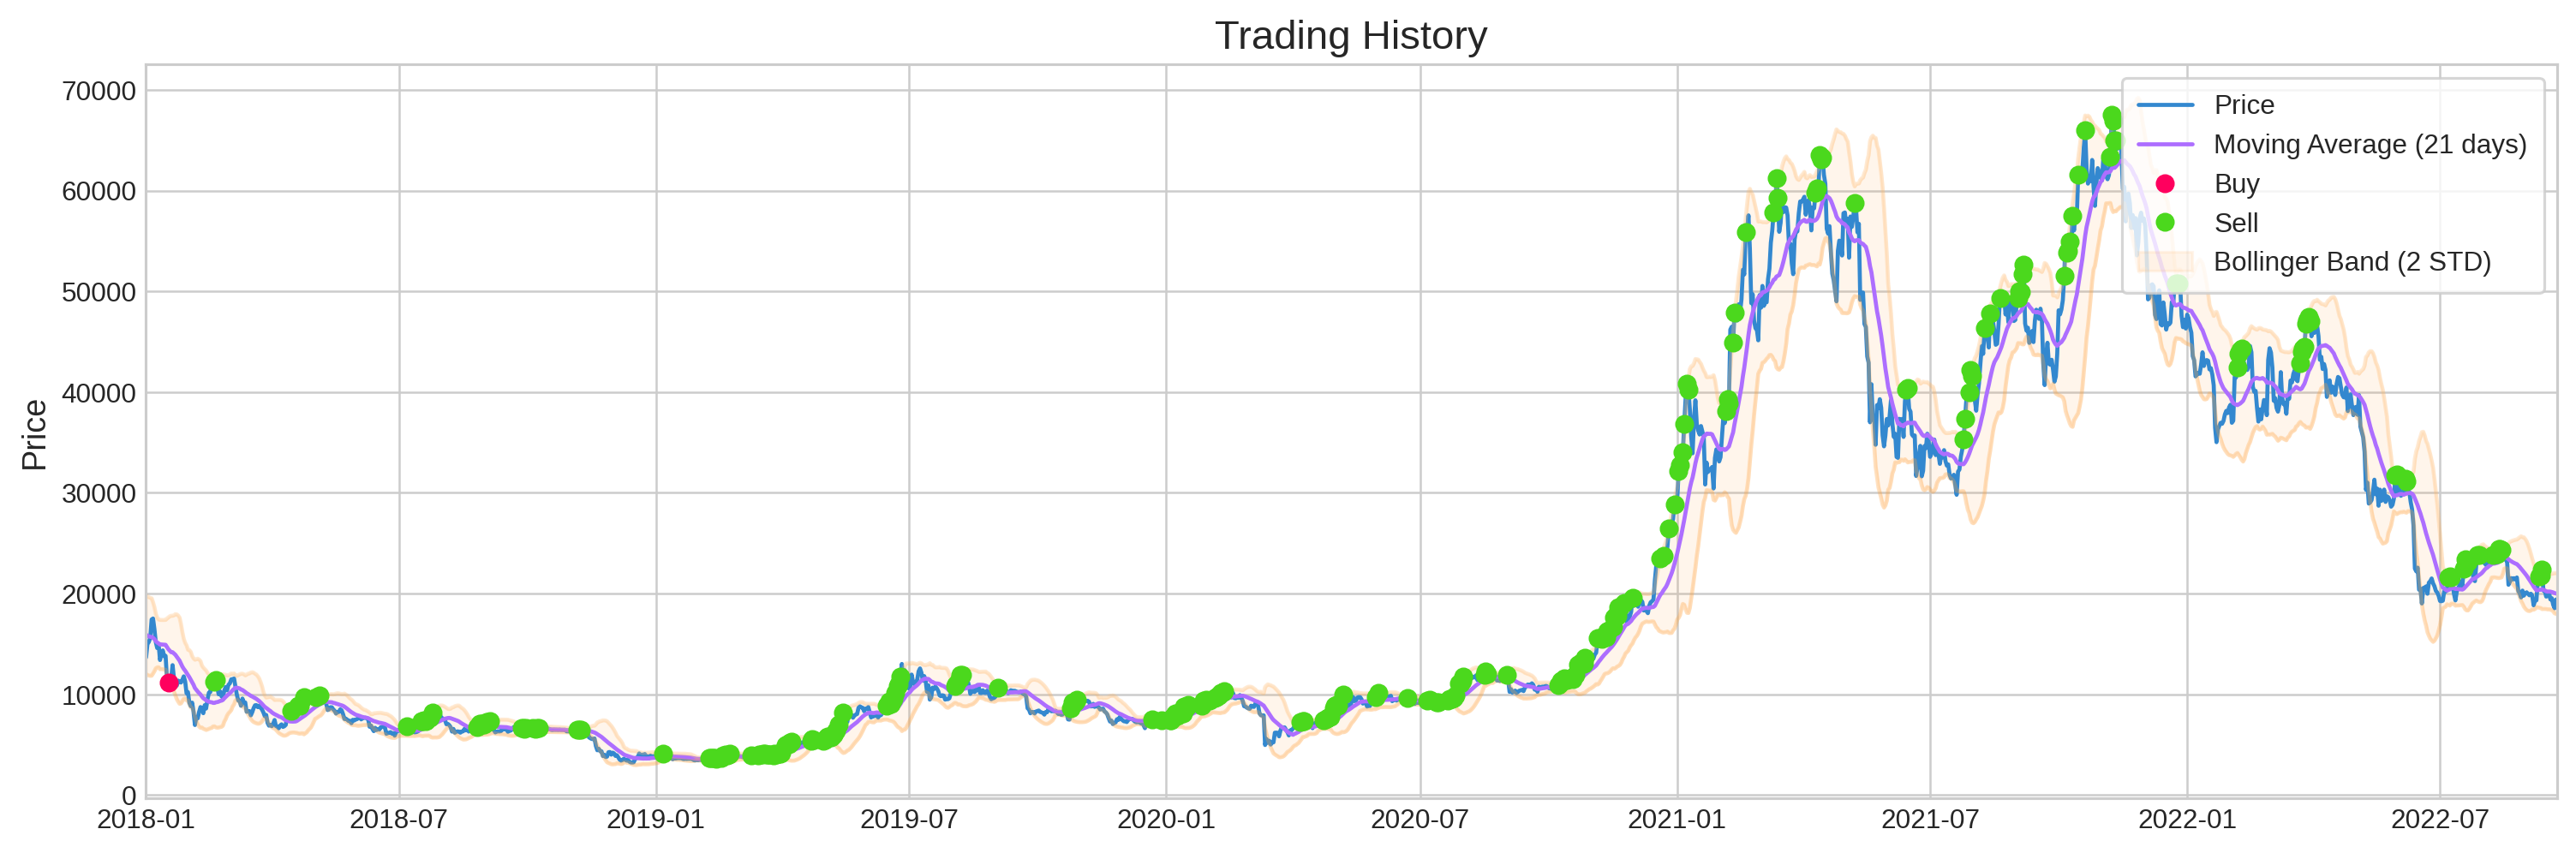

Number of Trades: 187
Time Frame: 1680 days
Profit: $-5000.00 | -100.0%


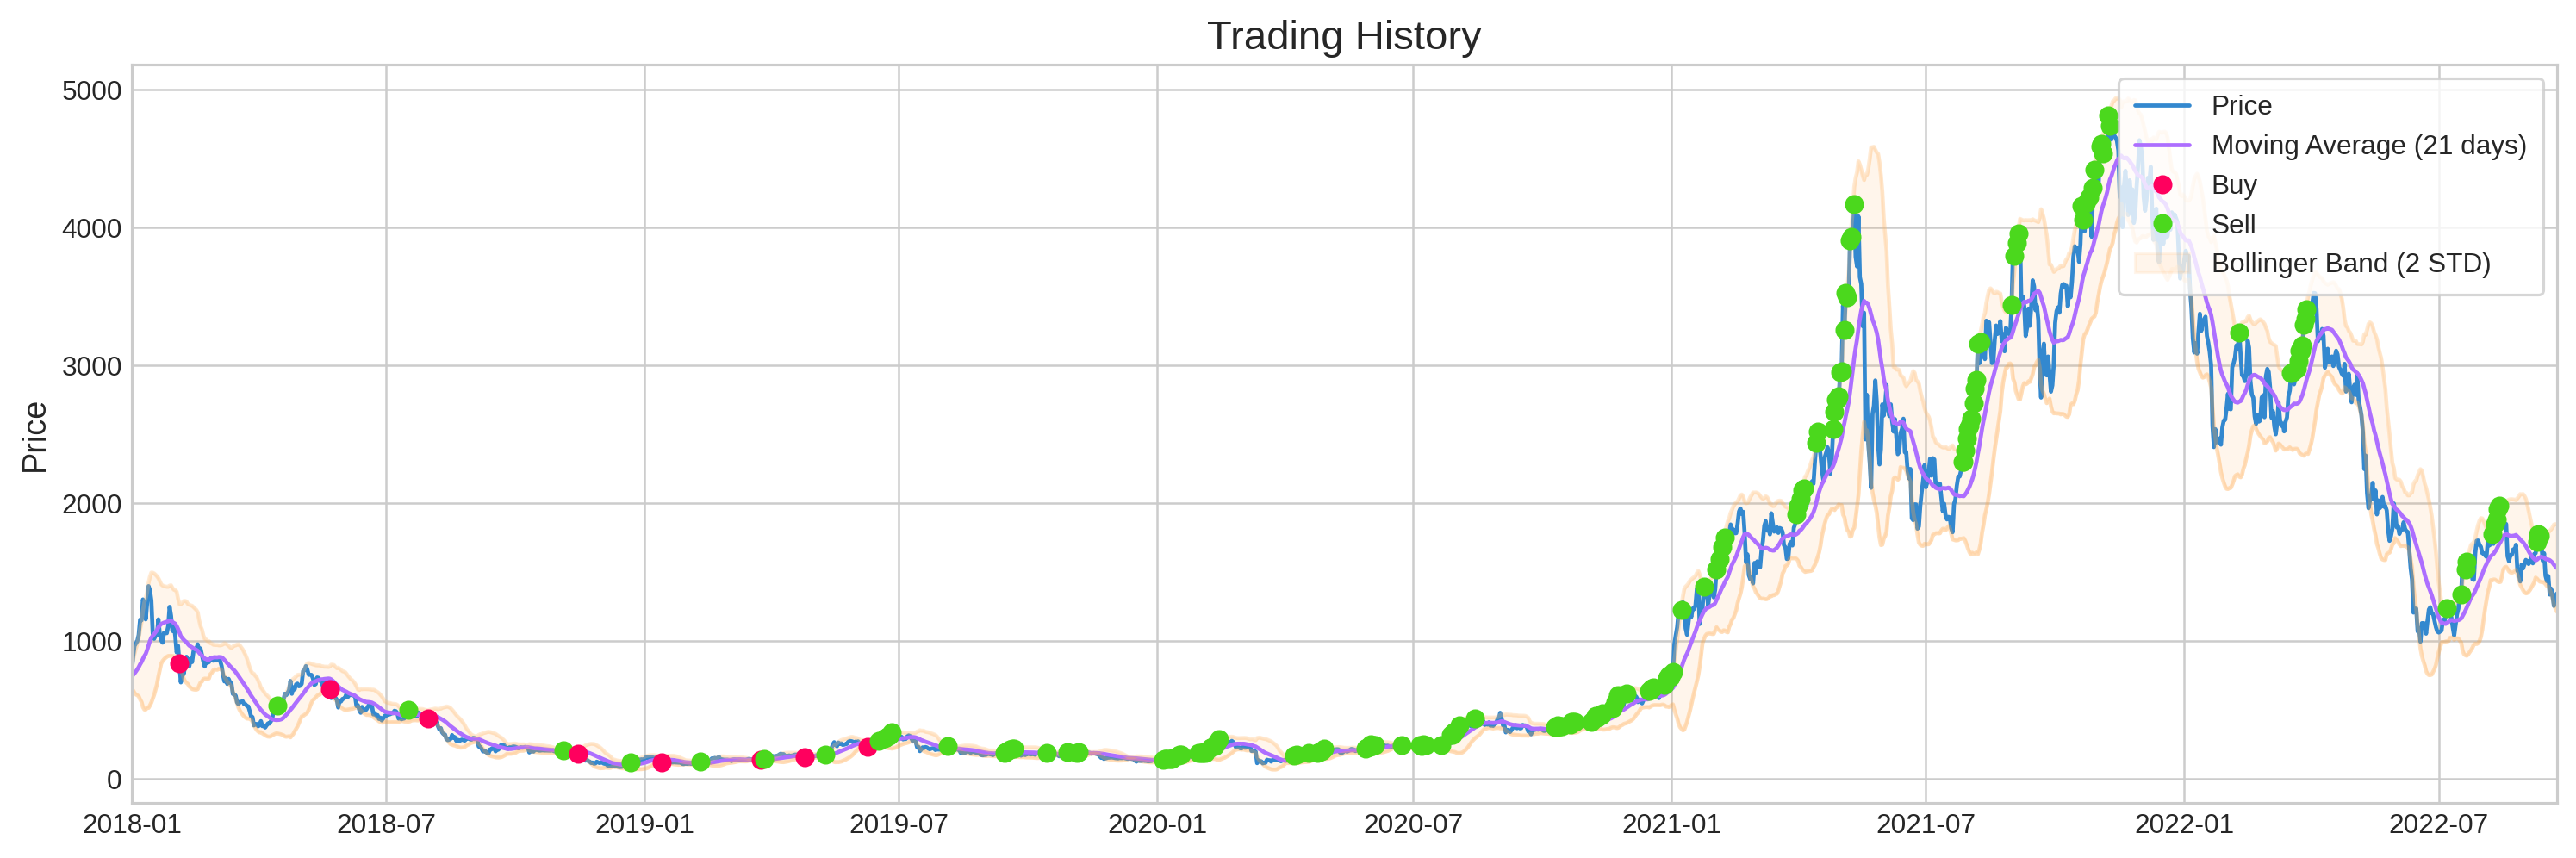

Number of Trades: 45
Time Frame: 1625 days
Profit: $-3601.41 | -72.03%


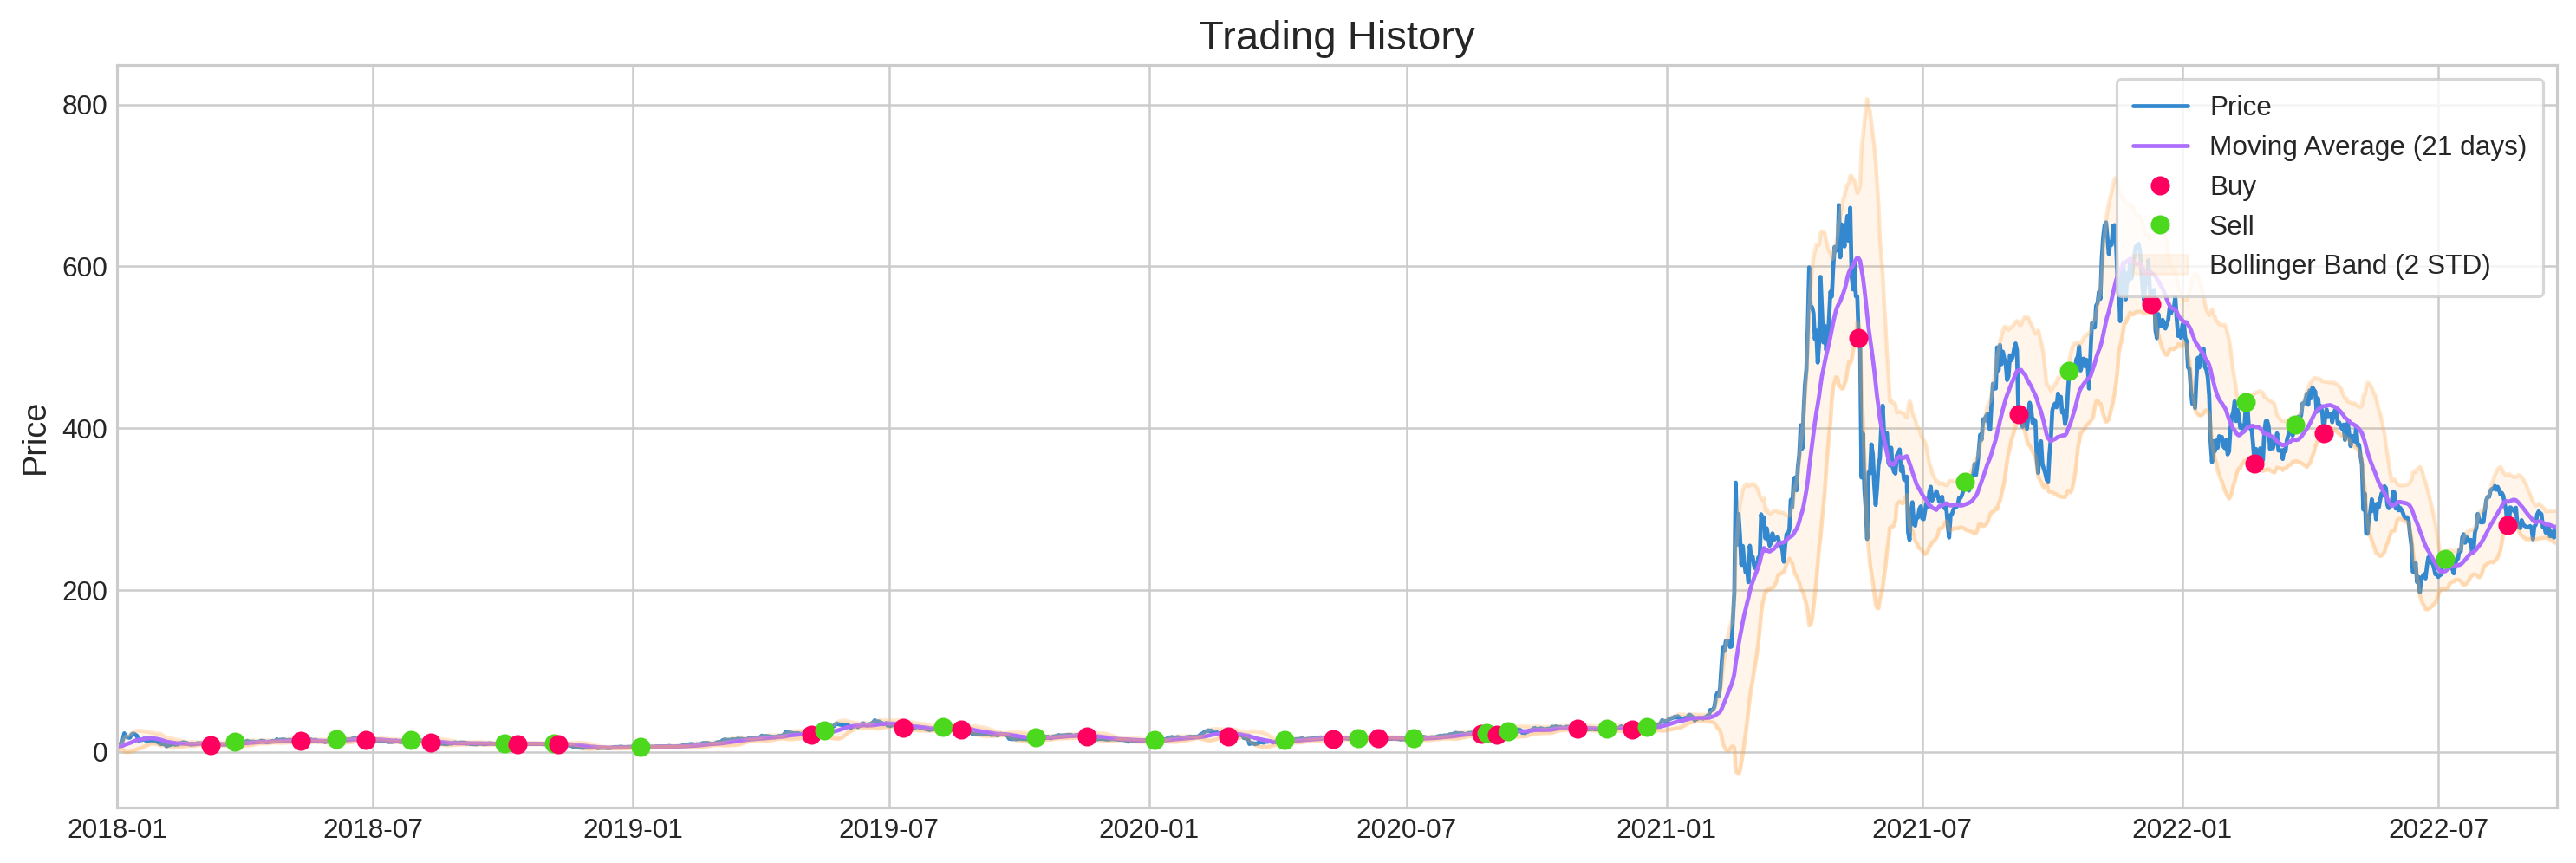

Number of Trades: 43
Time Frame: 1705 days
Profit: $-4947.16 | -98.94%


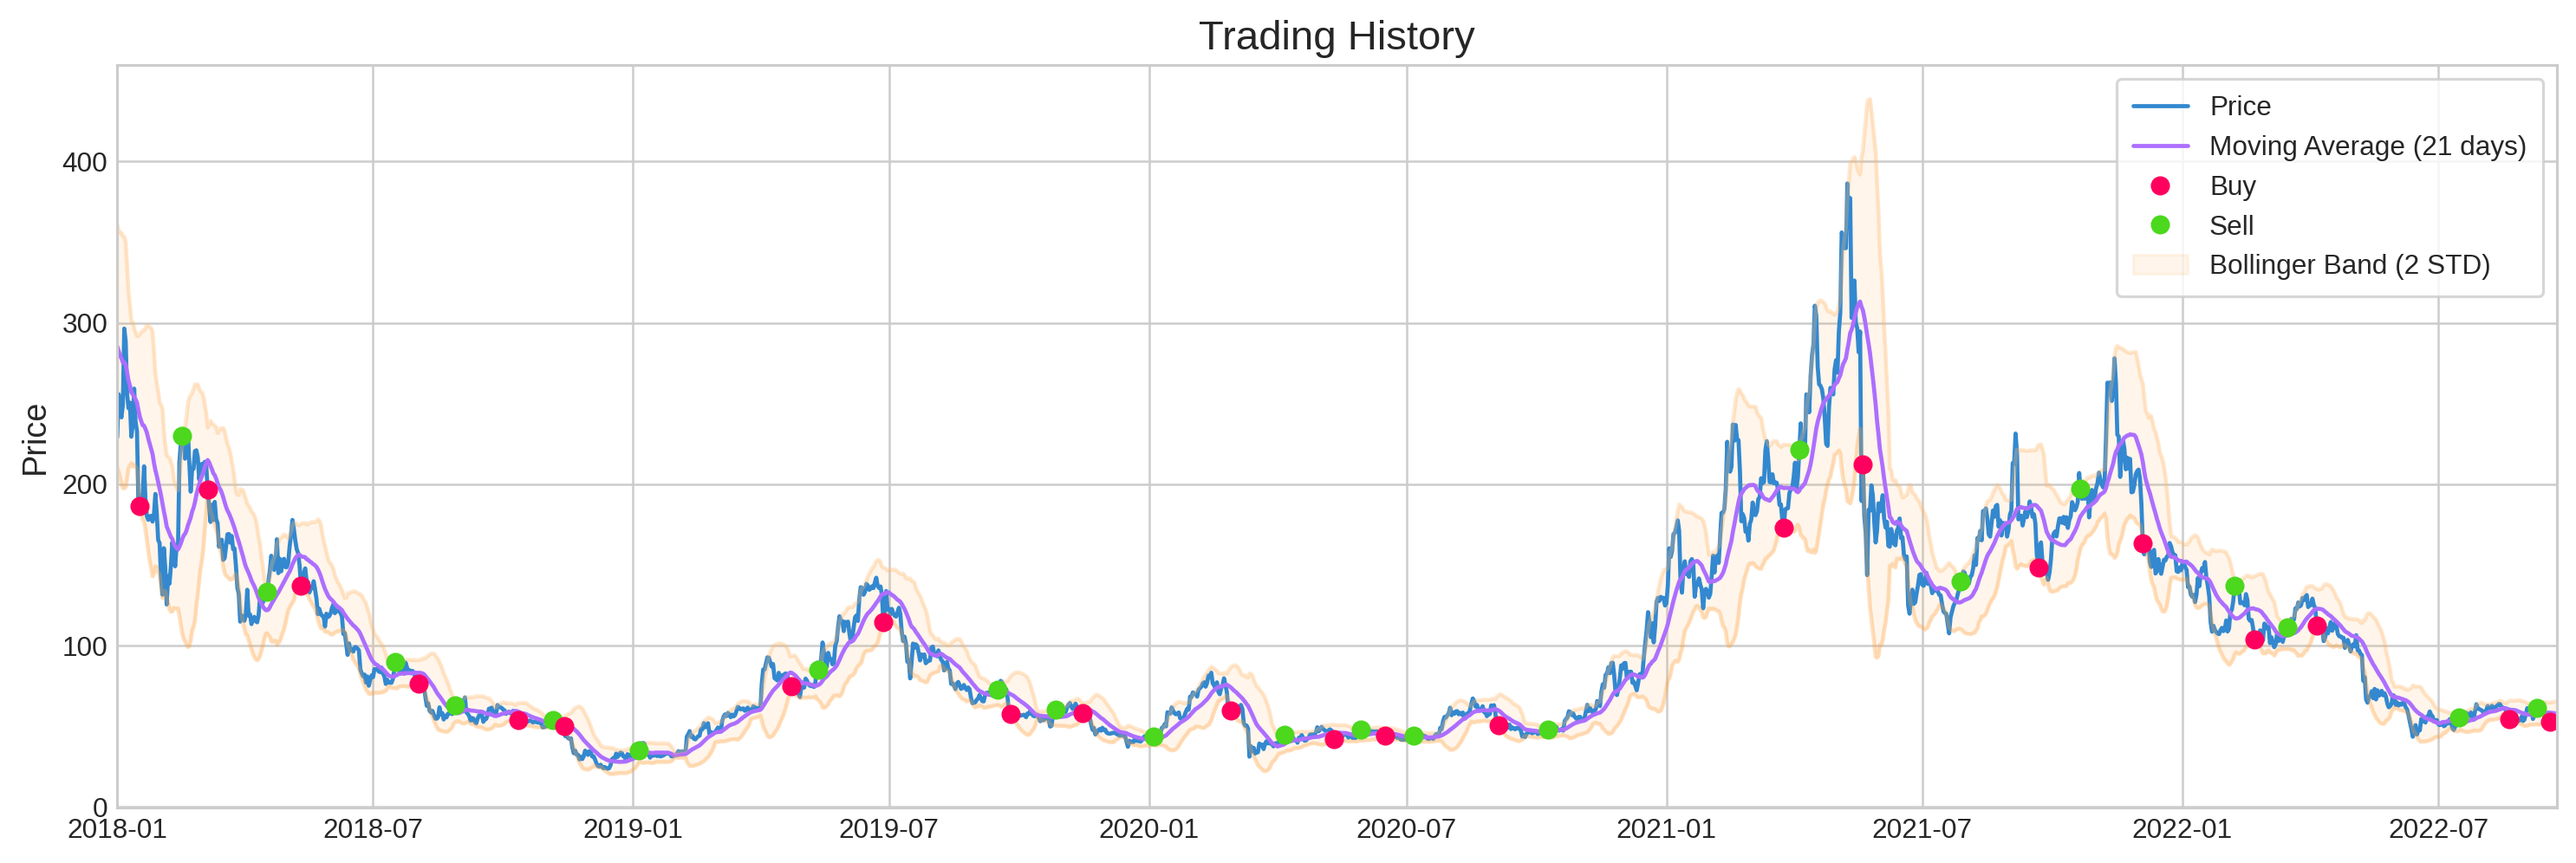

Company  Return (%)
2  bnb_coin_data      -72.03
3   litcoin_data      -98.94
0   bitcoin_data     -100.00
1  etherium_data     -100.00

In [ ]:
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = bb_trading(
        stocks[i].loc['2018':'2022'], 
        budget=5000, 
        u=0.03, 
        l=0.03, 
        show_graph=True, 
        show_return=True
    )
    returns.append(round(profit*100 / 5000, 2))
pd.DataFrame({'Company': companies, 'Return (%)': returns}).sort_values(by='Return (%)', ascending=False)


**Performance comparison**

In [ ]:

MLA = {
     'Bidirectional GRU' : bigru,
     'Bidirectional LSTM' : bilstm,
     'LSTM' : model,
     'CNN' : cnn, 
}

In [ ]:
from sklearn.metrics import *
columns = []
compare = pd.DataFrame(columns = columns)
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    pred, y_true, y_pred, accuracy = evaluation(
                    X_test, y_test, alg, random=False, n_preds=50, 
                    show_graph=False)
    mse = mean_squared_error(y_pred, y_true)
    mae = mean_absolute_error(y_pred, y_true)
    mape = MeanAbsolutePercentageError(y_pred, y_true)
    compare.loc[row_index,'name'] = MLA_name
    compare.loc[row_index, 'accuracy'] = accuracy
    compare.loc[row_index, 'mean squared error'] = mse
    compare.loc[row_index, 'mean absolute error'] = mae
    compare.loc[row_index, 'mean absolute percentage error'] = mape
    row_index+=1
    
compare.sort_values(by = ['accuracy'], ascending = False, inplace = True)    
compare